**Dataset Preparation**

Filtering out three years data from comments and post dataset

In [ ]:
import json
import datetime

# Input and output file names (adjust as needed)
input_file = "SuicideWatch_comments"
output_file = "reddit_comments_2022_2024_1.json"

with open(input_file, "r", encoding="utf-8") as infile, open(output_file, "w", encoding="utf-8") as outfile:
    for line in infile:
        try:
            record = json.loads(line)
        except json.JSONDecodeError:
            continue  # Skip invalid JSON lines

        # Check if the record has the 'created_utc' field
        if "created_utc" in record:
            try:
                # Convert the created_utc field to an integer timestamp
                timestamp = int(record["created_utc"])
                # Convert timestamp to a UTC datetime object
                dt = datetime.datetime.utcfromtimestamp(timestamp)
            except (ValueError, TypeError):
                continue

            # Check if the year is between 2022 and 2024 (inclusive)
            if 2022 <= dt.year <= 2024:
                # Write the JSON record to the output file
                json.dump(record, outfile)
                outfile.write("\n")


In [ ]:
import json
import datetime

# Input and output file names (adjust as needed)
input_file = "SuicideWatch_submissions"
output_file = "reddit_submissions_2022_2024_1.json"

with open(input_file, "r", encoding="utf-8") as infile, open(output_file, "w", encoding="utf-8") as outfile:
    for line in infile:
        try:
            record = json.loads(line)
        except json.JSONDecodeError:
            continue  # Skip invalid JSON lines

        # Check if the record has the 'created_utc' field
        if "created_utc" in record:
            try:
                # Convert the created_utc field to an integer timestamp
                timestamp = int(record["created_utc"])
                # Convert timestamp to a UTC datetime object
                dt = datetime.datetime.utcfromtimestamp(timestamp)
            except (ValueError, TypeError):
                continue

            # Check if the year is between 2022 and 2024 (inclusive)
            if 2022 <= dt.year <= 2024:
                # Write the JSON record to the output file
                json.dump(record, outfile)
                outfile.write("\n")


Removing unwanted fields from dataset

In [ ]:
import json

# Fields to retain in each post
post_fields = [
    "author",
    "author_created_utc",
    "author_fullname",
    "category",
    "comments",
    "created_utc",
    "id",
    "name",
    "num_comments",
    "score",
    "selftext",
    "title",
    "top_awarded_type",
    "total_awards_received"
]

# Fields to retain in each comment


input_file = "reddit_submissions_2022_2024_1.json"         # Your original NDJSON
output_file = "reddit_submissions_2022_2024_1_filtered.json"      # Filtered output

with open(input_file, "r", encoding="utf-8") as infile, \
     open(output_file, "w", encoding="utf-8") as outfile:

    for line in infile:
        line = line.strip()
        if not line:
            continue
        try:
            record = json.loads(line)
        except json.JSONDecodeError:
            continue

        # Copy only the desired post-level fields
        filtered_post = {k: record.get(k) for k in post_fields if k in record}



        # Write out as one NDJSON line
        outfile.write(json.dumps(filtered_post) + "\n")

print(f"Filtered dataset saved to '{output_file}'.")


In [ ]:
import json

# Fields to retain in each comment
comment_fields = [
    "all_awardings",
    "author",
    "author_created_utc",
    "author_fullname",
    "body",
    "controversiality",
    "created_utc",
    "id",
    "is_submitter",
    "link_id",
    "name",
    "parent_id",
    "score",
    "top_awarded_type",
    "total_awards_received"
]

input_file = "reddit_comments_2022_2024_1.json"        # Input NDJSON file containing only comments
output_file = "reddit_comments_filtered.json"   # Filtered output

with open(input_file, "r", encoding="utf-8") as infile, \
     open(output_file, "w", encoding="utf-8") as outfile:

    for line in infile:
        line = line.strip()
        if not line:
            continue
        try:
            comment = json.loads(line)
        except json.JSONDecodeError:
            continue

        # Filter the comment fields
        filtered_comment = {k: comment.get(k) for k in comment_fields if k in comment}

        # Write the filtered comment as one NDJSON line
        outfile.write(json.dumps(filtered_comment) + "\n")

print(f"Filtered comments saved to '{output_file}'.")


Integrating both posts and comments into complete thread

In [ ]:
import json

# Load posts into a dictionary using their id as key.
posts = {}
with open("reddit_submissions_2022_2024_1_filtered.json", "r", encoding="utf-8") as posts_file:
    for line in posts_file:
        try:
            post = json.loads(line)
            post_id = post.get("id")
            if post_id:
                # Initialize a comments list in each post record.
                post["comments"] = []
                posts[post_id] = post
        except json.JSONDecodeError:
            continue

# Process comments and add them to the corresponding post.
with open("reddit_comments_filtered.json", "r", encoding="utf-8") as comments_file:
    for line in comments_file:
        try:
            comment = json.loads(line)
            # Extract the link_id and remove the "t3_" prefix if present.
            link_id = comment.get("link_id", "")
            if link_id.startswith("t3_"):
                link_id = link_id[3:]
            # Append the comment to the corresponding post if it exists.
            if link_id in posts:
                posts[link_id]["comments"].append(comment)
        except json.JSONDecodeError:
            continue

# Write the integrated data to a new JSON file.
with open("integrated_reddit_data.json", "w", encoding="utf-8") as outfile:
    for post in posts.values():
        json.dump(post, outfile)
        outfile.write("\n")

In [ ]:
# Code for deleteing post for which content is removed or deleted
import json

input_file = "integrated_reddit_data_1.json"  # Your integrated file
output_file = "integrated_reddit_data_filtered.json"  # New output file

with open(input_file, "r", encoding="utf-8") as infile, open(output_file, "w", encoding="utf-8") as outfile:
    for line in infile:
        try:
            post = json.loads(line)
        except json.JSONDecodeError:
            continue  # Skip invalid JSON lines

        # Check the post's content: skip the post if its selftext is removed or deleted.
        post_content = post.get("selftext", "").strip()
        if post_content in ("[deleted]", "[removed]"):
            continue  # Skip this post entirely

        # Filter the comments: remove comments where the body is "[deleted]" or "[removed]"
        filtered_comments = []
        for comment in post.get("comments", []):
            comment_body = comment.get("body", "").strip()
            if comment_body not in ("[deleted]", "[removed]"):
                filtered_comments.append(comment)
        post["comments"] = filtered_comments

        # Write the cleaned post to the output file
        json.dump(post, outfile)
        outfile.write("\n")


In [ ]:
#Preparing user centric dataset for data extraction
import json

INPUT_FILE  = "integrated_reddit_data_filtered.json"
OUTPUT_FILE = "user_grouped_dataset.json"

# this dict will map user_id -> list of {"post":..., "comments":[...]}
user_data = {}

with open(INPUT_FILE, "r", encoding="utf-8") as infile:
    for line in infile:
        line = line.strip()
        if not line:
            continue
        try:
            thread = json.loads(line)
        except json.JSONDecodeError:
            continue

        # identify the user
        user = thread.get("author", "[unknown]")

        # split out post vs comments
        post = {k: v for k, v in thread.items() if k != "comments"}
        comments = thread.get("comments", [])

        entry = {
            "post": post,
            "comments": comments
        }

        user_data.setdefault(user, []).append(entry)

# write the grouped structure to disk
with open(OUTPUT_FILE, "w", encoding="utf-8") as outfile:
    json.dump(user_data, outfile, indent=2)

print(f"Written grouped dataset ⇒ {OUTPUT_FILE}")


Feature Extraction using **LLM**

In [ ]:
import json
import csv
import time
import io
from google.generativeai import GenerativeModel, configure
from typing import Dict, List

# STEP 1: Configure your Gemini API key
configure(api_key="API_KEY")
model = GenerativeModel("gemini-2.0-flash")

# 👉 IMPORTANT: Define your CSV Columns (this must match your prompt output)
CSV_COLUMNS = [
    "AuthorID", "Main_Post_ID", "Comment_ID", "Timestamp", "NumComments", "Score",
    "PreparatoryPlanMentioned", "SelfHarmOrSuicidalThoughtsMentioned",
    "SuicidalOrNSSIMethods", "ReasonBehindSuicideNSSI", "MentalIllnessTraits",
    "TraitsMentioned", "AttemptedSuicide", "MultipleAttempt", "AbortedAttempt",
    "ReasonForAbortedAttempt", "InterruptedAttempt", "ReasonForInterruptedAttempt",
    "TreatmentMechanism", "HealthyCopingMechanism", "UnhealthyCopingMechanism", "Gender", "AgeGroup",
    "OccupationStatus", "SentimentScore", "EmotionalScore", "SuicidalIdeationTemporalFocus",
    "CopingMechanismTreatmentTemporalFocus", "RiskOfSuicideAttempt"
]

# 👉 1. Load your input JSON
def load_data(path: str) -> Dict[str, List[Dict]]:
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

# 👉 2. Build your batch prompt
def build_batch_prompt(batch: Dict[str, List[Dict]]) -> str:
    """
    Build a full prompt for a batch of users.
    """
    # --------- ✨ PASTE YOUR BIG FULL PROMPT TEXT HERE ✨ ---------
    intro = f"""
Role: You are an experienced psychiatrist specializing in suicide ideation and non-suicidal self-injury (NSSI) research, utilizing NLP techniques to analyze Reddit data.
Task: For a given Reddit thread, process the main post and all subsequent comments made by the same author. Treat each of these as a separate document for analysis. While the primary focus is on the explicit content provided by the author, you should also consider the context provided by other users' comments to understand potential dependencies, clarifications, confirmations, or denials related to the author's statements.



For each feature, first read its definition and then immediately provide the answer for that feature before continuing to the next.Mandatory fill all the fields. Always keep number of fields matching exactly header.




*Columns (Must be in same order):*
AuthorID,
Main_Post_ID,
Comment_ID,
Timestamp,
NumComments,
Score,
PreparatoryPlanMentioned,
SelfHarmOrSuicidalThoughtsMentioned,
SuicidalOrNSSIMethods,
ReasonBehindSuicideNSSI,
MentalIllnessTraits,
TraitsMentioned,
AttemptedSuicide,
MultipleAttempt,
AbortedAttempt,
ReasonForAbortedAttempt,
InterruptedAttempt,
ReasonForInterruptedAttempt,
TreatmentMechanism,
HealthyCopingMechanism,
UnhealthyCopingMechanism,
Gender,
AgeGroup,
OccupationStatus,
SentimentScore,
EmotionalScore,
SuicidalIdeationTemporalFocus,
CopingMechanismTreatmentTemporalFocus,
RiskOfSuicideAttempt





- *Main_Post_ID*: the ID of the main post.
- *Comment_ID*: fill it with “NA” for the main post; for comment-rows fill with that comment’s ID.
- *Timestamp*: use the UTC timestamp of the post or comment.
- *NumComments*: only for the main post, Count of comments on that post; fill with “NA” for comment-rows.
- *Score*: - Extract 'Score' from metadata for main posts, otherwise fill with “NA”.


For every row, whether it’s a post or a comment, extract features *only* from that text:
- For the main post row, analyze the post’s title and body of the author's main post.
- For each and every comment made by the author of the main post within this thread, create a new row and analyze the text of that specific comment to extract the features. Ignore the author’s comments which do not add value to the thread and don’t say much about their emotional quotient.


*Feature definitions & examples:*
1. PreparatoryPlanMentioned.
- Your task is to identify preparatory behaviors related to suicide attempts or self-harm mentioned by the target user. Focus primarily on explicit actions described by the target user. However, also consider the content of other users' comments and how the target user's responses might confirm, deny, or modify information related to preparatory behaviors, following the Columbia Suicide Severity Rating Scale (C SSRS) preparatory behaviour category. Focus on concrete behaviors such as gathering means (e.g., pills, sharp objects). Exclude statements of intent, feelings, or vague statements without explicit actions unless they are directly linked to a confirmed preparatory behavior.
- Return ‘Yes’: if the user describes any of the following or any similar forward-looking behaviour not in this list—
Below are some preparatory planning behaviors along with examples.
• Acquiring Means:
 – “Collected all the pills in the house.”
 – “Stashed antifreeze under my bed.”
• Scouting Locations:
 – “Drove to the bridge last night to check if it was quiet.”
 – “Walked the train tracks to pick a spot.”
• Preparing Implements:
 – “Sharpened razor blades and tested them on my arm.”
 – “Bought rope at the hardware store and tied a noose.”
• Composing Final Messages:
 – “Wrote a goodbye letter and tucked it in my drawer.”
 – “Drafted an email to my family but didn’t send it.”
• Removing Obstacles to Discovery:
 – “Cleaned up the bathroom so there’d be no mess.”
 – “Locked the door and silenced my phone.”
• Researching Methods:
 – “Researched hanging techniques on forums.”
 – “Googled lethal Tylenol dosages.”
• Scheduling or Timing:
 – “Set an alarm for midnight so no one finds me.”
 – “Decided I’ll do it this Friday.”
- Return ‘No’: if the user only expresses general distress (e.g., “I feel like ending it,” “I want to die”) with no actionable planning steps.
- Expected Output: Return only “Yes” or “No”.















2. SelfHarmOrSuicidalThoughtsMentioned
- Your task is to detect *any* expression of self-harm or suicide ideation in the author’s text (main post or their own comments). This combines both non-suicidal self-injury (NSSI) thoughts and explicit suicidal thoughts into one binary feature.
- Return *“Yes”* if the user describes either:
• Thoughts or urges to self-injure without intent to die (e.g. “If I cut a little, I’ll know I’m still alive,” “Sometimes I think about slicing my skin just to feel something”).
• Thoughts of suicide, desire to die, or planning self-harm with lethal intent (e.g. “I want to kill myself,” “I’ve been thinking about ending it,” “I’m planning to overdose”).
- Return *“No”* if neither is present.
Expected Output:
Yes or No


3. SuicidalOrNSSIMethods
- Your task is to identify *any* specific self-harm or suicide method described by the user (in the main post or that author’s comments). This single feature combines both suicidal methods and non-suicidal self-injury (NSSI) methods into one unified extraction.
Identify both common and uncommon methods. If a new or unique method is described that doesn't fit existing categories, create a new category for it within the analysis of that specific post or comment,  don’t create overlapping or similar categories as below.
- *Seed Categories & Examples (but not limited to):*
• *Overdose* – “swallowing pills,” “mixing prescriptions,” “downed a bottle of Tylenol,” “took all my meds,” “too many sleeping pills”
• *Firearm* – “buying a gun,” “planning to shoot myself,” “loaded the shotgun,” “gun to my head,” “pulled the trigger”
• *Hanging* – “tying a noose,” “strangling with a belt,” “hung myself in the garage,” “tried to hang myself,” “used a rope”, “Strangling”.
• *Jumping* – “off a bridge,” “from a rooftop,” “leaped into traffic,” “jumped from a building,” “wanted to jump out the window”
• *Vehicle Collision* – “driving into oncoming cars,” “crashing my car intentionally,” “rammed into a wall,” “ran red lights on purpose,” “tried to crash”
• *Cutting* – “slitting my wrists,” “cut myself with a knife,” “razor to my skin,” “cut too deep,” “self-harmed with a blade”, “dagger.”
• *Poisoning* – “ingesting bleach,” “carbon monoxide,” “drank something toxic,” “poppers overdose,” “tried to poison myself,” “inhaled Helium”,”Carbon monoxide”, “inert gases.”
• *Drug_Use* – “heroin injection,” “used meth,” “snorted pills,” “did coke,” “shot up drugs”, “Lethal Injection”.
• *Freezing* – “stood in snow,” “froze myself,” “intentional hypothermia,” “let myself freeze”
• *VSED* – “voluntary stopping of eating and drinking,” “vsed,” “refused all fluids and food,” “starving,” “dehydrating”
• *Drowning* – “walked into lake,” “tried to drown,” “wanted to drown myself,” “drowning in ocean”
• *Suffocation* – “plastic bag over head,” “sealed the room,” “pillow over face,” “suffocated myself”
• *Violet-killing* - “Snapping of neck”, Guillotine”,”Decapitation”.
• *Gauging* — “Dismemberment,” “Castration”,
• *Accidental death* – “walked into traffic,” “don’t care if I die,” “drank and drove,”,”walking on rail tracks”, “TRAIN collision”,”laying on tracks”.
• *Alcohol* - “"Some alcohol should do the final job", “Over-consuming alcohol”.
• *Electricution* - “what if I put two nails in the socket”, “I help bare wires”, “High-voltage”.
• *Euthanasia* - “Am considering Suicide pods”,”Suicide machine”, “Nembutal”.
• *Burning* – “branding myself with a lit cigarette,” “burned my skin.”
• *Scratching* – “scratching until I bleed,” “picked at my scabs.”
• *Hitting* – “punching walls,” “banging my head against the wall.”,”Tapping”.
• *Biting* – “biting my arms,” “chewing on my skin.”
• *Hair pulling* – “pulling out clumps of hair.”
• *Carving* – “etching words into my skin with a blade.”
• *None* – if no self-harm or suicide method is mentioned (e.g. “no method mentioned,” “just want to die,” “life is pointless,” “nothing left”).
- *Formatting:* Return a list of all methods you identify, separated by hyphens (e.g.,
Overdose- Cutting- Burning).
- *Expected Output:* A single field containing concise labels drawn from the text, such as
Overdose, Firearm, Jumping, Cutting, Burning, None, or any newly identified method by you.





4. ReasonBehindSuicideNSSI
- Your task is to identify the primary underlying causes the user cites as motivating their self-injury activities or suicidal thoughts or planning. These factors reflect the root reasons for self-injury or suicide ideation by the author of the post/comment within a thread. Include any similar kind of reasons as given in example to those categories, if a new or unique reason is described that doesn't fit existing categories, create a new category for it within the analysis of that specific post or comment,  don’t create overlapping or similar categories as below.
- Seed Categories (but not limited to):
• *Occupational Stress* – “lost my job,” “boss yelled at me every day,” “burned out from overwork”, ”not able to find job”.
• *Relationship Issues* – “going through a divorce,” “my partner left me,” “broke up with my bf/gf”, “had fight with my partner/bf/gf”
• *Family and Friend Issues* – “uncle died,” “my mom dont understand me,” “dad lectures me ”, “dont have any friends”,” being isolated by friend”,”had fight with friends”, “Aborted kid”, “lost daughter”.
• *Physical Illness* – “unbearable chronic pain,” “diagnosed with terminal cancer,” “disabled after the accident.”
• *Mental Health* – “I’ve been depressed for years,” “anxiety won’t let me sleep,” “PTSD flashbacks”, “Phobia”,”acute stress”, “low self esteem” Any illness as per DSM-5
• *Financial Hardship* – “drowning in debt,” “can’t pay rent,” “lost everything in bankruptcy.”
• *Academic Pressure* – “failing my exams,” “stressed about my thesis deadline,”
• *Emotional_pain* - “grief”, “guilt”, “trouble”, “pain”, “traumatic event”, “childhood trauma”, “religion trauma”.
• *Existential_crisis* - “why am I living”, “what is the purpose of living”, “lack of meaning”, “
• *Abusing* - “child abuse”, “sexual abuse”, “physical abuse”,” humiliation, “shaming”.,”Discrimination other than sexual discrimination” • *Bullying* - “bullied at school/workplace”.
• **GenderInequality- “I am trans, people dont accept me”, “women are not being involved at work place”, “As a lesbian,I face lot of discrimination”.
• *Body Dysmorphia* - “I dont look good”, “not confident about my body”,
• *None* – “If no motive present”, "No mention of reasons".
- Extraction Rules:
• If multiple reasons appear Return a list of reasons separated by (-) (e.g., Occupational Stress- Relationship Issues).
- Expected Output: The reason(s) as concise labels drawn from the text, like 'Occupational Stress',
'Relationship Issues', 'Physical Illness', 'Mental Health', 'Financial Hardship', 'Academic Pressure', 'None', or newly identified by you.




5. MentalIllnessTraits
- Your task is to identify any mental illnesses or psychiatric disorders explicitly named or implicitly suggested by the user. For each identified disorder, determine the most relevant primary diagnostic category as defined by the Diagnostic and Statistical Manual of Mental Disorders, 5th Edition (DSM-5). Strictly adhere to the below categories. Do not create new categories or analyze based on symptom clusters alone.
- Trait Categories & Seed Examples:
1. ** Mood Disorders ** - Major Depressive Disorder (MDD), Bipolar Disorder
2. ** Anxiety Disorders ** - Generalized Anxiety Disorder (GAD), Panic Disorder, Social Anxiety Disorder, Specific Phobias
3. ** Obsessive-Compulsive and Related Disorders ** - Obsessive-Compulsive Disorder (OCD), Body Dysmorphic Disorder (BDD), Hoarding Disorder
4. ** Trauma and Stressor-Related Disorders ** - Post-Traumatic Stress Disorder (PTSD), Acute Stress Disorder (ASD), Adjustment Disorders
5. ** Psychotic Disorders **- Schizophrenia, Schizoaffective Disorder
6. ** Eating Disorders **-  Anorexia Nervosa, Bulimia Nervosa, Binge Eating Disorder
7. ** Personality Disorders ** - Borderline Personality Disorder (BPD), Antisocial Personality Disorder (ASPD), Narcissistic Personality Disorder, Avoidant Personality Disorder.
8. ** Neurodevelopmental Disorders **- Autism Spectrum Disorder (ASD), Attention-Deficit/Hyperactivity Disorder (ADHD), Intellectual Disabilities
9. ** Substance-Related and Addictive Disorders ** - Substance Use Disorder, Gambling Disorder
10.** Somatic Symptom and Related Disorders ** - Somatic Symptom Disorder,Illness Anxiety Disorder
11.** Sexual Dysfunctions ** - Erectile Disorder, Female Sexual Interest/Arousal Disorder, Premature Ejaculation
12.** Sleep-Wake Disorders ** -Insomnia Disorder, Narcolepsy, Sleep Apnea, Parasomnias
13.** Neurocognitive Disorders **- Alzheimer's Disease, Parkinson’s Disease Dementia, Traumatic Brain Injury
14.** Other Mental Health Disorders **- Somatization Disorder
15. *None* - If no traits found
- Extraction Rules:
• If multiple traits appear, return a list of traits separated by (-) (e.g., Mood Disorders- Personality Disorders).
- Expected Output: Categorize each identified or inferred disorder under the appropriate DSM-5 primary diagnostic category (e.g., Anxiety Disorders, Depressive Disorders, Schizophrenia Spectrum and Other Psychotic Disorders). If the information is insufficient to confidently categorize a potential disorder it should be “None”.








6.TraitsMentioned: Mention the trait based on which person is categorized as having a certain disorder.only If certain disorder is mapped to “MentalIlnessTraits”.
Expected output- Example: “I am depressed” return - “Depressed, “ I have PTSD” Return- “PTSD” else return “None”.










7.AttemptedSuicide
- You are tasked with identifying expressions of thoughts or behaviors with intent of suicide. This includes common and uncommon suicidal  methods, ensuring that the behavior described is clearly associated with any intent to die. You must focus only on suicidal behaviors where the user has explicitly described actions not involving self-injury, excluding any posts or comments where self-harm or non-suicidal thoughts are mentioned.
- Return ‘Yes’ if the user states a past or recent suicidal attempt, e.g.:
• “I overdosed on pills last month.”
• “I tried hanging myself two weeks ago.”
- Otherwise, Return ‘No’
- Expected Output: Return only “Yes” or “No”.







8. MultipleAttempt
Your task is to identity if user has attempted suicide two or more times. Check if user has explicitly mentioned about it.
Return “yes” - if user describes multiple attempts.
Otherwise return ‘No’
Expected Output: Return only ‘Yes’ or ‘No’








9. AbortedAttempt
- Your task is to Identify any explicit statements where the user describes initiating an action with the clear intention of ending their life but then stopped themselves or aborted before the act could be completed. Focus solely on instances where the stated intention was suicide, and explicitly exclude any situations where the user stopped or was interrupted from non-suicidal self-injury.
- Return ‘Yes’ if the user describes any aborted ongoing or planned suicide attempt , e.g.:
• “I was about to take the pills but changed my mind.”
• “I nearly jumped, then I backed away.”
• “I had the knife at my wrist and then stopped.”
- Otherwise return ‘No’.
- Expected Output: Return only “Yes” or “No”.





10. ReasonForAbortedAttempt
- Your task is to identify the primary internal factor(s) that caused the user to abort the suicide attempt. Look for reason behind aborted attempt only if ‘AbortedAttempt’ is ‘Yes’.
Return the value as per the below category, and if a new or unique reason is described that doesn't fit existing categories, create a new category for it within the analysis of that specific post or comment, don’t create overlapping or similar categories as below.
- categories with sample Examples:
• *Fear of Death or Injury* – “I panicked when I saw the blood,” “I realized I might actually die.” “I didn’t want to survive with brain damage” “Hospital scares stopped me.”
• *Concern for Loved Ones* – “I couldn’t leave my kids behind,” “Remembered how much my dog depends on me.”
• *Moment of Cognitive Clarity* – “Something clicked and I knew I could get help,” “I suddenly understood I wanted to live.”
• *Moral or Spiritual Conviction* – “My faith wouldn’t allow it,” “I couldn’t betray my moral code.” , “Religious belief”.
• *Loss Of Motivation*- “procastination”, “Laziness”.
• *Reflex action* - “natural response to suicide” , “fliching”, “"I had the pills in my hand, but I couldn't move.",”"I gripped the rope, but my hands started shaking uncontrollably."
• *None*- if the reason is not described
- Formatting: If multiple reasons appear, return a list of reasons separated by (-) (e.g., Concern for Loved Ones- Fear of Death).
- Expected Output: The reason(s) as concise labels, drawn from the text, like
'Fear of Death or Injury', 'Concern for Loved Ones', 'Moment of Cognitive Clarity', 'Moral or Spiritual Conviction', 'None', or newly identified by you.







11. InterruptedAttempt
- Your task is to detect suicide attempts mentioned by users that were stopped by an external intervention attempt.
- Return ‘Yes’ if user mentioned about interrupted attempt e.g.:
• “My roommate walked in and stopped me.”
• “The phone rang and distracted me.”
• “I passed out before I could do it.”
- Otherwise return ‘No’.
— Expected Output: Return only “Yes” or “No”.



12. ReasonForInterruptedAttempt
- Your task is to identify the external factor(s) that interrupted a suicide attempt through outside intervention or disruption.Look for reasons behind Interrupted attempts only if ‘InterruptedAttempt’ is ‘Yes’.
Return the value as per the category below, and if a new or unique reason is described that doesn't fit existing categories, create a new category for it within the analysis of that specific post or comment,  don’t create overlapping or similar categories as below.
- categories with sample Examples:
• *Social Intervention* – direct human interruption by friends, family, or bystanders:
 – “My roommate walked in and stopped me.”
 – “A friend called me on my phone just as I was about to jump.”
 – “A stranger noticed me on the ledge and pulled me back.”
• *Professional Intervention* – trained responders arriving on scene:
 – “The police showed up after someone called 911.”
 – “An ambulance crew burst in and saved me.”
 – “A crisis outreach worker arrived unexpectedly.”
• *None* - if no external intervention is mentioned.
- Formatting: If multiple reasons appear, return a list of reasons separated by (-)(e.g., Social Intervention- Professional Intervention).
- Expected Output: 'Social Intervention', 'Professional Intervention', 'Other', ‘None’





13.TreatmentMechanism
Your task is to identify any explicit mentions of their mental health treatment status. Look for direct statements indicating whether they have sought professional help from psychiatrists, psychologists, therapists, or counselors, if they are currently engaged in therapy or counseling, and if they are taking any medication prescribed by a doctor or other healthcare professional. Additionally, note any explicit mentions of taking medication given to them by relatives or friends for mental health concerns.
Return the value as per the category below, and if a new or unique reason is described that doesn't fit existing categories, create a new category for it within the analysis of that specific post or comment, don’t create overlapping or similar categories as below.
Categories:
-  *Therapy/Counseling*- “Traditional therapy” , “Psychiatric hospitalization” , “Rehabilitation for suicide”, “Outpatient and inpatient care”
-  *Prescribed Medication*
-  *None*





14.HealthyCopingMechanism
- Your task is to identify the user’s self-reported strategies for managing distress, suicidal thoughts. Capture only healthy coping mechanism and ignore the unhealthy coping mechanisms. If a new or unique mechanism is described that doesn't fit existing categories, create a new category for it within the analysis of that specific post or comment, don’t create overlapping or similar categories as below.
⁠Seed Categories with examples (but allow discovery of new methods):
Exercise - "Gym", "Going for run", "Working out", "Morning jogging", "Skate".
Mindfulness_meditation-” Taking 10 minutes each morning to sit quietly and focus on your breath.”, "Mindfulness and meditation", "Meditating", "Meditation", "Deep breathing exercises"
Spending_time_with_loved_ones-”having dinner with family and sharing about your day with friends.”, "Spending time with loved once", "Talking to friends", "Talking to parents", "Helping others", "Volunteering", "Animal rescue"
Hobbies_and_creative_activities -”Painting, playing a musical instrument, or gardening, playing sports”, "Hobbies", "Creative activities", "Painting", "Drawing", "Baking/cooking", "Music (playing/listening)", "Reading", "Books", "Journaling", "Writing", "Poetry", "Playing piano", "Playing guitar"
Problem-solving - “Brainstorming solutions to a work-related issue and creating a plan of action”, "Problem solving", "Planning", "Brainstorming solutions", "Setting boundaries", "Focus on work", "New studies", "Studying"
Spiritual/Religious- "Prayer", "Spirituality", "Religion", "Faith"
Pet_based - "Coping through pet
None – if no coping mechanism is described
⁠Formatting If multiple mechanisms appear, return a list of mechanisms separated by (-)(e.g., `Spending time with loved once- Hobbies
⁠Expected Output: 'Mindfulness and meditation, 'Exercise',’, 'none'







15.UnhealthyCopingMechanism
-Your task is to identify the user’s self-reported strategies for managing distress, suicidal thoughts. Capture only unhealthy coping mechanism. If a new or unique mechanism is described that doesn't fit existing categories, create a new category for it within the analysis of that specific post or comment, don’t create overlapping or similar categories as below.
Seed Categories with examples(allow discovery of new methods):
- Substance_use: "Drinking heavily", "Using drugs to forget", "Smoking more than usual", "Self-medicating".
- Self-harm (without suicidal intent): "Cutting", "Burning myself", "Scratching to bleed".
- Avoidance/Withdrawal: "Isolating myself", "Ignoring my problems", "Sleeping all day to avoid things".
- Emotional_eating: "Eating a lot of junk food when stressed", "Comfort eating excessively".
- Rumination: "Constantly dwelling on negative thoughts", "Overthinking everything".
- Risky_behaviors: "Driving recklessly", "Engaging in impulsive or dangerous activities".
- Aggression/Venting (unconstructively): "Yelling at people", "Taking my anger out on others". - Excessive Social Media Use (as escape): "Spending hours scrolling to avoid my feelings".
-Digital_Distraction - "Reddit", "Scrolling Reddit", "Video games", "Gaming", "YouTube", "Netflix", "Streaming", "Media", "Online shopping", "Socializing", "Streaming (Netflix, YouTube)", "True crime", "Manga", "Anime", "Podcasts"
- None – if no coping mechanism is described
Formatting If multiple mechanisms appear, return a list of mechanisms separated by (-)(e.g., `Emotional_eating- Risky_behaviors’
⁠Expected Output: 'Risky_behaviors, 'Risky_behaviors',’, 'none'




16. Gender
- Your task is to identify if the user explicitly self-identifies their gender by analysing the main post and all the comments by the author(of main post) within a thread.
- Detection Rules:
• *Male* if the text contains first-person gender identifiers or references, e.g.:
 – “I’m a man.”
 – “As a guy, I feel…”
 – “Being male, I always…”
“18M”
• *Female* if the text contains first-person identifiers such as:
 – “I’m a woman.”
 – “As a female engineer, I…”
 – “Being a mom, I know…”
 – “25F”
• *Gender Diverse* - This should include Transgender, LGBTQ, Queer , Bisexual, gay, lesbian.
• *Unknown* if no clear self-identification is present.
- Expected Output: A single token—Male, Female,’Gender Diverse’, or Unknown.







17. AgeGroup
- Your task is to categorise the user into one of the mentioned age groups based on self-reported age or using contextual clues by analysing the main post and comments made by the author of the post within a thread.
- Categories:
• *Adolescent* – consider age ranges as inclusive:(10–17 years)
e.g., “I’m a sophomore in high school,” “I just turned 16.”
• *YoungAdult* – consider age ranges as inclusive:(18–30 years) e.g., “I’m in college,” “I’m a graduate student.”
• *Adult* – consider age ranges as inclusive:(30–50 years)
e.g., “juggling work and family,” “with two kids.”
• *Senior* – consider age ranges as (50 or more)
e.g., “I’m retired,”
• *Unknown* - If not present.
- Expected Output: Adolescent, YoungAdult, Adult, Senior, or Unknown.





18. OccupationStatus
- Your task to determine user's current occupation status as explicitly stated by the user. Return the value as per the category below, and do not add new categories.
Seed Categories:
*Student*: (e.g., "I'm a student," "in college," "doing my PhD")
*Employed*: (e.g., "I work as a...", "I'm employed at...", "I have a job")
*Unemployed*: (e.g., "I'm currently unemployed," "out of work," "looking for a job")
*Retired*: (e.g., "I'm retired," "no longer working")
*Unkown*- if not described.
- Expected Output: Student, Employed, Unemployed, Retired, or Unknown.






19. SentimentScore
- Your task is to derive the sentiment score by analysing the main_post/comment, using ‘RoBERTa’ based sentimental scoring technique. The score reflects the emotional tone of the user’s expression, considering the linguistic cues, emotional intensity, and psychological context embedded in the text. Use a continuous scale from -1 (very negative) to 1 (very positive).
- Expected Output: continuous scale from -1 (very negative) to 1 (very positive).







20. EmotionalScore
- Your task is to derive the Emotional score  by analysing the main_post/comment, using the RoBERTa-based sentiment scoring technique. The score reflects the emotional tone of the user’s expression, considering the linguistic cues, emotional intensity, and psychological context embedded in the text.
Assign a score between 0 and 1 (with 1 being the highest intensity) for each of the following emotions: Sadness, Joy, Anger, Fear, and Disgust. And return the emotion and the score in below pattern.
(“joy: 0.12”-"sadness: 0.47”-”anger: 0.05”-”fear: 0.20”-"surprise: 0.08”- "disgust: 0.08”)
Expected output: list of emotions with score for each post/comment



21.SuicidalIdeationTemporalFocus
-Your Task is to determine whether the user's description of their suicidal thoughts is focused on the past (e.g., previous experiences), present (current state of mind), or future (worries or expectations) and do not add new categories.
Seed Categories:
Past-focused
Present-focused
Future-focused
Mixed
Unclear
Examples:
“I’ve felt this way since high school.” → Past-focused
“I can’t take it anymore right now.” → Present-focused
“I don’t know how I’ll survive next month.” → Future-focused
- Expected Output: Past-focused, Present-focused, Future-focused, Mixed, or Unclear.



22.CopingMechanismTreatmentTemporalFocus
-Your Task determine the temporal focus of the user’s coping strategy or treatment narrative—are they reflecting on past treatments, describing current coping actions, or expressing hope or concern about future recovery? And stick to the below categories.
Seed Categories:
Past-focused
Present-focused
Future-focused
Mixed
Unclear
Examples:
“Therapy helped me last year.” → Past-focused
“I’m journaling daily to manage anxiety.” → Present-focused
“I’m hopeful that this new therapist will work.” → Future-focused
- Expected Output: Past-focused, Present-focused, Future-focused, Mixed, or Unclear.



23.RiskOfSuicideAttempt
-Your task is to analyze the provided Reddit data for each author and determine their overall risk of attempting suicide again. *Crucially, you must consider ALL posts and comments made by the same AuthorID present within the entire dataset provided in this batch to form a holistic risk assessment.* For each author, you will output a single 'RiskOfSuicideReattempt' score that will be applied to all rows (main posts and comments) associated with that author in the final CSV output.
*Risk of Suicide Reattempt Categories:*
- 0 → Low Risk: No prior attempts explicitly mentioned across *all* their posts and comments, generally stable emotional state (SentimentScore generally neutral to positive, low intensity scores for Sadness, Anger, Fear, Disgust in EmotionalScore), presence of supportive coping mechanisms and/or active engagement in treatment consistently mentioned across *all* their communication.
- 1 → Medium Risk: Mentions of some suicidal ideation or mild emotional instability (fluctuating SentimentScore, moderate intensity scores for negative emotions in EmotionalScore) found in any of their posts or comments, inconsistent or partial engagement with coping mechanisms or treatment across their communication, and no explicit mention of prior suicide attempts across *all* their posts and comments.
- 2 → High Risk: Explicit mention of previous suicide attempt(s) in *any* of their posts or comments, high levels of sadness or other negative emotions (consistently negative SentimentScore, high intensity scores for Sadness, Anger, Fear, Disgust in EmotionalScore) observed in their communication, absence of treatment engagement, reliance on destructive coping mechanisms, or any mention of current preparatory behaviors for suicide found in *any* of their posts and comments.
- Expected Output: ‘0’, ‘1’, ‘2’.
"""
    # ---------------------------------------------------------------

    # Attach the user batch data
    prompt = intro + "\n\nDataset (main post + author's self-comments):\n"
    prompt += json.dumps(batch, indent=2)
    prompt += "\n\nNow output the CSV rows:\n"
    return prompt

# 👉 3. Send the prompt to the model and parse response
def process_batch(batch: Dict[str, List[Dict]], model) -> List[Dict]:
    prompt = build_batch_prompt(batch)
    response = model.generate_content(prompt, generation_config={"temperature": 0})
    csv_text = response.text.strip()

    # Clean response
    header_line = ",".join(CSV_COLUMNS)
    lines = csv_text.splitlines()
    filtered_lines = [l for l in lines if l.strip() and l.strip() != header_line]
    clean_csv = "\n".join(filtered_lines)

    # Parse CSV output
    rows = []
    try:
        reader = csv.DictReader(io.StringIO(clean_csv), fieldnames=CSV_COLUMNS)
        for row in reader:
            cleaned = {k: v for k, v in row.items() if k is not None}
            rows.append(cleaned)
    except Exception as e:
        print("❌ Failed to parse CSV:", e)
    return rows

# 👉 4. Write to output CSV
def write_csv(path: str, rows: List[Dict]):
    with open(path, "a", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=CSV_COLUMNS)
        if f.tell() == 0:
            writer.writeheader()
        writer.writerows(rows)

# 👉 5. MAIN runner
def main(input_json: str, output_csv: str, batch_size: int, max_users: int, pause_seconds: int):
    data = load_data(input_json)
    user_ids = list(data.keys())
    processed = 0
    skipped_batches = []



    for batch_num, i in enumerate(range(0, min(len(user_ids), max_users), batch_size), start=1):
        batch_ids = user_ids[i:i + batch_size]
        batched = {uid: data[uid] for uid in batch_ids}
        print(f"Batch {batch_num}: Users {i+1}–{i+len(batch_ids)}")

        try:
            rows = process_batch(batched, model)
        except Exception as e:
            print(f"❌ Error processing batch {batch_num}: {e}. Skipping.")
            skipped_batches.append(batch_ids)
            time.sleep(pause_seconds)
            continue

        write_csv(output_csv, rows)
        processed += len(batch_ids)
        print(f"✅ Completed {processed} users. Sleeping {pause_seconds}s…")
        time.sleep(pause_seconds)

    print(f"🎉 Done! Processed {processed} users. Output saved to: {output_csv}")
    if skipped_batches:
        print("⚠ Skipped batches:", skipped_batches)

# 👉 6. Script execution block
if __name__ == "__main__":
    input_path = "user_grouped_dataset.json"  # <<< 🔥 Set your input file name
    output_path = "suicide_features.csv"  # <<< 🔥 Set your output CSV file name

    main(
    input_json=input_path,  # <<< use new file
    output_csv=output_path,  # <<< save retry results separately
    batch_size=50,
    max_users=len(load_data(input_path)),
    pause_seconds=30
)
# === Automatically download the CSV when done ===
from google.colab import files
files.download("suicide_features.csv")

**Data Cleaning**

In [ ]:

import pandas as pd

# 1) Load row-level, then collapse to user-level ever-mentioned for any true 0/1 column
df = pd.read_csv("suicide_features.csv", encoding="latin1", engine="python")

# Show all the columns of the DataFrame
print("Columns in the dataset:")
print(df.columns.tolist())



Columns in the dataset:
['AuthorID', 'Main_Post_ID', 'Comment_ID', 'Timestamp', 'NumComments', 'Score', 'PreparatoryPlanMentioned', 'SelfHarmOrSuicidalThoughtsMentioned', 'SuicidalOrNSSIMethods', 'ReasonBehindSuicideNSSI', 'MentalIllnessTraits', 'TraitsMentioned', 'AttemptedSuicide', 'MultipleAttempt', 'AbortedAttempt', 'ReasonForAbortedAttempt', 'InterruptedAttempt', 'ReasonForInterruptedAttempt', 'TreatmentMechanism', 'HealthyCopingMechanism', 'UnhealthyCopingMechanism', 'Gender', 'AgeGroup', 'OccupationStatus', 'SentimentScore', 'EmotionalScore', 'SuicidalIdeationTemporalFocus', 'CopingMechanismTreatmentTemporalFocus', 'RiskOfSuicideAttempt']


In [ ]:
null_counts = df.isnull().sum()
print(null_counts)

AuthorID                                      0
Main_Post_ID                                  9
Comment_ID                               141098
Timestamp                                   120
NumComments                               85502
Score                                     64501
PreparatoryPlanMentioned                     64
SelfHarmOrSuicidalThoughtsMentioned         211
SuicidalOrNSSIMethods                    183057
ReasonBehindSuicideNSSI                  108620
MentalIllnessTraits                      190586
TraitsMentioned                          197453
AttemptedSuicide                            388
MultipleAttempt                             364
AbortedAttempt                              390
ReasonForAbortedAttempt                  224296
InterruptedAttempt                          491
ReasonForInterruptedAttempt              224365
TreatmentMechanism                       206448
HealthyCopingMechanism                   221952
UnhealthyCopingMechanism                

In [ ]:
df = df.dropna(subset=['Main_Post_ID'])

In [ ]:
null_counts = df.isnull().sum()
print(null_counts)

AuthorID                                      0
Main_Post_ID                                  0
Comment_ID                               141098
Timestamp                                   120
NumComments                               85493
Score                                     64492
PreparatoryPlanMentioned                     64
SelfHarmOrSuicidalThoughtsMentioned         211
SuicidalOrNSSIMethods                    183049
ReasonBehindSuicideNSSI                  108611
MentalIllnessTraits                      190578
TraitsMentioned                          197445
AttemptedSuicide                            388
MultipleAttempt                             364
AbortedAttempt                              390
ReasonForAbortedAttempt                  224287
InterruptedAttempt                          491
ReasonForInterruptedAttempt              224357
TreatmentMechanism                       206440
HealthyCopingMechanism                   221943
UnhealthyCopingMechanism                

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 226198 entries, 0 to 226206
Data columns (total 29 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   AuthorID                               226198 non-null  object 
 1   Main_Post_ID                           226198 non-null  object 
 2   Comment_ID                             85100 non-null   object 
 3   Timestamp                              226078 non-null  object 
 4   NumComments                            140705 non-null  object 
 5   Score                                  161706 non-null  float64
 6   PreparatoryPlanMentioned               226134 non-null  object 
 7   SelfHarmOrSuicidalThoughtsMentioned    225987 non-null  object 
 8   SuicidalOrNSSIMethods                  43149 non-null   object 
 9   ReasonBehindSuicideNSSI                117587 non-null  object 
 10  MentalIllnessTraits                    35620 non-null   objec

In [ ]:
import pandas as pd

# Step 1: Coerce non-numeric to NaN
df['Timestamp'] = pd.to_numeric(df['Timestamp'], errors='coerce')

# Step 2: Now safely convert to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')

# Step 3 (optional): Check result
print(df[['Timestamp']].head())

            Timestamp
0 2023-09-15 21:57:45
1 2023-09-19 22:57:03
2 2023-09-19 23:09:15
3 2023-09-19 23:16:39
4 2023-09-20 14:07:00


In [ ]:
# Check the number of null values in EmotionalScore
null_count = df['EmotionalScore'].isnull().sum()

print(f"Number of null values in EmotionalScore: {null_count}")


Number of null values in EmotionalScore: 860


In [ ]:
# Drop rows where EmotionalScore is null
df = df.dropna(subset=['EmotionalScore'])


In [ ]:
# Count number of rows where AuthorID == '#NAME?'
name_error_count = (df['AuthorID'] == '#NAME?').sum()

print(f"Number of rows with AuthorID as '#NAME?': {name_error_count}")

Number of rows with AuthorID as '#NAME?': 153


In [ ]:
# Drop rows where AuthorID is '#NAME?' from df
df = df[df['AuthorID'] != '#NAME?'].reset_index(drop=True)

In [ ]:
user_count = df['AuthorID'].nunique()
print("Total unique users:", user_count)


Total unique users: 84798


In [ ]:
print(len(df))

225185


In [ ]:
columns_to_check = [
    'PreparatoryPlanMentioned',
    'SelfHarmOrSuicidalThoughtsMentioned',
    'AttemptedSuicide',
    'MultipleAttempt',
    'AbortedAttempt',
    'InterruptedAttempt',
    'Gender',
    'AgeGroup',
    'OccupationStatus'
]

# Loop through each column and print unique values + their counts
for col in columns_to_check:
    print(f"Unique values and counts in '{col}':")
    print(df[col].value_counts(dropna=False))  # dropna=False to include NaNs if any
    print("\n")  # Add line break for neatness


Unique values and counts in 'PreparatoryPlanMentioned':
PreparatoryPlanMentioned
No     204961
Yes     20224
Name: count, dtype: int64


Unique values and counts in 'SelfHarmOrSuicidalThoughtsMentioned':
SelfHarmOrSuicidalThoughtsMentioned
Yes        140948
No          84099
NaN           121
Unclear        17
Name: count, dtype: int64


Unique values and counts in 'AttemptedSuicide':
AttemptedSuicide
No                                                       210125
Yes                                                       14793
-                                                           106
NaN                                                          69
AbortedAttempt                                               27
#NAME?                                                       12
Anxiety                                                       9
Borderline personality disorder                               6
AttemptedSuicide                                              4
 ADHD              

In [ ]:
import pandas as pd

# ------------------ Main cleaning script -------------------

# 1) Fill truly blank or whitespace cells with "NA" in certain numeric/comment fields
for c in ["Comment_ID", "NumComments", "Score"]:
    df[c] = (
        df[c]
        .fillna("")
        .replace(r"^\s*$", "NA", regex=True)
    )

# 2) Fill truly blank or whitespace cells with "None" in certain text fields
none_cols = [
    "SuicidalOrNSSIMethods",
    "ReasonBehindSuicideNSSI",
    "MentalIllnessTraits",
    "TraitsMentioned",
    "ReasonForAbortedAttempt",
    "ReasonForInterruptedAttempt",
    "TreatmentMechanism",
    "HealthyCopingMechanism",
    "UnhealthyCopingMechanism"
]
for c in none_cols:
    df[c] = (
        df[c]
        .fillna("")
        .replace(r"^\s*$", "None", regex=True)
    )

# Function to standardize Yes/No mappings based on a provided list of "Yes" indicators
def standardize_yes_no(col_name, yes_values):
    df[col_name] = df[col_name].apply(lambda x: "Yes" if str(x).strip() in yes_values else "No")

# 3) PreparatoryPlanMentioned
standardize_yes_no("PreparatoryPlanMentioned", {"Yes"})

# 4) SelfHarmOrSuicidalThoughtsMentioned
standardize_yes_no("SelfHarmOrSuicidalThoughtsMentioned", {"Yes"})

# 5) AttemptedSuicide
standardize_yes_no("AttemptedSuicide", {"Yes", "AbortedAttempt", "AttemptedSuicide"})

# 6) MultipleAttempt
standardize_yes_no("MultipleAttempt", {"Yes", "MultipleAttempt", "PlentyAttempt", "4", "Countless", "3", "MANY", "Numerous", "COUNTLESS", "2"})

# 7) AbortedAttempt
standardize_yes_no("AbortedAttempt", {"Yes", "AbortedAttempt"})

# 8) InterruptedAttempt
standardize_yes_no("InterruptedAttempt", {"Yes", "InterruptedAttempt"})

# 9) Collapse Gender to one value per AuthorID (Male > Female > Gender Diverse > Unknown)
gender_map = {}
for author, sub in df.groupby("AuthorID"):
    reported = set(sub["Gender"].dropna().str.strip())
    if "Male" in reported:
        gender_map[author] = "Male"
    elif "Female" in reported:
        gender_map[author] = "Female"
    elif "Gender Diverse" in reported:
        gender_map[author] = "Gender Diverse"
    else:
        gender_map[author] = "Unknown"
df["Gender"] = df["AuthorID"].map(gender_map)

# 10) Collapse AgeGroup to one per AuthorID (priority order: Adolescent > YoungAdult > Adult > Senior)
age_prefs = ["Adolescent", "YoungAdult", "Adult", "Senior"]
age_map = {}
for author, sub in df.groupby("AuthorID"):
    reported = set(sub["AgeGroup"].dropna().str.strip())
    age_map[author] = next((a for a in age_prefs if a in reported), "Unknown")
df["AgeGroup"] = df["AuthorID"].map(age_map)

# 11) Collapse OccupationStatus to one per AuthorID (priority: Student > Unemployed > Retired > Employed)
occ_prefs = ["Student", "Unemployed", "Retired", "Employed"]
occ_map = {}
for author, sub in df.groupby("AuthorID"):
    reported = set(sub["OccupationStatus"].dropna().str.strip())
    occ_map[author] = next((o for o in occ_prefs if o in reported), "Unknown")
df["OccupationStatus"] = df["AuthorID"].map(occ_map)

# ---------------- Done! -------------------


In [ ]:
columns_to_check = [
    'PreparatoryPlanMentioned',
    'SelfHarmOrSuicidalThoughtsMentioned',
    'AttemptedSuicide',
    'MultipleAttempt',
    'AbortedAttempt',
    'InterruptedAttempt',
    'Gender',
    'AgeGroup',
    'OccupationStatus'
]

# Loop through each column and print unique values + their counts
for col in columns_to_check:
    print(f"Unique values and counts in '{col}':")
    print(df[col].value_counts(dropna=False))  # dropna=False to include NaNs if any
    print("\n")  # Add line break for neatness


Unique values and counts in 'PreparatoryPlanMentioned':
PreparatoryPlanMentioned
No     204961
Yes     20224
Name: count, dtype: int64


Unique values and counts in 'SelfHarmOrSuicidalThoughtsMentioned':
SelfHarmOrSuicidalThoughtsMentioned
Yes    140948
No      84237
Name: count, dtype: int64


Unique values and counts in 'AttemptedSuicide':
AttemptedSuicide
No     210361
Yes     14824
Name: count, dtype: int64


Unique values and counts in 'MultipleAttempt':
MultipleAttempt
No     219661
Yes      5524
Name: count, dtype: int64


Unique values and counts in 'AbortedAttempt':
AbortedAttempt
No     222274
Yes      2911
Name: count, dtype: int64


Unique values and counts in 'InterruptedAttempt':
InterruptedAttempt
No     223359
Yes      1826
Name: count, dtype: int64


Unique values and counts in 'Gender':
Gender
Unknown           174920
Female             22268
Male               21199
Gender Diverse      6798
Name: count, dtype: int64


Unique values and counts in 'AgeGroup':
AgeGroup


In [ ]:
# 11) Collapse OccupationStatus to one per AuthorID (priority: Student > Unemployed > Retired > Employed)
occ_prefs = ["Present-focused", "Past-focused", "Future-focused", "Mixed", "Unclear"]
occ_map = {}
for author, sub in df.groupby("AuthorID"):
    reported = set(sub["SuicidalIdeationTemporalFocus"].dropna().str.strip())
    occ_map[author] = next((o for o in occ_prefs if o in reported), "Unknown")
df["SuicidalIdeationTemporalFocus"] = df["AuthorID"].map(occ_map)

occ_prefs = ["Present-focused", "Past-focused", "Future-focused", "Mixed"]
occ_map = {}
for author, sub in df.groupby("AuthorID"):
    reported = set(sub["SuicidalIdeationTemporalFocus"].dropna().str.strip())
    occ_map[author] = next((o for o in occ_prefs if o in reported), "Unclear")
df["SuicidalIdeationTemporalFocus"] = df["AuthorID"].map(occ_map)

coping_prefs = ["Present-focused", "Past-focused", "Future-focused", "Mixed"]
occ_map = {}
for author, sub in df.groupby("AuthorID"):
    reported = set(sub["CopingMechanismTreatmentTemporalFocus"].dropna().str.strip())
    occ_map[author] = next((o for o in coping_prefs if o in reported), "Unclear")
df["CopingMechanismTreatmentTemporalFocus"] = df["AuthorID"].map(occ_map)

In [ ]:
import pandas as pd

# Define the specific replacements
replacements = {
    "Present-focused": "Present_focused",
    "Past-focused": "Past_focused",
    "Future-focused": "Future_focused",
    "Mixed": "Mixed",       # these two don't change, but we include them for completeness
    "Unclear": "Unclear"
}

# Apply replacements to both columns
cols_to_update = ["SuicidalIdeationTemporalFocus", "CopingMechanismTreatmentTemporalFocus"]
for col in cols_to_update:
    if col in df.columns:
        df[col] = df[col].replace(replacements)




**SuicidalOrNSSIMethods**

In [ ]:
import pandas as pd

# Assume df is already loaded with column 'SuicidalOrNSSIMethods'

# 1) Define the updated mapping rules
mapping_rules = {
    "overdose": "Overdose",
    "pill": "Overdose",
    "pills": "Overdose",
    "prescriptions": "Overdose",
    "medicine": "Overdose",
    "sleepingpills": "Overdose",

    "firearm": "Firearm",
    "gun": "Firearm",
    "guns": "Firearm",
    "shotgun": "Firearm",
    "gunshot": "Firearm",
    "pull of a trigger": "Firearm",

    "hanging": "Hanging",
    "noose": "Hanging",
    "strangling": "Hanging",
    "strangulation": "Hanging",
    "rope": "Hanging",
    "ligature": "Hanging",

    "jumping": "Jumping",
    "jump": "Jumping",
    "cliff": "Jumping",
    "balcony": "Jumping",
    "falling": "Jumping",

    "vehiclecollision": "Vehicle Collision",
    "vehicle": "Vehicle Collision",
    "traincollision": "Vehicle Collision",
    "motorcyclecollision": "Vehicle Collision",
    "walkingintotraffic": "Accidental death",   # ✅ correction added
    "gettingrunover": "Vehicle Collision",

    "cutting": "Cutting",
    "knife": "Cutting",
    "cut": "Cutting",
    "stab": "Cutting",
    "stabbing": "Cutting",
    "razor": "Cutting",
    "blade": "Cutting",
    "dagger": "Cutting",

    "poisoning": "Poisoning",
    "poison": "Poisoning",
    "bleach": "Poisoning",
    "carbonmonoxide": "Poisoning",
    "cleaningproducts": "Poisoning",
    "detergent": "Poisoning",
    "cyanide": "Poisoning",
    "chloroform": "Poisoning",
    "sodiumnitrite": "Poisoning",

    "druguse": "Drug_Use",
    "substanceabuse": "Drug_Use",
    "heroin": "Drug_Use",
    "opiate": "Drug_Use",
    "opioid": "Drug_Use",
    "meth": "Drug_Use",
    "cocaine": "Drug_Use",
    "benzodiazepines": "Drug_Use",
    "fentanyl": "Drug_Use",
    "morphine": "Drug_Use",
    "xanax": "Drug_Use",
    "sedatives": "Drug_Use",
    "barbiturates": "Drug_Use",

    "freezing": "Freezing",
    "hypothermia": "Freezing",

    "vsed": "VSED",
    "starving": "VSED",
    "starvation": "VSED",
    "dehydration": "VSED",
    "dehydrating": "VSED",
    "malnutrition": "VSED",
    "restrictiveeating": "VSED",

    "drowning": "Drowning",
    "drown": "Drowning",

    "suffocation": "Suffocation",
    "asphyxiation": "Suffocation",
    "suffocate": "Suffocation",
    "bagoverhead": "Suffocation",
    "plasticbag": "Suffocation",
    "inhalinggas": "Suffocation",
    "helium": "Suffocation",
    "nitrogen": "Suffocation",
    "nitrogenasphyxiation": "Suffocation",

    "violet": "Violet-killing",
    "violentkilling": "Violet-killing",
    "snappingofneck": "Violet-killing",  # ✅ correction added
    "slitting": "Violet-killing",         # ✅ correction added
    "guillotine": "Violet-killing",
    "decapitation": "Violet-killing",

    "gauging": "Gauging",
    "dismemberment": "Gauging",
    "castration": "Gauging",

    "accidentaldeath": "Accidental death",
    "accidents": "Accidental death",
    "walkingonrailtracks": "Accidental death",

    "alcohol": "Alcohol",
    "vodka": "Alcohol",
    "drinking": "Alcohol",
    "booze": "Alcohol",
    "alcoholuse": "Alcohol",

    "electricution": "Electricution",
    "electrocution": "Electricution",

    "euthanasia": "Euthanasia",
    "suicidepods": "Euthanasia",
    "suicidemachine": "Euthanasia",
    "nembutal": "Euthanasia",
    "medicallyassistedsuicide": "Euthanasia",

    "burning": "Burning",
    "arson": "Burning",
    "walkingintofire": "Burning",
    "flamethrower": "Burning",

    "scratching": "Scratching",
    "scraping": "Scratching",

    "hitting": "Hitting",
    "punching": "Hitting",
    "bashing": "Hitting",
    "smashingofhead": "Hitting",

    "biting": "Biting",

    "hairpulling": "Hair pulling",

    "carving": "Carving",

    "none": "None",
    "-": "None"
}

# 2) Define normalizer
def normalize(text):
    if pd.isna(text):
        return ""
    return text.lower().replace(" ", "").replace("_", "").replace("-", "")

# 3) Map a single method
def map_single(method):
    norm = normalize(method)
    for keyword, category in mapping_rules.items():
        if keyword in norm:
            return category
    return "Others"

# 4) Map full cell
def map_methods(cell):
    if pd.isna(cell) or cell.strip().lower() == "none":
        return "None"

    parts = [p.strip() for p in cell.split("-")]
    mapped_parts = [map_single(p) for p in parts]

    # Remove duplicates, sort, join by hyphen
    mapped_parts = sorted(set(mapped_parts))
    return "-".join(mapped_parts)

# 5) Apply to your DataFrame
df['SuicidalOrNSSIMethods'] = df['SuicidalOrNSSIMethods'].apply(map_methods)




In [ ]:
# Step-by-step code to find unique categories inside 'SuicidalOrNSSIMethods'

# 1) Create an empty set
unique_categories = set()

# 2) Loop through the column
for val in df['SuicidalOrNSSIMethods']:
    if pd.isna(val):
        continue
    # Split on '-' and strip spaces
    parts = [p.strip() for p in val.split("-")]
    unique_categories.update(parts)

# 3) Convert to sorted list
unique_categories = sorted(unique_categories)

# 4) Display
print(f"✅ Found {len(unique_categories)} unique categories:")
for cat in unique_categories:
    print(cat)


✅ Found 26 unique categories:
Accidental death
Alcohol
Biting
Burning
Carving
Cutting
Drowning
Drug_Use
Euthanasia
Firearm
Freezing
Gauging
Hair pulling
Hanging
Hitting
Jumping
None
Others
Overdose
Poisoning
Scratching
Suffocation
VSED
Vehicle Collision
Violet
killing


**ReasonBehindSuicideNSSI**

In [ ]:
import pandas as pd

# Mapping rules
reason_mapping = {
    "occupationalstress": "Occupational Stress",
    "occupational stress": "Occupational Stress",
    "relationshipissues": "Relationship Issues",
    "relationship issues": "Relationship Issues",
    "familyandfriendissues": "Family and Friend Issues",
    "family and friend issues": "Family and Friend Issues",
    "physicalillness": "Physical Illness",
    "physical illness": "Physical Illness",
    "mentalhealth": "Mental Health",
    "mental health": "Mental Health",
    "financialhardship": "Financial Hardship",
    "financial hardship": "Financial Hardship",
    "academicpressure": "Academic Pressure",
    "academic pressure": "Academic Pressure",
    "emotionalpain": "Emotional_pain",
    "emotional_pain": "Emotional_pain",
    "existentialcrisis": "Existential_crisis",
    "existential_crisis": "Existential_crisis",
    "abusing": "Abusing",
    "bullying": "Bullying",
    "genderinequality": "GenderInequality",
    "bodydysmorphia": "Body Dysmorphia",
    "none": "None"
}

# Normalize function
def normalize(text):
    if pd.isna(text):
        return ""
    return text.lower().replace(" ", "").replace("_", "").strip()

# Mapping a single reason
def map_reason(reason):
    reason_norm = normalize(reason)
    if reason_norm in reason_mapping:
        return reason_mapping[reason_norm]
    # Special handling
    if any(kw in reason_norm for kw in ["trauma", "disorder", "abuse", "fear", "addict", "substance", "anxiety", "eating", "religion", "suicidal", "grief", "guilt", "shame", "stress", "loneliness", "anger", "selfharm", "phobia", "depression", "lowselfesteem", "mental", "health", "illness"]):
        return "Other"
    return "None"

# Mapping full cell
def map_full_reason(cell):
    if pd.isna(cell) or cell.strip().lower() == "none":
        return "None"
    parts = [p.strip() for p in cell.split("-")]
    mapped = [map_reason(p) for p in parts]
    mapped = sorted(set(mapped))
    return "-".join(mapped)

# Example application
# Assume df is your DataFrame with 'ReasonBehindSuicideNSSI' column
df['ReasonBehindSuicideNSSI'] = df['ReasonBehindSuicideNSSI'].apply(map_full_reason)

# Example print
# print(df['ReasonBehindSuicideNSSI_Mapped'].value_counts())


In [ ]:
# Step-by-step code to find unique categories inside 'SuicidalOrNSSIMethods'

# 1) Create an empty set
unique_categories = set()

# 2) Loop through the column
for val in df['ReasonBehindSuicideNSSI']:
    if pd.isna(val):
        continue
    # Split on '-' and strip spaces
    parts = [p.strip() for p in val.split("-")]
    unique_categories.update(parts)

# 3) Convert to sorted list
unique_categories = sorted(unique_categories)

# 4) Display
print(f"✅ Found {len(unique_categories)} unique categories:")
for cat in unique_categories:
    print(cat)

✅ Found 15 unique categories:
Abusing
Academic Pressure
Body Dysmorphia
Bullying
Emotional_pain
Existential_crisis
Family and Friend Issues
Financial Hardship
GenderInequality
Mental Health
None
Occupational Stress
Other
Physical Illness
Relationship Issues


**MentalIllnessTraits**


In [ ]:
import pandas as pd

# 1. Mapping dictionary
trait_mapping = {
    "Mood Disorders": "Mood Disorders",
    "Bipolar Disorder": "Mood Disorders",
    "Bipolar": "Mood Disorders",
    "Anxiety Disorders": "Anxiety Disorders",
    "Obsessive Compulsive and Related Disorders": "Obsessive-Compulsive and Related Disorders",
    "Body Dysmorphic Disorder": "Obsessive-Compulsive and Related Disorders",
    "Trauma and Stressor Related Disorders": "Trauma and Stressor-Related Disorders",
    "Dissociative Disorders": "Trauma and Stressor-Related Disorders",
    "Substance Related and Addictive Disorders": "Substance-Related and Addictive Disorders",
    "Eating Disorders": "Eating Disorders",
    "Personality Disorders": "Personality Disorders",
    "Borderline Personality Disorder": "Personality Disorders",
    "Psychotic Disorders": "Psychotic Disorders",
    "Schizophrenia Spectrum and Other Psychotic Disorders": "Psychotic Disorders",
    "Neurodevelopmental Disorders": "Neurodevelopmental Disorders",
    "Attention Deficit/Hyperactivity Disorder (ADHD)": "Neurodevelopmental Disorders",
    "Deficit/Hyperactivity Disorder": "Neurodevelopmental Disorders",
    "ADHD": "Neurodevelopmental Disorders",
    "Autism Spectrum Disorder": "Neurodevelopmental Disorders",
    "Neurocognitive Disorders": "Neurocognitive Disorders",
    "Somatic Symptom and Related Disorders": "Somatic Symptom and Related Disorders",
    "Sexual Dysfunctions": "Sexual Dysfunctions",
    "Sleep Wake Disorders": "Sleep-Wake Disorders",
    "Sleep-Wake Disorders": "Sleep-Wake Disorders",
    "Gender Dysphoria": "Other Mental Health Disorders",
    "Other Mental Health Disorders": "Other Mental Health Disorders",
    "Mental Health": "Other Mental Health Disorders",
    "Mental IllnessTraits": "Other Mental Health Disorders",
    "Aggression": "Other Mental Health Disorders",
    "Therapy/Counseling": "None",
    "Prescribed Medication": "None",
    "GenderInequality": "None",
    "#NAME?": "None",
    "No": "None",
    "Body Dysmorphia": "Obsessive-Compulsive and Related Disorders"
}

# 2. Function to map traits
def map_traits(trait_string):
    if pd.isna(trait_string):
        return "None"

    traits = trait_string.split("-")  # Split multiple traits by '-'
    mapped = [trait_mapping.get(tr.strip(), "None") for tr in traits]
    mapped = list(set(mapped))  # Remove duplicates

    if len(mapped) == 0:
        return "None"
    else:
        return "-".join(sorted(mapped))  # Sorted and joined back



# Apply the function
df['MentalIllnessTraits'] = df['MentalIllnessTraits'].apply(map_traits)




In [ ]:
# Step-by-step code to find unique categories inside MentalIllnessTraits'

# 1) Create an empty set
unique_categories = set()

# 2) Loop through the column
for val in df['MentalIllnessTraits']:
    if pd.isna(val):
        continue
    # Split on '-' and strip spaces
    parts = [p.strip() for p in val.split("-")]
    unique_categories.update(parts)

# 3) Convert to sorted list
unique_categories = sorted(unique_categories)

# 4) Display
print(f"✅ Found {len(unique_categories)} unique categories:")
for cat in unique_categories:
    print(cat)

✅ Found 15 unique categories:
Anxiety Disorders
Compulsive and Related Disorders
Eating Disorders
Mood Disorders
Neurocognitive Disorders
Neurodevelopmental Disorders
None
Obsessive
Other Mental Health Disorders
Personality Disorders
Psychotic Disorders
Related Disorders
Sexual Dysfunctions
Somatic Symptom and Related Disorders
Trauma and Stressor


###'ReasonForAbortedAttempt'

In [ ]:
import pandas as pd

# Final mapping
reason_mapping = {
    "Fear of Death or Injury": "Fear of Death or Injury",
    "Fear of Death": "Fear of Death or Injury",
    "Cowardice": "Fear of Death or Injury",
    "Concern for Loved Ones": "Concern for Loved Ones",
    "Pet_based": "Concern for Loved Ones",
    "Lover": "Concern for Loved Ones",
    "Guilt": "Concern for Loved Ones",
    "Reflex action": "Reflex action",
    "Animal urge to live": "Reflex action",
    "Distraction": "Reflex action",
    "Moment of Cognitive Clarity": "Moment of Cognitive Clarity",
    "Moral or Spiritual Conviction": "Moral or Spiritual Conviction",
    "Loss Of Motivation": "Loss Of Motivation",
    "Procastination": "Loss Of Motivation",
    "InterruptedAttempt": "None",
    "Social Intervention": "None",
    "Logistics": "None",
    "Digital_Distraction": "None",
    "Job opportunity": "None",
    "Drunk": "None",
    "Anger": "None",
    "Financial Hardship": "None",
    "Curiosity": "None",
    "ReasonForInterruptedAttempt": "None",
    "Selfish": "None"
}

# Function to map
def map_reason_for_abort(reason_string):
    if pd.isna(reason_string):
        return "None"

    reasons = reason_string.split("-")  # In case multiple reasons joined by '-'
    mapped = [reason_mapping.get(r.strip(), "None") for r in reasons]
    mapped = list(set(mapped))  # Deduplicate
    if len(mapped) == 0:
        return "None"
    else:
        return "-".join(sorted(mapped))


df['ReasonForAbortedAttempt'] = df['ReasonForAbortedAttempt'].apply(map_reason_for_abort)



In [ ]:
# Step-by-step code to find unique categories inside 'SuicidalOrNSSIMethods'

# 1) Create an empty set
unique_categories = set()

# 2) Loop through the column
for val in df['ReasonForAbortedAttempt']:
    if pd.isna(val):
        continue
    # Split on '-' and strip spaces
    parts = [p.strip() for p in val.split("-")]
    unique_categories.update(parts)

# 3) Convert to sorted list
unique_categories = sorted(unique_categories)

# 4) Display
print(f"✅ Found {len(unique_categories)} unique categories:")
for cat in unique_categories:
    print(cat)

✅ Found 7 unique categories:
Concern for Loved Ones
Fear of Death or Injury
Loss Of Motivation
Moment of Cognitive Clarity
Moral or Spiritual Conviction
None
Reflex action


###'ReasonForInterruptedAttempt'

In [ ]:
import pandas as pd

# Mapping table
intervention_mapping = {
    "Social Intervention": "Social Intervention",
    "Professional Intervention": "Professional Intervention",
    "Social Intervention-Professional Intervention": "Social Intervention-Professional Intervention",
    "Reflex action": "None",
    "Pet_based": "None",
    "ReasonForInterruptedAttempt": "None",
    "No": "None",
    "-": "None",
    "Natural response to suicide": "None",
    "Moral or Spiritual Conviction": "None",
    "Other": "None"
}

# Function
def map_intervention(reason_string):
    if pd.isna(reason_string):
        return "None"

    reasons = reason_string.split("-")
    mapped = [intervention_mapping.get(r.strip(), "None") for r in reasons]
    mapped = list(set(mapped))

    if len(mapped) == 0:
        return "None"
    else:
        return "-".join(sorted(mapped))


df['ReasonForInterruptedAttempt'] = df['ReasonForInterruptedAttempt'].apply(map_intervention)



In [ ]:
# Step-by-step code to find unique categories inside 'SuicidalOrNSSIMethods'

# 1) Create an empty set
unique_categories = set()

# 2) Loop through the column
for val in df['ReasonForInterruptedAttempt']:
    if pd.isna(val):
        continue
    # Split on '-' and strip spaces
    parts = [p.strip() for p in val.split("-")]
    unique_categories.update(parts)

# 3) Convert to sorted list
unique_categories = sorted(unique_categories)

# 4) Display
print(f"✅ Found {len(unique_categories)} unique categories:")
for cat in unique_categories:
    print(cat)

✅ Found 3 unique categories:
None
Professional Intervention
Social Intervention


###'TreatmentMechanism'

In [ ]:
import pandas as pd

# Mapping for keywords
treatment_mapping = {
    "Prescribed Medication": "Prescribed Medication",
    "Medication from relative": "Prescribed Medication",
    "Therapy/Counseling": "Therapy/Counseling",
    "Psychiatric hospitalization": "Therapy/Counseling",
    "Rehabilitation for suicide": "Therapy/Counseling",
    "ECT treatments": "Therapy/Counseling",
    "Rehab": "Therapy/Counseling",
    "ECT": "Therapy/Counseling",
    "TMS": "Therapy/Counseling",
    "Multiple Hospitalizations": "Therapy/Counseling",
    "Medical help": "Therapy/Counseling",
    "Meds": "Prescribed Medication",
    "Antidepressants": "Prescribed Medication",
    "Pharmaceuticals": "Prescribed Medication",
    "Medication": "Prescribed Medication",
    "HRT": "Prescribed Medication",
    "Mental Health Supplements": "None",
    "Substance_abuse": "Therapy/Counseling",
    "Substance_abuse(alcohol/drugs)": "Therapy/Counseling",
    "Drug_Use": "None",
    "Professional Intervention": "None",
    "Yes": "None",
    "No": "None",
    "-": "None",
    "TreatmentMechanism": "None",
    "-None-": "None",
    "Other": "None"
}

# Mapping function
def map_treatment_methods(method_string):
    if pd.isna(method_string):
        return "None"

    methods = method_string.split("-")
    mapped = [treatment_mapping.get(m.strip(), "None") for m in methods]
    mapped = list(set(mapped))  # Remove duplicates

    if len(mapped) == 0:
        return "None"
    else:
        return "-".join(sorted(mapped))


df['TreatmentMechanism'] = df['TreatmentMechanism'].apply(map_treatment_methods)



In [ ]:
# Step-by-step code to find unique categories inside 'TreatmentMechanism'

# 1) Create an empty set
unique_categories = set()

# 2) Loop through the column
for val in df['TreatmentMechanism']:
    if pd.isna(val):
        continue
    # Split on '-' and strip spaces
    parts = [p.strip() for p in val.split("-")]
    unique_categories.update(parts)

# 3) Convert to sorted list
unique_categories = sorted(unique_categories)

# 4) Display
print(f"✅ Found {len(unique_categories)} unique categories:")
for cat in unique_categories:
    print(cat)

✅ Found 3 unique categories:
None
Prescribed Medication
Therapy/Counseling


###'CopingMechanism'

In [ ]:
import pandas as pd

# Final CopingMechanism Mapping Table
coping_mapping = {
    # Exercise
    "Gym": "Exercise",
    "Running": "Exercise",
    "Walking": "Exercise",
    "Exercise": "Exercise",
    "Skate": "Exercise",
    "Skateboarding": "Exercise",
    "Exercising": "Exercise",
    "Hiking": "Exercise",
    "Powerlifting": "Exercise",
    "Sports": "Exercise",

    # Mindfulness_meditation
    "Mindfulness_meditation": "Mindfulness_meditation",
    "Meditation": "Mindfulness_meditation",
    "Meditating": "Mindfulness_meditation",
    "Deep breathing exercises": "Mindfulness_meditation",
    "Stoicism": "Mindfulness_meditation",

    # Spending_time_with_loved_ones
    "Spending_time_with_loved_ones": "Spending_time_with_loved_ones",
    "Talking to friends": "Spending_time_with_loved_ones",
    "Calling friends": "Spending_time_with_loved_ones",
    "Calling lover": "Spending_time_with_loved_ones",
    "Helping others": "Spending_time_with_loved_ones",
    "Family and Friend Issues": "Spending_time_with_loved_ones",
    "Animal rescue": "Spending_time_with_loved_ones",
    "Talking to loved ones": "Spending_time_with_loved_ones",
    "Volunteering": "Spending_time_with_loved_ones",

    # Hobbies_and_creative_activities
    "Hobbies_and_creative_activities": "Hobbies_and_creative_activities",
    "Painting": "Hobbies_and_creative_activities",
    "Drawing": "Hobbies_and_creative_activities",
    "Art": "Hobbies_and_creative_activities",
    "Art and music": "Hobbies_and_creative_activities",
    "Music (playing/listening)": "Hobbies_and_creative_activities",
    "Music": "Hobbies_and_creative_activities",
    "Playing piano": "Hobbies_and_creative_activities",
    "Playing guitar": "Hobbies_and_creative_activities",
    "Guitar": "Hobbies_and_creative_activities",
    "Writing": "Hobbies_and_creative_activities",
    "Journaling": "Hobbies_and_creative_activities",
    "Blogging": "Hobbies_and_creative_activities",
    "Poetry": "Hobbies_and_creative_activities",
    "Books": "Hobbies_and_creative_activities",
    "Reading": "Hobbies_and_creative_activities",
    "Listening to music": "Hobbies_and_creative_activities",
    "Watching cartoons": "Hobbies_and_creative_activities",

    # Problem-solving
    "Problem": "Problem-solving",
    "Problem solving": "Problem-solving",
    "Planning": "Problem-solving",
    "Focus on work": "Problem-solving",
    "New studies": "Problem-solving",
    "Studying": "Problem-solving",
    "Schoolwork": "Problem-solving",
    "Setting boundaries": "Problem-solving",
    "Goals": "Problem-solving",



    # Sleep
    "Sleeping": "Sleep",
    "Sleep": "Sleep",

    # Spiritual/Religious
    "Spiritual/Religious": "Spiritual/Religious",
    "Prayer": "Spiritual/Religious",
    "Praying": "Spiritual/Religious",
    "Religion": "Spiritual/Religious",
    "Faith": "Spiritual/Religious",
    "Spirituality": "Spiritual/Religious",

    # Pet_based
    "Pet_based": "Pet_based",
    "Coping through pet": "Pet_based",


    # None
    "None": "None",
    "Unknown": "None",
    "-": "None",
}

# Mapping function
def map_coping_mechanism(mechanism):
    if pd.isna(mechanism):
        return "None"

    mechanism = mechanism.strip()
    return coping_mapping.get(mechanism, "None")



# Apply the function
df['HealthyCopingMechanism'] = df['HealthyCopingMechanism'].apply(map_coping_mechanism)




In [ ]:
# Step-by-step code to find unique categories inside 'SuicidalOrNSSIMethods'

# 1) Create an empty set
unique_categories = set()

# 2) Loop through the column
for val in df['HealthyCopingMechanism']:
    if pd.isna(val):
        continue
    # Split on '-' and strip spaces
    parts = [p.strip() for p in val.split("-")]
    unique_categories.update(parts)

# 3) Convert to sorted list
unique_categories = sorted(unique_categories)

# 4) Display
print(f"✅ Found {len(unique_categories)} unique categories:")
for cat in unique_categories:
    print(cat)

✅ Found 10 unique categories:
Exercise
Hobbies_and_creative_activities
Mindfulness_meditation
None
Pet_based
Problem
Sleep
Spending_time_with_loved_ones
Spiritual/Religious
solving


In [ ]:
# Get unique values in ReasonBehindSuicideNSSI
unique_values = df['UnhealthyCopingMechanism'].unique()

print(unique_values)

['None' 'UnhealthyCopingMechanism' 'Substance_use' 'Avoidance/Withdrawal'
 'Cutting' 'Digital_Distraction' 'Emotional_eating'
 'Substance_use-Digital_Distraction' 'Self-harm' 'Substance_use-Self-harm'
 'Digital_Distraction-Emotional_eating'
 'Self-harm (without suicidal intent)-Avoidance/Withdrawal'
 'Risky_behaviors' 'Digital_Distraction-Substance_use' 'Alcohol'
 'Self-harm (without suicidal intent)' 'Substance_use-Emotional_eating'
 'Digital_Distraction-Self-harm' 'Drug_Use' 'Rumination' 'Yes' 'Gambling'
 'Hitting' 'Alcohol-Substance_use' 'VSED' 'Substance_use-Alcohol'
 'Alcohol-Avoidance/Withdrawal' 'Substance_use-Risky_behaviors'
 'Self-harm-Substance_use' 'Unhealthy_medication' 'Substance_use-Sex'
 'Hair pulling' 'Alcohol-Sex_addiction' 'Impulsive'
 'Substance_use-Binge/purge' 'Procrastination' 'Substance_use- Self-harm'
 'Substance_use-Gambling' 'Smoking'
 'Substance_use-Self-harm (without suicidal intent)-UnhealthyCopingMechanism'
 'Maladaptive Daydreaming' 'Substance_use-Unheal

In [ ]:
from os import setxattr
import pandas as pd

# Final CopingMechanism Mapping Table
coping_mapping = {


    # Substance_abuse(alcohol/drugs)
    "Substance_abuse(alcohol/drugs)": "Substance_abuse(alcohol/drugs)",
    "Substance_abuse": "Substance_abuse(alcohol/drugs)",
    "Drinking": "Substance_abuse(alcohol/drugs)",
    "Alcohol": "Substance_abuse(alcohol/drugs)",
    "Alcohol_Use": "Substance_abuse(alcohol/drugs)",
    "Pot_Use": "Substance_abuse(alcohol/drugs)",
    "Weed": "Substance_abuse(alcohol/drugs)",
    "Drug_Use": "Substance_abuse(alcohol/drugs)",
    "Marijuana_Use": "Substance_abuse(alcohol/drugs)",
    "Vaping": "Substance_abuse(alcohol/drugs)",
    "Smoking": "Substance_abuse(alcohol/drugs)",
    "Caffeine": "Substance_abuse(alcohol/drugs)",
    "Sleeping pills": "Substance_abuse(alcohol/drugs)",
    "Pills": "Substance_abuse(alcohol/drugs)",
    "Cannabis": "Substance_abuse(alcohol/drugs)",

    # Emotional_eating
    "Emotional_eating": "Emotional_eating",
    "Emotinal_eating": "Emotional_eating",
    "Overeating": "Emotional_eating",
    "Purging": "Emotional_eating",
    "Eating right": "Emotional_eating",
    "Diet": "Emotional_eating",
    "Keto diet": "Emotional_eating",
    "Eating healthy": "Emotional_eating",

    # Self_harm
    "Self_harm": "Self_harm",
    "Self harm": "Self_harm",
    "Cutting": "Self_harm",
    "Hitting": "Self_harm",
    "Punching": "Self_harm",
    "Hair pulling": "Self_harm",
    "Scratching": "Self_harm",
    "Biting": "Self_harm",
    "Bashing": "Self_harm",

    # Social_isolation
    "Social_isolation": "Social_isolation",
    "Avoidance": "Social_isolation",
    "Denial": "Social_isolation",
    "Bottling up emotions": "Social_isolation",
    "Procrastination": "Social_isolation",
    "Escapism": "Social_isolation",
    "Numbing": "Social_isolation",
    "Dark humor": "Social_isolation",
    "Napping": "Social_isolation",
    "Working through it": "Social_isolation",

    # Aggression
    "Aggression": "Aggression",
    "Fighting": "Aggression",
    "Anger": "Aggression",

    #Addiction
    "Gambling": "Addiction",
    "Sex_addiction": "Addiction",
    "Sex": "Addiction",
    "Sex_or_sexual_orientation": "Addiction",
    "porn addiction": "Addiction",
    "Pornography": "Addiction",
    "Unhealthy_masturbation": "Addiction",
    "Addiction": "Addiction",
    "Masturbation": "Addiction",

    # Denial
    "Denial": "Denial",

    # Digital_Distraction
    "Digital_Distraction": "Digital_Distraction",
    "Gaming": "Digital_Distraction",
    "Games": "Digital_Distraction",
    "Videogames": "Digital_Distraction",
    "Video games": "Digital_Distraction",
    "Reddit": "Digital_Distraction",
    "Watching gut wrenching sad movies": "Digital_Distraction",
    "Netflix": "Digital_Distraction",
    "YouTube": "Digital_Distraction",
    "Streaming": "Digital_Distraction",
    "Manga": "Digital_Distraction",
    "Anime": "Digital_Distraction",
    "Podcasts": "Digital_Distraction",
    "True crime": "Digital_Distraction",
    "Socialising": "Digital_Distraction",
    "Socializing": "Digital_Distraction",






    # None
    "None": "None",
    "Unknown": "None",
    "-": "None",
}

# Mapping function
def map_coping_mechanism(mechanism):
    if pd.isna(mechanism):
        return "None"

    mechanism = mechanism.strip()
    return coping_mapping.get(mechanism, "None")



# Apply the function
df['UnhealthyCopingMechanism'] = df['UnhealthyCopingMechanism'].apply(map_coping_mechanism)




In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225185 entries, 0 to 225184
Data columns (total 29 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   AuthorID                               225185 non-null  object        
 1   Main_Post_ID                           225185 non-null  object        
 2   Comment_ID                             225185 non-null  object        
 3   Timestamp                              225028 non-null  datetime64[ns]
 4   NumComments                            225185 non-null  object        
 5   Score                                  225185 non-null  object        
 6   PreparatoryPlanMentioned               225185 non-null  object        
 7   SelfHarmOrSuicidalThoughtsMentioned    225185 non-null  object        
 8   SuicidalOrNSSIMethods                  225185 non-null  object        
 9   ReasonBehindSuicideNSSI                225185 no

#One-hot encoding

##For Binary variables

In [ ]:
import pandas as pd


# 2) Explicitly list the Yes/No columns you want to binarize:
yesno_cols = [
    "PreparatoryPlanMentioned",
    "SelfHarmOrSuicidalThoughtsMentioned",
    "AttemptedSuicide",
    "MultipleAttempt",
    "AbortedAttempt",
    "InterruptedAttempt"
]

# 3) Convert each listed column:  "yes"→1, everything else (no/blank/NA)→0
for col in yesno_cols:
    df[col] = (
        df[col]
          .fillna("")        # NaN → ""
          .astype(str)       # force string ops
          .str.strip()       # trim whitespace
          .str.lower()       # normalize case
          .eq("yes")         # True only if exactly "yes"
          .astype(int)       # True→1, False→0
    )



##For multi-category variables

In [ ]:
import pandas as pd



# 2) Identify your pure Yes/No columns (leave these alone)
yesno_cols = [
    "PreparatoryPlanMentioned",
    "AuthorID", "Main_Post_ID","Comment_ID", "Score", "SelfHarmOrSuicidalThoughtsMentioned","TraitsMentioned", "Timestamp","NumComments","Gender","SentimentScore","EmotionalScore",
    "NSSIThoughtsMentioned","AgeGroup", "OccupationStatus",
    "AttemptedSuicide", "MultipleAttempt"
    "AbortedAttempt",
    "InterruptedAttempt", "RiskOfSuicideAttempt"
]

# 3) Find the remaining object-dtype columns to one-hot (multi-label)
#    i.e. columns not in yesno_cols and with more than 2 unique values
multi_cols = [
    col for col in df.select_dtypes(include="object").columns
    if col not in yesno_cols and df[col].nunique() > 2
]
print("Will one-hot encode:", multi_cols)

# 4) For each such column, split on “-”, trim, then get dummies
for col in multi_cols:
    # ensure string and fill any NaN
    df[col] = df[col].fillna("").astype(str)
    # split AND one-hot encode:
    dummies = df[col].str.get_dummies(sep='-')
    # trim any whitespace in the new column names
    dummies.columns = [c.strip() for c in dummies.columns]
    # prefix so you know which original column this came from
    dummies = dummies.add_prefix(f"{col}_")
    # concat back
    df = pd.concat([df, dummies], axis=1)

# 5) Drop the original multi-label columns
df = df.drop(columns=multi_cols)



Will one-hot encode: ['SuicidalOrNSSIMethods', 'ReasonBehindSuicideNSSI', 'MentalIllnessTraits', 'ReasonForAbortedAttempt', 'ReasonForInterruptedAttempt', 'TreatmentMechanism', 'HealthyCopingMechanism', 'UnhealthyCopingMechanism', 'SuicidalIdeationTemporalFocus', 'CopingMechanismTreatmentTemporalFocus']


In [ ]:
# 6) Save out your one-hot’d file
df.to_csv("suicide_features_ohe.csv", index=False)
print("Written one-hot encoded file: suicide_features_ohe.csv")

Written one-hot encoded file: suicide_features_ohe.csv


EDA

In [ ]:
#Creating User grouped dataframe for EDA
import pandas as pd
import numpy as np
import scipy.stats as st

# 1) Load row-level, then collapse to user-level ever-mentioned for any true 0/1 column
df = pd.read_csv("suicide_features_ohe.csv", encoding="latin1", engine="python")

# automatically find all columns that are strictly 0/1
binary_cols = [
    c for c in df.columns
    if set(df[c].dropna().unique()).issubset({0,1})
]

# collapse each binary flag to “ever 1” per user
user = df.groupby("AuthorID", as_index=False)[binary_cols].max()

# 2) pull one Gender, AgeGroup, OccupationStatus per user
def choose_first_nonunk(s):
    vs = [x for x in s if pd.notna(x) and x not in ("Unknown","None","")]
    return vs[0] if vs else "Unknown"

for col in ("Gender","AgeGroup","OccupationStatus", "RiskOfSuicideAttempt"):
    m = df.groupby("AuthorID", as_index=False)[col].agg(choose_first_nonunk)
    user = user.merge(m, on="AuthorID", how="left")

# 3) parse out each emotion score into its own float column
for emo in ["joy","sadness","anger","fear","surprise","disgust"]:
    df[emo] = (
        df["EmotionalScore"]
          .str.extract(rf"{emo}:\s*([0-9\.]+)")
          .astype(float)
    )

# 4) build per-user first & last emotion, then compute deltas
user_em = (
    df.sort_values("Timestamp")
      .groupby("AuthorID")
      .agg({emo: ["first","last"] for emo in ["joy","sadness","anger","fear","disgust"]})
)
# flatten MultiIndex columns
user_em.columns = [f"{emo}_{stat}" for emo,stat in user_em.columns]
user_em = user_em.reset_index()

# merge back onto user-level frame
user = user.merge(user_em, on="AuthorID", how="left")

# add delta columns
for emo in ["joy","sadness","anger","fear","disgust"]:
    user[f"{emo}_delta"] = user[f"{emo}_last"] - user[f"{emo}_first"]

# `user` now contains one row per user, all your binary flags,
# demographic picks, and emotion trajectories ready for EDA.


In [ ]:
user.head()

,AuthorID,PreparatoryPlanMentioned,SelfHarmOrSuicidalThoughtsMentioned,AttemptedSuicide,MultipleAttempt,AbortedAttempt,InterruptedAttempt,SuicidalOrNSSIMethods_Accidental death,SuicidalOrNSSIMethods_Alcohol,SuicidalOrNSSIMethods_Biting,...,anger_last,fear_first,fear_last,disgust_first,disgust_last,joy_delta,sadness_delta,anger_delta,fear_delta,disgust_delta
0,----An0n----,0,1,0,0,0,0,0,0,0,...,0.03,0.05,0.05,0.02,0.02,0.0,0.00,0.00,0.00,0.00
1,---Bubbles---,0,1,1,1,1,0,0,0,0,...,0.11,0.07,0.14,0.01,0.29,0.0,-0.42,0.06,0.07,0.28
2,---_unknown_---,0,1,0,0,0,0,0,0,0,...,0.10,0.11,0.11,0.05,0.05,0.0,0.00,0.00,0.00,0.00
3,---jordan---,1,1,1,0,0,0,0,1,0,...,0.05,0.05,0.03,0.01,0.01,0.0,0.07,-0.02,-0.02,0.00
4,--ButterScotch--,1,1,0,0,0,0,0,0,0,...,0.05,0.05,0.07,0.02,0.03,0.0,-0.05,-0.01,0.02,0.01


In [ ]:
# Total unique users
total_users = user["AuthorID"].nunique()

# Check column name
column_name = "SelfHarmOrSuicidalThoughtsMentioned"  # Update this if your actual column differs

if column_name in user.columns:
    users_with_suicidal_thoughts = user[user[column_name] == 1]["AuthorID"].nunique()
    percentage = (users_with_suicidal_thoughts / total_users) * 100

    print(f"Total unique users: {total_users}")
    print(f"Users who ever mentioned suicidal thoughts: {users_with_suicidal_thoughts}")
    print(f"Percentage: {percentage:.2f}%")
else:
    raise ValueError(f"Column '{column_name}' not found in the dataframe.")


Total unique users: 84798
Users who ever mentioned suicidal thoughts: 78515
Percentage: 92.59%


Users mentioning suicidal thoughts: 78515
Users who attempted suicide:        10785
Attempt rate:                       13.74%


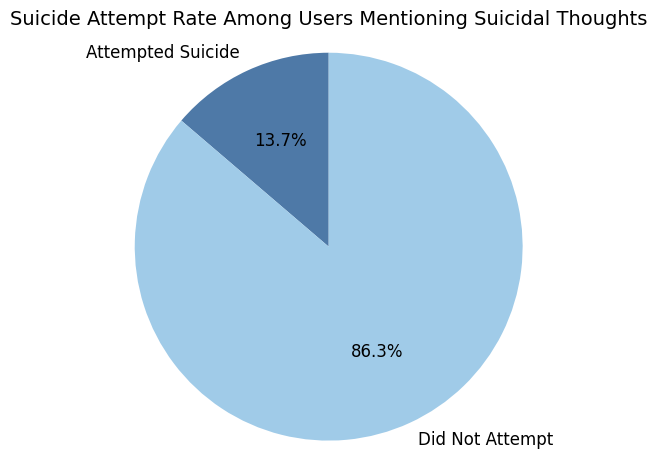

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your user-level DataFrame (already grouped by AuthorID)
#user = pd.read_csv("suicide_features_final_user_level.csv")  # or use existing `user` if already in memory

# Define the relevant column names
thoughts_col = 'SelfHarmOrSuicidalThoughtsMentioned'
attempt_col  = 'AttemptedSuicide'

# Filter users who ever mentioned suicidal thoughts
thoughts_users = user[user[thoughts_col].fillna(0) == 1]

# Count users and calculate attempts
total_thoughts  = len(thoughts_users)
attempted_count = len(thoughts_users[thoughts_users[attempt_col].fillna(0) == 1])
not_attempted_count = total_thoughts - attempted_count
attempt_rate = attempted_count / total_thoughts * 100 if total_thoughts else 0

# Print numerical summary
print(f"Users mentioning suicidal thoughts: {total_thoughts}")
print(f"Users who attempted suicide:        {attempted_count}")
print(f"Attempt rate:                       {attempt_rate:.2f}%")

# Define pie chart components
labels = ['Attempted Suicide', 'Did Not Attempt']
sizes = [attempted_count, not_attempted_count]
colors = ['#4E79A7', '#A0CBE8']  # Professional blue palette

# Plot pie chart
fig, ax = plt.subplots()
ax.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    colors=colors,
    startangle=90,
    textprops={'fontsize': 12}
)
ax.axis('equal')  # Keep pie circular
plt.title('Suicide Attempt Rate Among Users Mentioning Suicidal Thoughts', fontsize=14)
plt.tight_layout()
plt.show()


Users who mentioned suicidal/NSSI thoughts: 78515
Of those, users who mentioned a preparatory plan: 14946
Plan rate: 19.04%


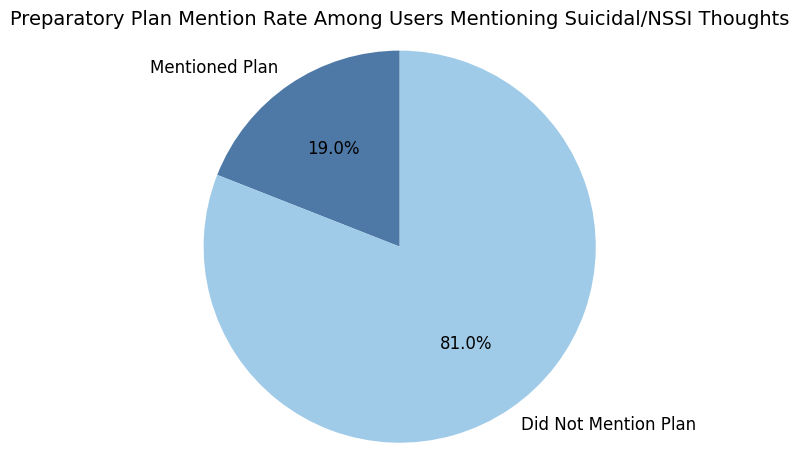

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load user-level dataset
# user = pd.read_csv("suicide_features_final_user_level.csv")  # Uncomment if loading from file

# 1) Define column names
thoughts_col = 'SelfHarmOrSuicidalThoughtsMentioned'
plan_col     = 'PreparatoryPlanMentioned'

# 2) Ensure these columns are in binary 0/1 format
for c in [thoughts_col, plan_col]:
    user[c] = pd.to_numeric(user[c], errors='coerce').fillna(0).astype(int)

# 3) Filter users who mentioned suicidal or NSSI thoughts
df = user[user[thoughts_col] == 1]

# 4) Count those who mentioned a preparatory plan
n_with_plan = df[plan_col].sum()
total_thoughts = len(df)
n_without_plan = total_thoughts - n_with_plan
plan_rate = (n_with_plan / total_thoughts) * 100 if total_thoughts else 0

# 5) Print results
print(f"Users who mentioned suicidal/NSSI thoughts: {total_thoughts}")
print(f"Of those, users who mentioned a preparatory plan: {n_with_plan}")
print(f"Plan rate: {plan_rate:.2f}%")

# 6) Pie chart setup
labels = ['Mentioned Plan', 'Did Not Mention Plan']
sizes = [n_with_plan, n_without_plan]
colors = ['#4E79A7', '#A0CBE8']  # Professional blue color palette

# 7) Plot pie chart
fig, ax = plt.subplots()
ax.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    colors=colors,
    startangle=90,
    textprops={'fontsize': 12}
)
ax.axis('equal')
plt.title('Preparatory Plan Mention Rate Among Users Mentioning Suicidal/NSSI Thoughts', fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# 1) Define your column names
attempt_col = 'AttemptedSuicide'
plan_col    = 'PreparatoryPlanMentioned'  # replace with the actual column name for plan

# 2) Ensure these columns are ints (0/1)
for c in [attempt_col, plan_col]:
    user[c] = pd.to_numeric(user[c], errors='coerce').fillna(0).astype(int)

# 3) Filter to users who actually attempted suicide
attempted = user[user[attempt_col] == 1]
total_attempted = len(attempted)

# 4) Count how many of those have a preparatory plan
plan_count    = attempted[attempted[plan_col] == 1].shape[0]
no_plan_count = attempted[attempted[plan_col] == 0].shape[0]

# 5) Print raw counts and rates
print(f"Users who attempted suicide:         {total_attempted}")
print(f"  - With preparatory plan:           {plan_count}")
print(f"  - Without preparatory plan:        {no_plan_count}")
print(f"  - Plan rate among attempters:      {plan_count/total_attempted*100:.1f}%\n")

# 6) Breakdown table
breakdown_df = pd.DataFrame({
    'Count': [
        plan_count,
        no_plan_count
    ],
    'Percentage (%)': [
        round(plan_count    / total_attempted * 100, 1),
        round(no_plan_count / total_attempted * 100, 1)
    ]
}, index=['Preparatory Plan', 'No Plan'])

print("=== Preparatory Plan Among Those Who Attempted ===")
print(breakdown_df)


Users who attempted suicide:         10907
  - With preparatory plan:           2986
  - Without preparatory plan:        7921
  - Plan rate among attempters:      27.4%

=== Preparatory Plan Among Those Who Attempted ===
                  Count  Percentage (%)
Preparatory Plan   2986            27.4
No Plan            7921            72.6


In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency, fisher_exact
import statsmodels.api as sm

# 1) Define your column names
thoughts_col = 'SelfHarmOrSuicidalThoughtsMentioned'   # users who ever mentioned suicidal/NSSI thoughts
attempt_col  = 'AttemptedSuicide'
plan_col     = 'PreparatoryPlanMentioned'

# 2) Ensure these columns are ints (0/1)
for c in [thoughts_col, attempt_col, plan_col]:
    user[c] = pd.to_numeric(user[c], errors='coerce').fillna(0).astype(int)

# 3) Restrict analysis to users who mentioned suicidal/NSSI thoughts
df = user[user[thoughts_col] == 1]
n_mentioned = len(df)
print(f"Users who ever mentioned suicidal/NSSI thoughts: {n_mentioned}\n")

# 4) Build a 2×2 contingency table among that subset: rows=planning (1/0), cols=attempt (1/0)
ct = pd.crosstab(df[plan_col], df[attempt_col])
ct.index = ['NoPlan (0)', 'Plan (1)']
ct.columns = ['NoAttempt (0)', 'Attempt (1)']
print("Contingency Table (among those with thoughts):\n", ct, "\n")

# 5) Chi-square test of independence
chi2, p_chi2, dof, expected = chi2_contingency(ct)
print(f"Chi-square test: χ² = {chi2:.3f}, dof = {dof}, p = {p_chi2:.4f}")
print("Expected counts:\n", pd.DataFrame(expected, index=ct.index, columns=ct.columns), "\n")

# 6) Fisher’s exact test (exact p-value & odds ratio)
a = ct.loc['Plan (1)',   'Attempt (1)']
b = ct.loc['Plan (1)',   'NoAttempt (0)']
c = ct.loc['NoPlan (0)', 'Attempt (1)']
d = ct.loc['NoPlan (0)', 'NoAttempt (0)']
odds_ratio, p_fisher = fisher_exact([[a, b], [c, d]])
print(f"Fisher’s exact test: OR = {odds_ratio:.3f}, p = {p_fisher:.4f}\n")

# 7) (Optional) Logistic regression of AttemptedSuicide ~ PreparatoryPlan among that subset
X = sm.add_constant(df[plan_col])
y = df[attempt_col]
logit = sm.Logit(y, X).fit(disp=False)
print("Logistic regression summary (among those with thoughts):\n", logit.summary())


Users who ever mentioned suicidal/NSSI thoughts: 78515

Contingency Table (among those with thoughts):
             NoAttempt (0)  Attempt (1)
NoPlan (0)          55764         7805
Plan (1)            11966         2980 

Chi-square test: χ² = 598.634, dof = 1, p = 0.0000
Expected counts:
             NoAttempt (0)  Attempt (1)
NoPlan (0)   54837.016748  8731.983252
Plan (1)     12892.983252  2053.016748 

Fisher’s exact test: OR = 1.779, p = 0.0000

Logistic regression summary (among those with thoughts):
                            Logit Regression Results                           
Dep. Variable:       AttemptedSuicide   No. Observations:                78515
Model:                          Logit   Df Residuals:                    78513
Method:                           MLE   Df Model:                            1
Date:                Wed, 07 May 2025   Pseudo R-squ.:                0.008797
Time:                        15:39:30   Log-Likelihood:                -31141.
converged:  

In [ ]:
import pandas as pd

# 0) Make sure the “thoughts” column is coded as 0/1
thoughts_col = 'SelfHarmOrSuicidalThoughtsMentioned'
user[thoughts_col] = (
    pd.to_numeric(user[thoughts_col], errors='coerce')
      .fillna(0)
      .astype(int)
)

# 1) Restrict to users who mentioned suicidal/NSSI thoughts
df = user[user[thoughts_col] == 1]

# 2) Total users in that subset
total_users = len(df)
print(f"Users who ever mentioned suicidal/NSSI thoughts: {total_users}\n")

# 3) Helper to build distribution tables, with “Unknown” always last
def distribution_table(df, col, unknown_label='Unknown'):
    # fill missing as Unknown
    series = df[col].fillna(unknown_label)

    # compute counts & percentages
    counts   = series.value_counts()
    percents = series.value_counts(normalize=True) * 100

    # assemble table
    table = pd.DataFrame({
        'Count': counts,
        'Percentage (%)': percents.round(2)
    })
    table.index.name = col

    # reorder so Unknown is last
    if unknown_label in table.index:
        ordered = [lbl for lbl in table.index if lbl != unknown_label] + [unknown_label]
        table = table.loc[ordered]
    return table

# 4) Compute distributions on that subset
gender_dist     = distribution_table(df, 'Gender')
agegroup_dist   = distribution_table(df, 'AgeGroup')
occupation_dist = distribution_table(df, 'OccupationStatus')

# 5) Display the tables
print("=== Gender Distribution (among those with thoughts) ===")
print(gender_dist, "\n")

print("=== Age Group Distribution (among those with thoughts) ===")
print(agegroup_dist, "\n")

print("=== Occupation Status Distribution (among those with thoughts) ===")
print(occupation_dist)


Users who ever mentioned suicidal/NSSI thoughts: 78515

=== Gender Distribution (among those with thoughts) ===
                Count  Percentage (%)
Gender                               
Male             6092            7.76
Female           5798            7.38
Gender Diverse   1768            2.25
Unknown         64857           82.60 

=== Age Group Distribution (among those with thoughts) ===
            Count  Percentage (%)
AgeGroup                         
YoungAdult  13434           17.11
Adolescent   7515            9.57
Adult        3920            4.99
Senior        173            0.22
Unknown     53473           68.11 

=== Occupation Status Distribution (among those with thoughts) ===
                  Count  Percentage (%)
OccupationStatus                       
Unemployed         3341            4.26
Employed           3242            4.13
Student            2528            3.22
Retired              10            0.01
Unknown           69394           88.38


In [ ]:
import pandas as pd

# 1) Define your column names
thoughts_col = 'SelfHarmOrSuicidalThoughtsMentioned'
attempt_col  = 'AttemptedSuicide'
plan_col     = 'PreparatoryPlanMentioned'
gender_col   = 'Gender'

# 2) Ensure these columns are ints (0/1)
for c in [thoughts_col, attempt_col, plan_col]:
    user[c] = pd.to_numeric(user[c], errors='coerce').fillna(0).astype(int)

# 3) Restrict to users who mentioned suicidal/NSSI thoughts
df = user[user[thoughts_col] == 1]

# 4) Group by gender and compute:
#    - how many mentioned thoughts
#    - how many of those attempted
#    - how many of those planned
summary = df.groupby(gender_col).agg(
    MentionedThoughts = (gender_col, 'count'),
    Attempted         = (attempt_col,  'sum'),
    Planned           = (plan_col,     'sum')
)

# 5) Compute percentages out of those who mentioned thoughts
summary['PctAttempted'] = (summary['Attempted'] / summary['MentionedThoughts'] * 100).round(2)
summary['PctPlanned']   = (summary['Planned']   / summary['MentionedThoughts'] * 100).round(2)

# 6) Push 'Unknown' to the bottom if present
if 'Unknown' in summary.index:
    idx = [g for g in summary.index if g != 'Unknown'] + ['Unknown']
    summary = summary.loc[idx]

# 7) Print the final table
print("Out of users who mentioned suicidal/NSSI thoughts, by gender:")
print("  • MentionedThoughts: count of users with thoughts")
print("  • Attempted:          of those, count who attempted suicide")
print("  • Planned:            of those, count who mentioned a preparatory plan")
print("  • PctAttempted:       Attempted ÷ MentionedThoughts (%)")
print("  • PctPlanned:         Planned ÷ MentionedThoughts (%)\n")

print(summary.to_string())


Out of users who mentioned suicidal/NSSI thoughts, by gender:
  • MentionedThoughts: count of users with thoughts
  • Attempted:          of those, count who attempted suicide
  • Planned:            of those, count who mentioned a preparatory plan
  • PctAttempted:       Attempted ÷ MentionedThoughts (%)
  • PctPlanned:         Planned ÷ MentionedThoughts (%)

                MentionedThoughts  Attempted  Planned  PctAttempted  PctPlanned
Gender                                                                         
Female                       5798       1192     1337         20.56       23.06
Gender Diverse               1768        339      412         19.17       23.30
Male                         6092        937     1350         15.38       22.16
Unknown                     64857       8317    11847         12.82       18.27


In [ ]:
import pandas as pd

# 1) Define your column names
thoughts_col = 'SelfHarmOrSuicidalThoughtsMentioned'
plan_col     = 'PreparatoryPlanMentioned'
attempt_col  = 'AttemptedSuicide'
agegroup_col = 'AgeGroup'

# 2) Ensure these columns are ints (0/1)
for c in [thoughts_col, plan_col, attempt_col]:
    user[c] = (
        pd.to_numeric(user[c], errors='coerce')
          .fillna(0)
          .astype(int)
    )

# 3) Restrict to users who mentioned suicidal/NSSI thoughts
df = user[user[thoughts_col] == 1].copy()

# 4) Fill missing AgeGroup as "Unknown"
df[agegroup_col] = df[agegroup_col].fillna('Unknown')

# 5) Group by age group and compute:
#    • MentionedThoughts: count of users with thoughts
#    • Attempted:         of those, count who attempted suicide
#    • Planned:           of those, count who mentioned a preparatory plan
summary = df.groupby(agegroup_col).agg(
    MentionedThoughts = (agegroup_col, 'count'),
    Attempted         = (attempt_col,  'sum'),
    Planned           = (plan_col,     'sum')
)

# 6) Compute percentages out of those who mentioned thoughts
summary['PctAttempted'] = (summary['Attempted'] / summary['MentionedThoughts'] * 100).round(2)
summary['PctPlanned']   = (summary['Planned']   / summary['MentionedThoughts'] * 100).round(2)

# 7) Push 'Unknown' to the bottom if present
if 'Unknown' in summary.index:
    idx = [g for g in summary.index if g != 'Unknown'] + ['Unknown']
    summary = summary.loc[idx]

# 8) Print the final table
print("Attempt & Planning Distribution Among Users Who Mentioned Suicidal/NSSI Thoughts, by Age Group\n")
print("  • MentionedThoughts: count of users with thoughts in each age group")
print("  • Attempted:          of those, count who attempted suicide")
print("  • Planned:            of those, count who mentioned a preparatory plan")
print("  • PctAttempted:       Attempted ÷ MentionedThoughts (%)")
print("  • PctPlanned:         Planned ÷ MentionedThoughts (%)\n")
print(summary.to_string())


Attempt & Planning Distribution Among Users Who Mentioned Suicidal/NSSI Thoughts, by Age Group

  • MentionedThoughts: count of users with thoughts in each age group
  • Attempted:          of those, count who attempted suicide
  • Planned:            of those, count who mentioned a preparatory plan
  • PctAttempted:       Attempted ÷ MentionedThoughts (%)
  • PctPlanned:         Planned ÷ MentionedThoughts (%)

            MentionedThoughts  Attempted  Planned  PctAttempted  PctPlanned
AgeGroup                                                                   
Adolescent               7515       1506     1593         20.04       21.20
Adult                    3920        569      987         14.52       25.18
Senior                    173         28       46         16.18       26.59
YoungAdult              13434       2357     2823         17.55       21.01
Unknown                 53473       6325     9497         11.83       17.76


In [ ]:
import pandas as pd

# 1) Define your column names
thoughts_col    = 'SelfHarmOrSuicidalThoughtsMentioned'
attempt_col     = 'AttemptedSuicide'
aborted_col     = 'AbortedAttempt'
interrupted_col = 'InterruptedAttempt'

# 2) Ensure these columns are ints (0/1)
for c in [thoughts_col, attempt_col, aborted_col, interrupted_col]:
    user[c] = pd.to_numeric(user[c], errors='coerce').fillna(0).astype(int)

# 3) Restrict to users who mentioned suicidal/NSSI thoughts
df_thoughts = user[user[thoughts_col] == 1]

# 4) Further restrict to those who actually attempted suicide
attempted      = df_thoughts[df_thoughts[attempt_col] == 1]
total_attempts = len(attempted)

# 5) Count aborted vs. interrupted vs. unknown (neither flagged)
aborted_count     = attempted[aborted_col].sum()
interrupted_count = attempted[interrupted_col].sum()
unknown_count     = total_attempts - aborted_count - interrupted_count

# 6) Build a single breakdown table with counts and percentages
breakdown_df = pd.DataFrame({
    'Count': [
        aborted_count,
        interrupted_count,
        unknown_count
    ],
    'Percentage (%)': [
        round(aborted_count     / total_attempts * 100, 1),
        round(interrupted_count / total_attempts * 100, 1),
        round(unknown_count     / total_attempts * 100, 1),
    ]
}, index=['Aborted', 'Interrupted', 'Unknown'])

# 7) Print total attempts and the breakdown table
print(f"Total suicide attempts (among users who mentioned thoughts): {total_attempts}\n")
print("Attempt Types Among Those Who Attempted:\n")
print(breakdown_df.to_string())


Total suicide attempts (among users who mentioned thoughts): 10785

Attempt Types Among Those Who Attempted:

             Count  Percentage (%)
Aborted       1021             9.5
Interrupted    928             8.6
Unknown       8836            81.9


In [ ]:
import pandas as pd

# 1) Define your column names
thoughts_col    = 'SelfHarmOrSuicidalThoughtsMentioned'
attempt_col     = 'AttemptedSuicide'
aborted_col     = 'AbortedAttempt'
interrupted_col = 'InterruptedAttempt'
gender_col      = 'Gender'

# 2) Ensure these columns are ints (0/1)
for c in [thoughts_col, attempt_col, aborted_col, interrupted_col]:
    user[c] = pd.to_numeric(user[c], errors='coerce').fillna(0).astype(int)

# 3) Restrict to users who mentioned suicidal/NSSI thoughts, then those who attempted
df_thoughts = user[user[thoughts_col] == 1]
attempted   = df_thoughts[df_thoughts[attempt_col] == 1]

# 4) Group by gender and compute counts of each attempt type
summary = attempted.groupby(gender_col).agg(
    Attempts    = (attempt_col,     'count'),
    Aborted     = (aborted_col,     'sum'),
    Interrupted = (interrupted_col, 'sum')
)

# 5) Compute percentages for aborted and interrupted
summary['PctAborted']     = (summary['Aborted']     / summary['Attempts'] * 100).round(1)
summary['PctInterrupted'] = (summary['Interrupted'] / summary['Attempts'] * 100).round(1)

# 6) Push 'Unknown' gender to the bottom if present
if 'Unknown' in summary.index:
    idx = [g for g in summary.index if g != 'Unknown'] + ['Unknown']
    summary = summary.loc[idx]

# 7) Display the distribution table (without unknown attempt types)
print("Aborted vs Interrupted Attempt Distribution Across Genders\n")
print(summary.to_string())


Aborted vs Interrupted Attempt Distribution Across Genders

                Attempts  Aborted  Interrupted  PctAborted  PctInterrupted
Gender                                                                    
Female              1192      105          116         8.8             9.7
Gender Diverse       339       39           35        11.5            10.3
Male                 937      101           80        10.8             8.5
Unknown             8317      776          697         9.3             8.4


In [ ]:
import pandas as pd

# 1) Define your column names
thoughts_col    = 'SelfHarmOrSuicidalThoughtsMentioned'
attempt_col     = 'AttemptedSuicide'
aborted_col     = 'AbortedAttempt'
interrupted_col = 'InterruptedAttempt'
agegroup_col    = 'AgeGroup'

# 2) Ensure these columns are ints (0/1)
for c in [thoughts_col, attempt_col, aborted_col, interrupted_col]:
    user[c] = pd.to_numeric(user[c], errors='coerce').fillna(0).astype(int)

# 3) Restrict to users who mentioned suicidal/NSSI thoughts, then those who attempted
df_thoughts = user[user[thoughts_col] == 1]
attempted   = df_thoughts[df_thoughts[attempt_col] == 1].copy()

# 4) Fill missing AgeGroup as "Unknown"
attempted[agegroup_col] = attempted[agegroup_col].fillna('Unknown')

# 5) Group by age group and compute counts of each attempt type
summary = attempted.groupby(agegroup_col).agg(
    Attempts    = (attempt_col,     'count'),
    Aborted     = (aborted_col,     'sum'),
    Interrupted = (interrupted_col, 'sum')
)

# 6) Compute percentages for aborted and interrupted
summary['PctAborted']     = (summary['Aborted']     / summary['Attempts'] * 100).round(1)
summary['PctInterrupted'] = (summary['Interrupted'] / summary['Attempts'] * 100).round(1)

# 7) Push 'Unknown' age group to the bottom if present
if 'Unknown' in summary.index:
    idx = [g for g in summary.index if g != 'Unknown'] + ['Unknown']
    summary = summary.loc[idx]

# 8) Display the distribution table (without unknown attempt types)
print("Aborted vs Interrupted Attempt Distribution Across Age Groups\n")
print(summary.to_string())


Aborted vs Interrupted Attempt Distribution Across Age Groups

            Attempts  Aborted  Interrupted  PctAborted  PctInterrupted
AgeGroup                                                              
Adolescent      1506      161          105        10.7             7.0
Adult            569       54           43         9.5             7.6
Senior            28        2            2         7.1             7.1
YoungAdult      2357      221          190         9.4             8.1
Unknown         6325      583          588         9.2             9.3


Users with suicidal/NSSI thoughts:                   78515
Users (of those) who mentioned ≥1 valid method:      30335
Total valid method mentions (sum of all valid flags):44438

=== Top 10 Suicide/NSSI Methods by Mentions (excluding 'None') ===
                                         Count  PctOfAllMentions (%)
SuicidalOrNSSIMethods_Overdose            9966                  22.4
SuicidalOrNSSIMethods_Cutting             9119                  20.5
SuicidalOrNSSIMethods_Hanging             4555                  10.3
SuicidalOrNSSIMethods_Firearm             4432                  10.0
SuicidalOrNSSIMethods_Jumping             3594                   8.1
SuicidalOrNSSIMethods_Vehicle Collision   2028                   4.6
SuicidalOrNSSIMethods_Others              1746                   3.9
SuicidalOrNSSIMethods_Poisoning           1505                   3.4
SuicidalOrNSSIMethods_Alcohol             1412                   3.2
SuicidalOrNSSIMethods_Drug_Use            1141                   

<ipython-input-22-1321760cdf4d>:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab20')


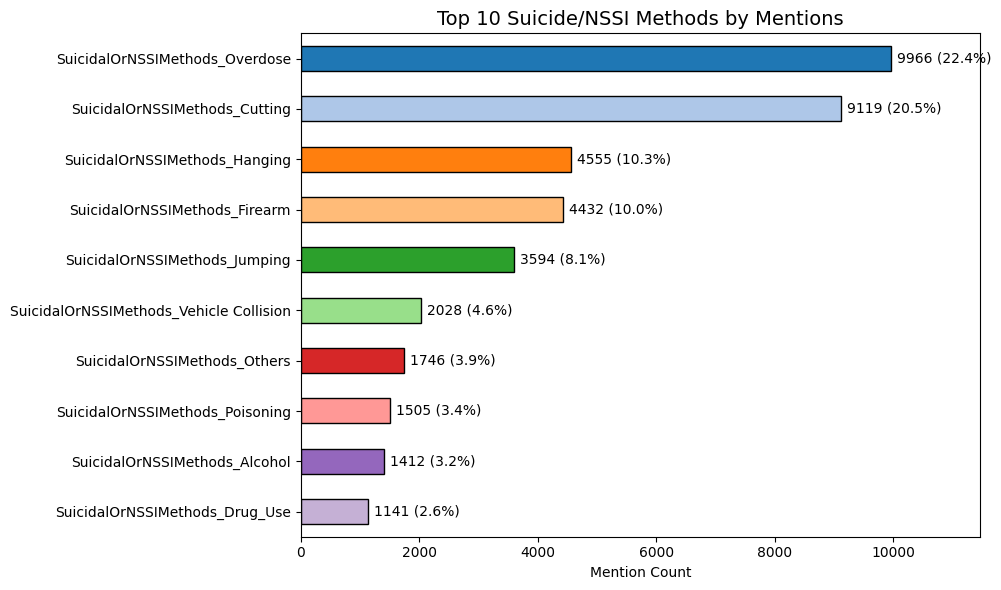

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# STEP 1 — Ensure method columns are integer
method_cols = [c for c in user.columns if c.startswith("SuicidalOrNSSIMethods_")]
for c in method_cols:
    user[c] = pd.to_numeric(user[c], errors="coerce").fillna(0).astype(int)

# STEP 2 — Exclude “None” method
valid_methods = [c for c in method_cols if not c.endswith('_None')]

# STEP 3 — Filter users who mentioned suicidal/NSSI thoughts
thoughts_col = 'SelfHarmOrSuicidalThoughtsMentioned'
user[thoughts_col] = pd.to_numeric(user[thoughts_col], errors="coerce").fillna(0).astype(int)
df_thoughts = user[user[thoughts_col] == 1]

# STEP 4 — Count users who mentioned ≥1 valid method
methods_per_user = df_thoughts[valid_methods].sum(axis=1)
method_users = df_thoughts[methods_per_user > 0]
num_method_users = len(method_users)

# STEP 5 — Total valid method mentions
method_counts = df_thoughts[valid_methods].sum()
total_method_mentions = int(method_counts.sum())

# STEP 6 — Top 10 methods
top10 = method_counts.sort_values(ascending=False).head(10)
pct10 = (top10 / total_method_mentions * 100).round(1)

top10_df = pd.DataFrame({
    'Count': top10.astype(int),
    'PctOfAllMentions (%)': pct10
})

# Output summary
print(f"Users with suicidal/NSSI thoughts:                   {len(df_thoughts)}")
print(f"Users (of those) who mentioned ≥1 valid method:      {num_method_users}")
print(f"Total valid method mentions (sum of all valid flags):{total_method_mentions}\n")

print("=== Top 10 Suicide/NSSI Methods by Mentions (excluding 'None') ===")
print(top10_df.to_string())

# STEP 7 — Plot horizontal bar chart
def plot_top_methods(df):
    cmap = get_cmap('tab20')
    colors = [cmap(i) for i in range(len(df))]

    fig, ax = plt.subplots(figsize=(10, 6))
    df['Count'].plot(kind='barh', ax=ax, color=colors, edgecolor='black')

    max_val = df['Count'].max()
    for i, (count, pct) in enumerate(zip(df['Count'], df['PctOfAllMentions (%)'])):
        ax.text(count + max_val * 0.01, i, f'{count} ({pct}%)', va='center', fontsize=10)

    ax.set_xlim(0, max_val * 1.15)  # Ensure all labels stay inside
    ax.set_title('Top 10 Suicide/NSSI Methods by Mentions', fontsize=14)
    ax.set_xlabel('Mention Count')
    ax.invert_yaxis()  # Highest count on top
    plt.tight_layout()
    plt.show()

# Run chart
plot_top_methods(top10_df)



--- Male (n=6092) ---
Total method mentions among this gender: 3918

                                Count  PctOfGenderMethodMentions (%)
SuicidalOrNSSIMethods_Cutting     722                           18.4
SuicidalOrNSSIMethods_Overdose    670                           17.1
SuicidalOrNSSIMethods_Firearm     557                           14.2
SuicidalOrNSSIMethods_Hanging     456                           11.6
SuicidalOrNSSIMethods_Jumping     330                            8.4


<ipython-input-23-1bd0b4445608>:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab20')


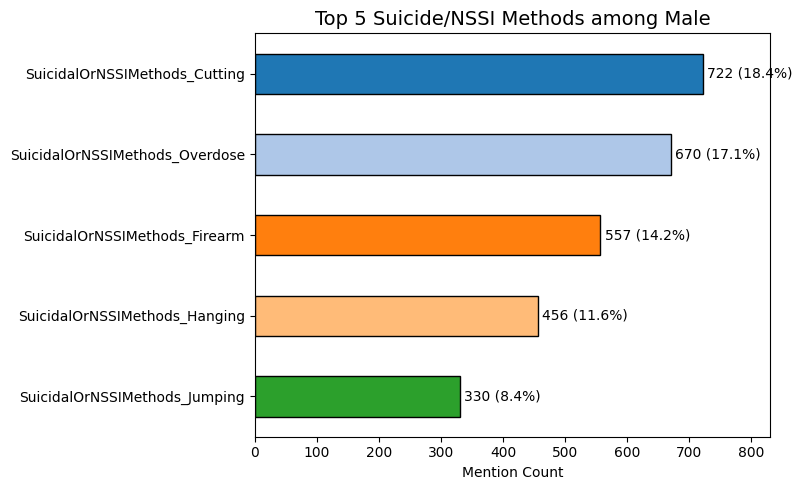


--- Female (n=5798) ---
Total method mentions among this gender: 4086

                                Count  PctOfGenderMethodMentions (%)
SuicidalOrNSSIMethods_Overdose   1080                           26.4
SuicidalOrNSSIMethods_Cutting     974                           23.8
SuicidalOrNSSIMethods_Hanging     389                            9.5
SuicidalOrNSSIMethods_Jumping     301                            7.4
SuicidalOrNSSIMethods_Firearm     255                            6.2


<ipython-input-23-1bd0b4445608>:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab20')


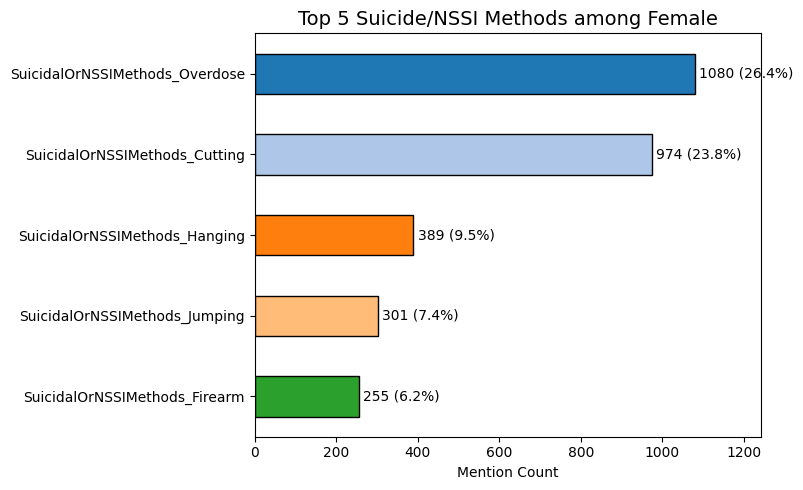


--- Gender Diverse (n=1768) ---
Total method mentions among this gender: 1333

                                Count  PctOfGenderMethodMentions (%)
SuicidalOrNSSIMethods_Cutting     352                           26.4
SuicidalOrNSSIMethods_Overdose    274                           20.6
SuicidalOrNSSIMethods_Hanging     128                            9.6
SuicidalOrNSSIMethods_Jumping     123                            9.2
SuicidalOrNSSIMethods_Firearm     104                            7.8


<ipython-input-23-1bd0b4445608>:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab20')


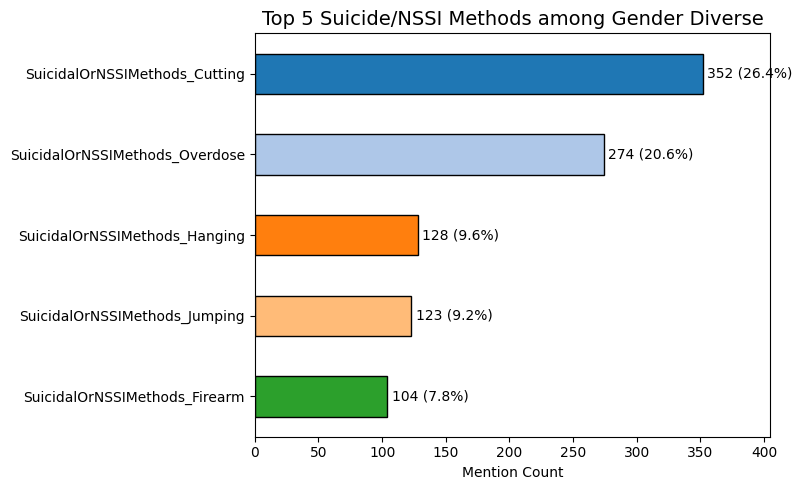


--- Unknown (n=64857) ---
Total method mentions among this gender: 35101

                                Count  PctOfGenderMethodMentions (%)
SuicidalOrNSSIMethods_Overdose   7942                           22.6
SuicidalOrNSSIMethods_Cutting    7071                           20.1
SuicidalOrNSSIMethods_Hanging    3582                           10.2
SuicidalOrNSSIMethods_Firearm    3516                           10.0
SuicidalOrNSSIMethods_Jumping    2840                            8.1


<ipython-input-23-1bd0b4445608>:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab20')


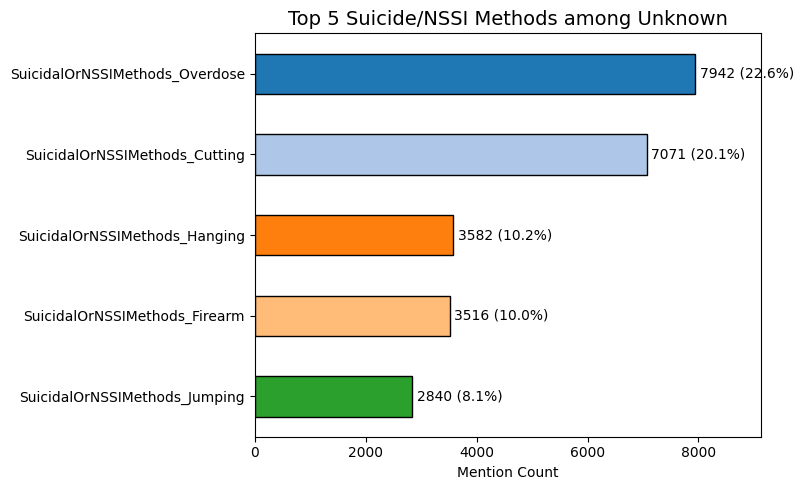

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# 1) Identify and prepare your columns
thoughts_col = 'SelfHarmOrSuicidalThoughtsMentioned'
gender_col   = 'Gender'
method_cols  = [c for c in user.columns if c.startswith("SuicidalOrNSSIMethods_")]

# 2) Exclude the “None” column from method analysis
valid_methods = [c for c in method_cols if not c.endswith('_None')]

# 3) Ensure binary columns are ints (0/1)
for c in [thoughts_col] + valid_methods:
    user[c] = pd.to_numeric(user[c], errors='coerce').fillna(0).astype(int)

# 4) Restrict to users who mentioned suicidal/NSSI thoughts
df = user[user[thoughts_col] == 1].copy()

# 5) Fill missing genders as “Unknown”
df[gender_col] = df[gender_col].fillna('Unknown')

# 6) Plotting function
def plot_top5_methods_by_gender(gender_df, gender_name):
    counts = gender_df[valid_methods].sum()
    total_mentions = int(counts.sum())
    top5 = counts.sort_values(ascending=False).head(5)
    pct5 = (top5 / total_mentions * 100).round(1)

    top5_df = pd.DataFrame({
        'Count': top5.astype(int),
        'PctOfGenderMethodMentions (%)': pct5
    })

    # Print summary
    print(f"\n--- {gender_name} (n={len(gender_df)}) ---")
    print(f"Total method mentions among this gender: {total_mentions}\n")
    print(top5_df.to_string())

    # Plot
    cmap = get_cmap('tab20')
    colors = [cmap(i) for i in range(len(top5_df))]

    fig, ax = plt.subplots(figsize=(8, 5))
    top5_df['Count'].plot(kind='barh', ax=ax, color=colors, edgecolor='black')

    max_val = top5_df['Count'].max()
    for i, (count, pct) in enumerate(zip(top5_df['Count'], top5_df['PctOfGenderMethodMentions (%)'])):
        ax.text(count + max_val * 0.01, i, f'{count} ({pct}%)', va='center', fontsize=10)

    ax.set_xlim(0, max_val * 1.15)
    ax.set_title(f'Top 5 Suicide/NSSI Methods among {gender_name}', fontsize=14)
    ax.set_xlabel('Mention Count')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

# 7) Generate visualizations per gender
gender_order = [g for g in df[gender_col].value_counts().index if g != 'Unknown']
if 'Unknown' in df[gender_col].unique():
    gender_order.append('Unknown')

for gender in gender_order:
    sub_df = df[df[gender_col] == gender]
    plot_top5_methods_by_gender(sub_df, gender)


Users by AgeGroup:
            UserCount
AgeGroup             
Unknown         58841
YoungAdult      13885
Adolescent       7771
Adult            4117
Senior            184

--- Unknown (n=58841) ---
                                UserCount  PctOAgeGroup
SuicidalOrNSSIMethods_Overdose       6516          11.1
SuicidalOrNSSIMethods_Cutting        5562           9.5
SuicidalOrNSSIMethods_Hanging        2902           4.9
SuicidalOrNSSIMethods_Firearm        2830           4.8
SuicidalOrNSSIMethods_Jumping        2338           4.0


<ipython-input-25-fa71b3f27073>:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab20')


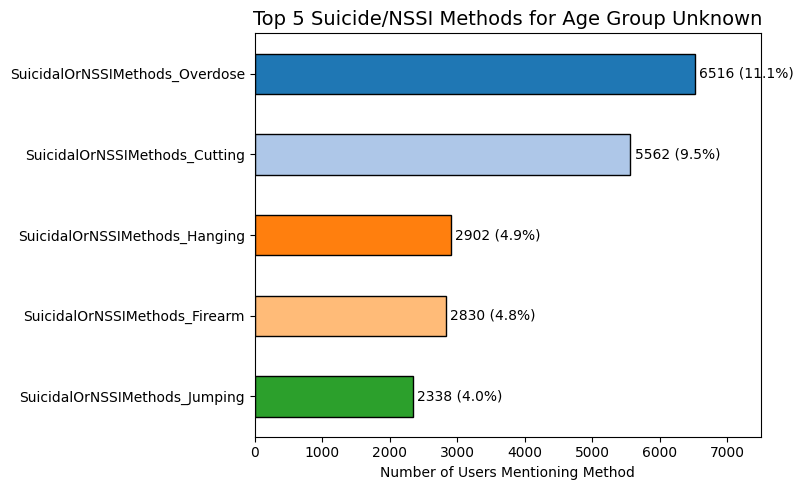


--- YoungAdult (n=13885) ---
                                UserCount  PctOAgeGroup
SuicidalOrNSSIMethods_Overdose       1790          12.9
SuicidalOrNSSIMethods_Cutting        1612          11.6
SuicidalOrNSSIMethods_Firearm         920           6.6
SuicidalOrNSSIMethods_Hanging         861           6.2
SuicidalOrNSSIMethods_Jumping         668           4.8


<ipython-input-25-fa71b3f27073>:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab20')


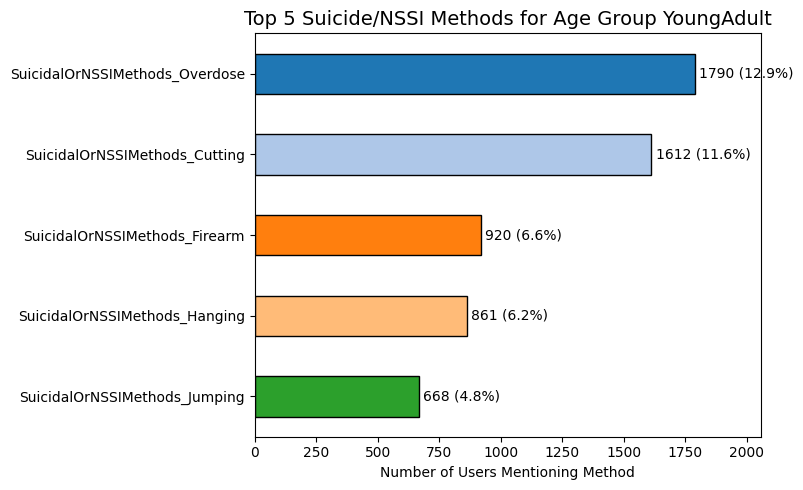


--- Adolescent (n=7771) ---
                                UserCount  PctOAgeGroup
SuicidalOrNSSIMethods_Cutting        1719          22.1
SuicidalOrNSSIMethods_Overdose       1355          17.4
SuicidalOrNSSIMethods_Hanging         603           7.8
SuicidalOrNSSIMethods_Jumping         459           5.9
SuicidalOrNSSIMethods_Firearm         410           5.3


<ipython-input-25-fa71b3f27073>:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab20')


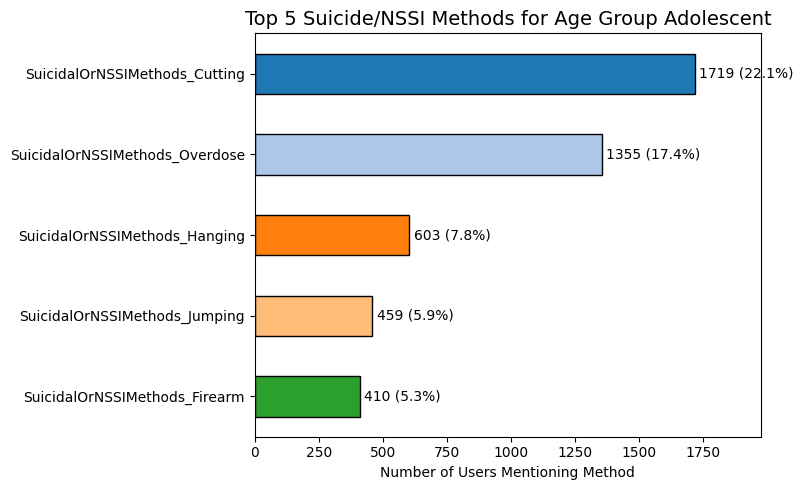


--- Adult (n=4117) ---
                                UserCount  PctOAgeGroup
SuicidalOrNSSIMethods_Overdose        417          10.1
SuicidalOrNSSIMethods_Firearm         302           7.3
SuicidalOrNSSIMethods_Cutting         256           6.2
SuicidalOrNSSIMethods_Hanging         247           6.0
SuicidalOrNSSIMethods_Jumping         156           3.8


<ipython-input-25-fa71b3f27073>:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab20')


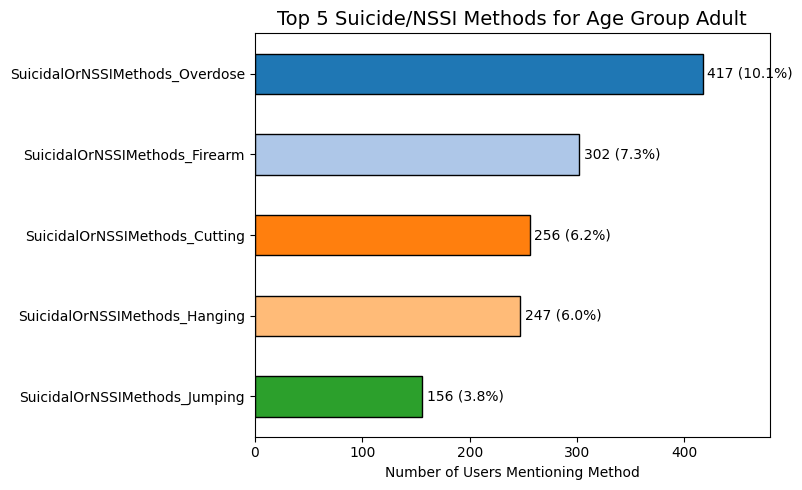


--- Senior (n=184) ---
                                UserCount  PctOAgeGroup
SuicidalOrNSSIMethods_Overdose         19          10.3
SuicidalOrNSSIMethods_Firearm          13           7.1
SuicidalOrNSSIMethods_Hanging          10           5.4
SuicidalOrNSSIMethods_Cutting          10           5.4
SuicidalOrNSSIMethods_Others            5           2.7


<ipython-input-25-fa71b3f27073>:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab20')


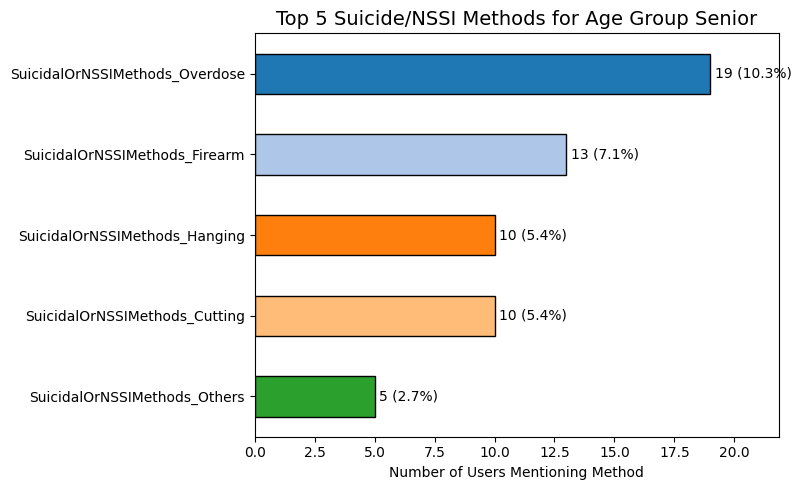

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# 1) Identify method columns and convert to integers
method_cols = [c for c in user.columns if c.startswith("SuicidalOrNSSIMethods_")]
for c in method_cols:
    user[c] = pd.to_numeric(user[c], errors="coerce").fillna(0).astype(int)

# 2) Exclude "_None" from method analysis
valid_methods = [m for m in method_cols if not m.endswith("_None")]

# 3) Count users by AgeGroup
agegroup_counts = user["AgeGroup"].fillna("Unknown").value_counts()
print("Users by AgeGroup:")
print(agegroup_counts.to_frame(name="UserCount"))

# 4) Function to compute and plot top 5 methods for an age group
def plot_top5_methods_by_agegroup(agegroup, df):
    n_users = len(df)

    top5 = df[valid_methods].sum().sort_values(ascending=False).head(5)
    pct5 = (top5 / n_users * 100).round(1)

    dist_df = pd.DataFrame({
        "UserCount": top5.astype(int),
        "PctOAgeGroup": pct5
    })

    # Print summary
    print(f"\n--- {agegroup} (n={n_users}) ---")
    print(dist_df)

    # Plot
    cmap = get_cmap('tab20')
    colors = [cmap(i) for i in range(len(dist_df))]

    fig, ax = plt.subplots(figsize=(8, 5))
    dist_df['UserCount'].plot(kind='barh', ax=ax, color=colors, edgecolor='black')

    max_val = dist_df['UserCount'].max()
    for i, (count, pct) in enumerate(zip(dist_df['UserCount'], dist_df['PctOAgeGroup'])):
        ax.text(count + max_val * 0.01, i, f'{count} ({pct}%)', va='center', fontsize=10)

    ax.set_xlim(0, max_val * 1.15)
    ax.set_title(f'Top 5 Suicide/NSSI Methods for Age Group {agegroup}', fontsize=14)
    ax.set_xlabel('Number of Users Mentioning Method')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

# 5) Loop through each age group
for agegroup, _ in agegroup_counts.items():
    sub_df = user[user["AgeGroup"].fillna("Unknown") == agegroup]
    plot_top5_methods_by_agegroup(agegroup, sub_df)


Users with suicidal/NSSI thoughts: 78515
Of those, users who mentioned ≥1 reason: 62272

Total reason mentions (all reasons sum): 129971

=== Top 10 Reasons Behind Suicide/NSSI ===
                                                  Count  PctOfAllReasons (%)
ReasonBehindSuicideNSSI_Family and Friend Issues  23069                 17.7
ReasonBehindSuicideNSSI_Emotional_pain            21555                 16.6
ReasonBehindSuicideNSSI_Mental Health             19206                 14.8
ReasonBehindSuicideNSSI_Relationship Issues       15490                 11.9
ReasonBehindSuicideNSSI_Existential_crisis        10796                  8.3
ReasonBehindSuicideNSSI_Financial Hardship         7781                  6.0
ReasonBehindSuicideNSSI_Abusing                    7327                  5.6
ReasonBehindSuicideNSSI_Occupational Stress        5802                  4.5
ReasonBehindSuicideNSSI_Academic Pressure          4430                  3.4
ReasonBehindSuicideNSSI_Body Dysmorphia          

<ipython-input-27-cc85f3647be7>:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab20')


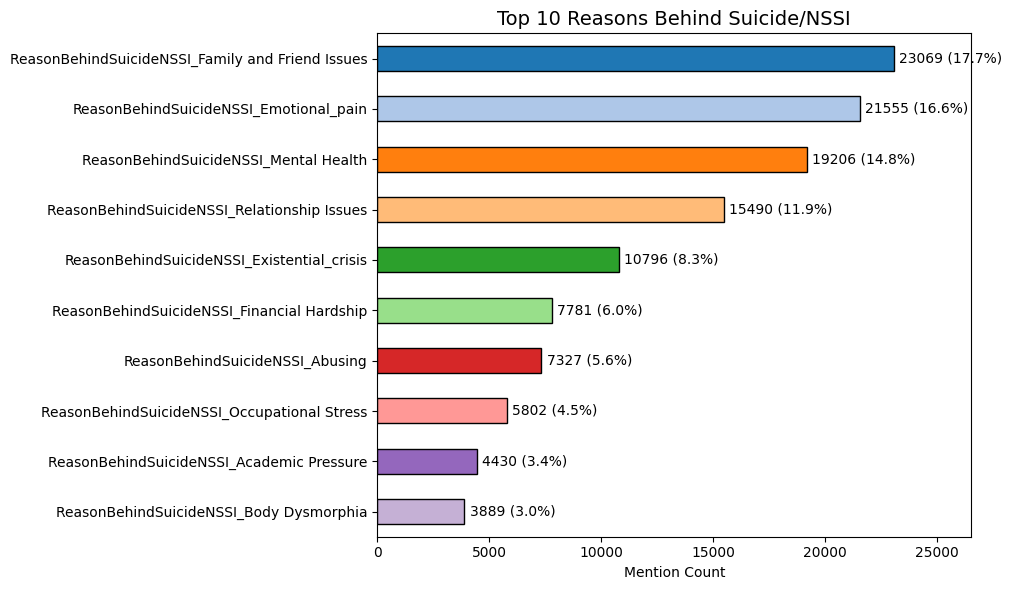

--- Male (n=6092) Top 5 Reasons ---
Total reason mentions: 13332
                                                  Count  PctOfGenderReasons (%)
ReasonBehindSuicideNSSI_Family and Friend Issues   2108                    15.8
ReasonBehindSuicideNSSI_Relationship Issues        2040                    15.3
ReasonBehindSuicideNSSI_Emotional_pain             1867                    14.0
ReasonBehindSuicideNSSI_Mental Health              1850                    13.9
ReasonBehindSuicideNSSI_Financial Hardship          903                     6.8 

--- Female (n=5798) Top 5 Reasons ---
Total reason mentions: 13236
                                                  Count  PctOfGenderReasons (%)
ReasonBehindSuicideNSSI_Family and Friend Issues   2295                    17.3
ReasonBehindSuicideNSSI_Emotional_pain             2167                    16.4
ReasonBehindSuicideNSSI_Mental Health              2121                    16.0
ReasonBehindSuicideNSSI_Relationship Issues        1710           

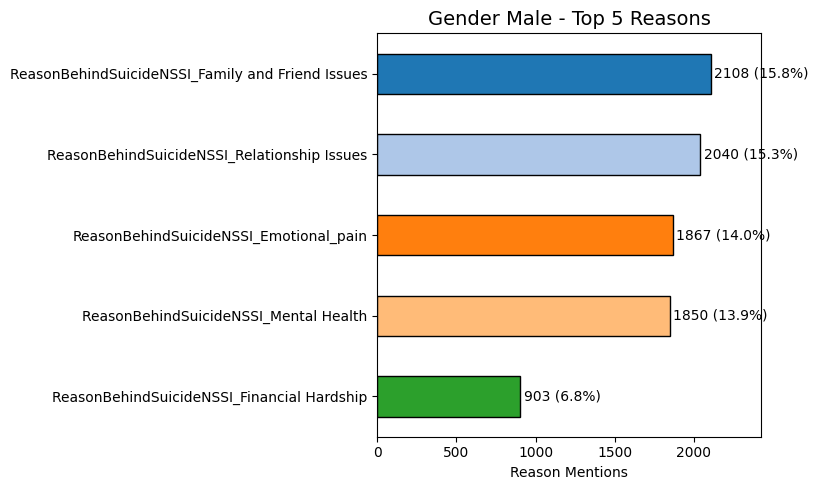

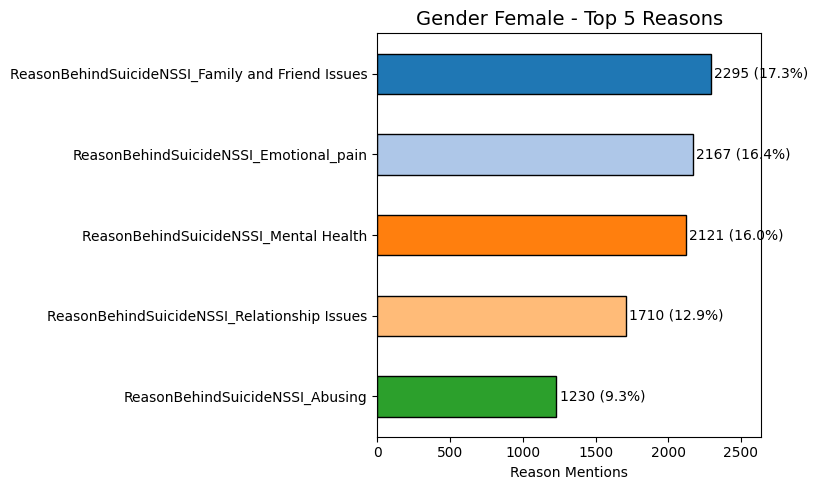

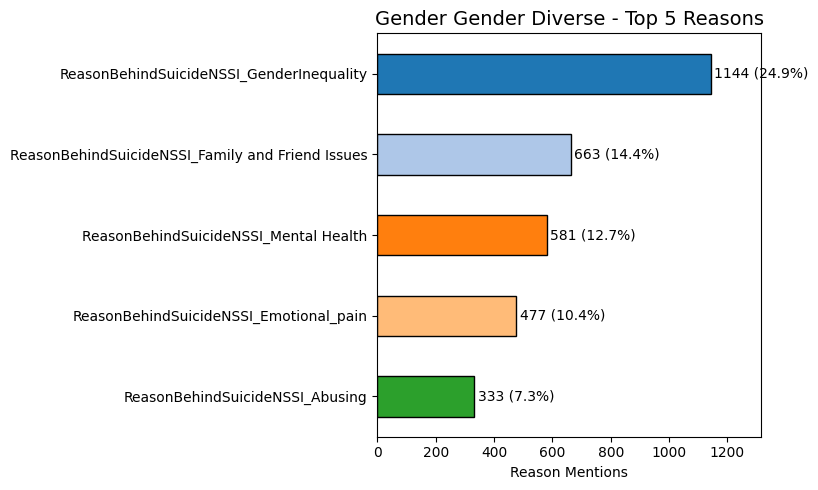

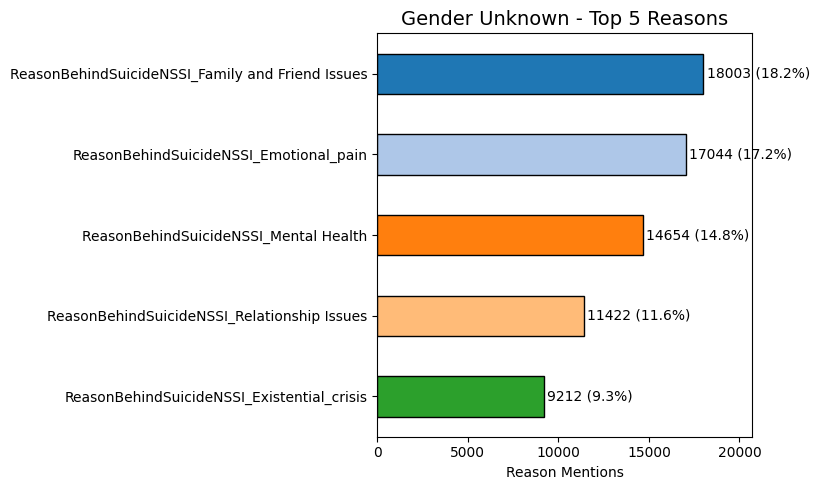

--- Age YoungAdult (n=13434) Top 5 Reasons ---
Total reason mentions: 30233
                                                  Count  PctOfAgeReasons (%)
ReasonBehindSuicideNSSI_Mental Health              4955                 16.4
ReasonBehindSuicideNSSI_Family and Friend Issues   4903                 16.2
ReasonBehindSuicideNSSI_Emotional_pain             4401                 14.6
ReasonBehindSuicideNSSI_Relationship Issues        3546                 11.7
ReasonBehindSuicideNSSI_Financial Hardship         2298                  7.6 

--- Age Adolescent (n=7515) Top 5 Reasons ---
Total reason mentions: 15005
                                                  Count  PctOfAgeReasons (%)
ReasonBehindSuicideNSSI_Family and Friend Issues   3556                 23.7
ReasonBehindSuicideNSSI_Mental Health              2137                 14.2
ReasonBehindSuicideNSSI_Emotional_pain             2100                 14.0
ReasonBehindSuicideNSSI_Abusing                    1323                  8.8


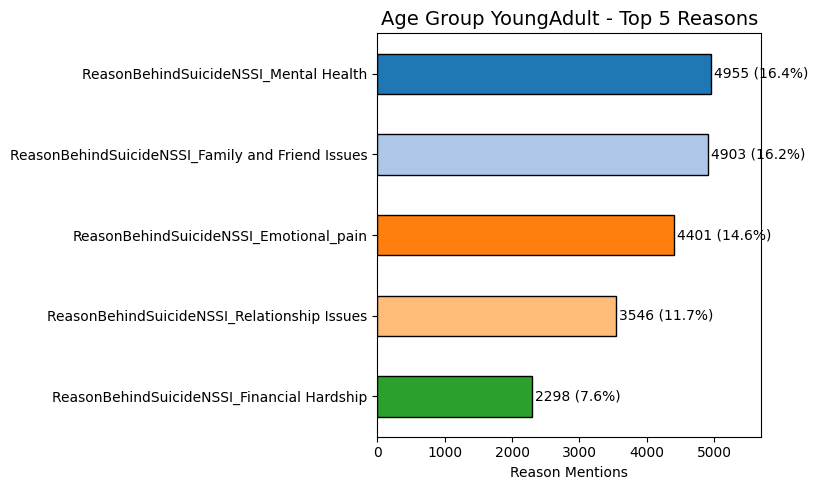

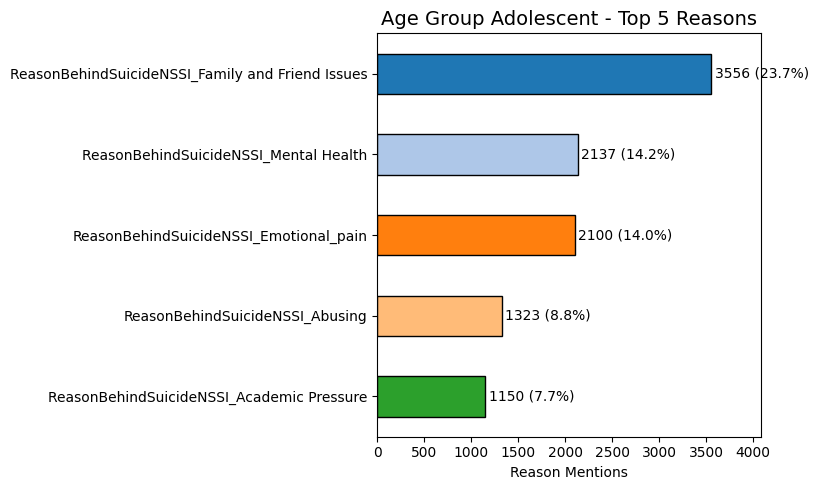

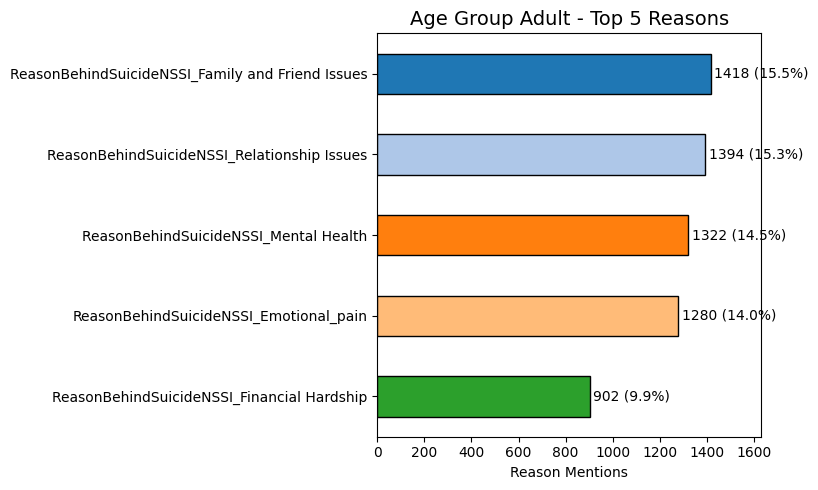

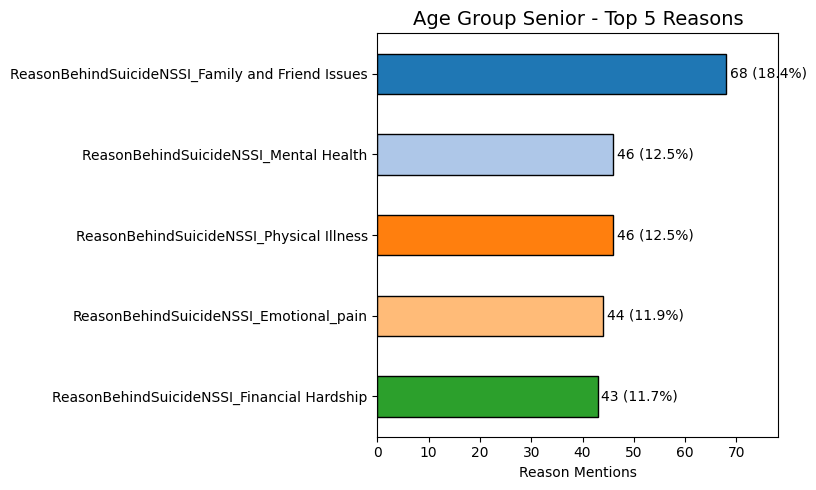

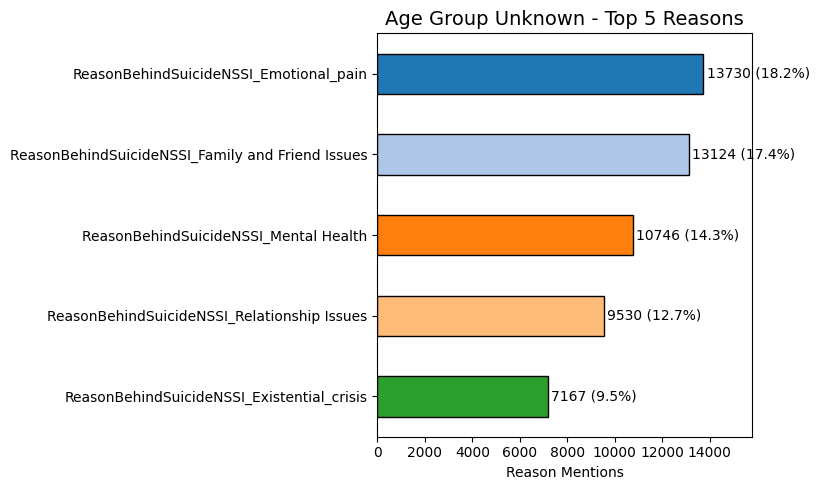

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# 1) Define columns
thoughts_col = 'SelfHarmOrSuicidalThoughtsMentioned'
reason_cols  = [c for c in user.columns if c.startswith("ReasonBehindSuicideNSSI_")]
gender_col   = 'Gender'
agegroup_col = 'AgeGroup'

# 2) Exclude “_None” reason columns
valid_reasons = [c for c in reason_cols if not c.endswith('_None')]

# 3) Ensure binary columns are integers (0/1)
for c in [thoughts_col] + valid_reasons:
    user[c] = pd.to_numeric(user[c], errors='coerce').fillna(0).astype(int)

# 4) Filter to users who mentioned suicidal/NSSI thoughts
df = user[user[thoughts_col] == 1].copy()
total_thoughts = len(df)

# 5) Count how many mentioned at least one reason
reason_counts_per_user = df[valid_reasons].sum(axis=1)
num_users_with_reason = (reason_counts_per_user > 0).sum()

print(f"Users with suicidal/NSSI thoughts: {total_thoughts}")
print(f"Of those, users who mentioned ≥1 reason: {num_users_with_reason}\n")

# 6) Total reason mentions
reason_totals = df[valid_reasons].sum()
total_reason_mentions = int(reason_totals.sum())

print(f"Total reason mentions (all reasons sum): {total_reason_mentions}\n")

# 7) Top 10 reasons overall
top10 = reason_totals.sort_values(ascending=False).head(10)
pct10 = (top10 / total_reason_mentions * 100).round(1)
top10_df = pd.DataFrame({
    'Count': top10.astype(int),
    'PctOfAllReasons (%)': pct10
})
print("=== Top 10 Reasons Behind Suicide/NSSI ===")
print(top10_df.to_string(), "\n")

# ✅ Plot for Top 10 Reasons
cmap = get_cmap('tab20')
colors = [cmap(i) for i in range(len(top10_df))]

fig, ax = plt.subplots(figsize=(10, 6))
top10_df['Count'].plot(kind='barh', ax=ax, color=colors, edgecolor='black')

max_val = top10_df['Count'].max()
for i, (count, pct) in enumerate(zip(top10_df['Count'], top10_df['PctOfAllReasons (%)'])):
    ax.text(count + max_val * 0.01, i, f'{count} ({pct}%)', va='center', fontsize=10)

ax.set_xlim(0, max_val * 1.15)
ax.set_title('Top 10 Reasons Behind Suicide/NSSI', fontsize=14)
ax.set_xlabel('Mention Count')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

# 📊 Reusable plot function for gender and age group
def plot_reason_distributions(reason_data, title_prefix, value_col, percent_col):
    for label, df in reason_data.items():
        colors = [cmap(i) for i in range(len(df))]
        fig, ax = plt.subplots(figsize=(8, 5))
        df[value_col].plot(kind='barh', ax=ax, color=colors, edgecolor='black')

        max_val = df[value_col].max()
        for i, (count, pct) in enumerate(zip(df[value_col], df[percent_col])):
            ax.text(count + max_val * 0.01, i, f'{count} ({pct}%)', va='center', fontsize=10)

        ax.set_xlim(0, max_val * 1.15)
        ax.set_title(f'{title_prefix} {label} - Top 5 Reasons', fontsize=14)
        ax.set_xlabel('Reason Mentions')
        ax.invert_yaxis()
        plt.tight_layout()
        plt.show()

# 8) Gender-wise reason distribution
df[gender_col] = df[gender_col].fillna('Unknown')
gender_order = [g for g in df[gender_col].value_counts().index if g != 'Unknown']
if 'Unknown' in df[gender_col].unique():
    gender_order.append('Unknown')

gender_reason_data = {}
for gender in gender_order:
    sub = df[df[gender_col] == gender]
    counts = sub[valid_reasons].sum()
    total = counts.sum()
    top5 = counts.sort_values(ascending=False).head(5)
    pct5 = (top5 / total * 100).round(1)
    gender_reason_data[gender] = pd.DataFrame({
        'Count': top5.astype(int),
        'PctOfGenderReasons (%)': pct5
    })
    print(f"--- {gender} (n={len(sub)}) Top 5 Reasons ---")
    print(f"Total reason mentions: {int(total)}")
    print(gender_reason_data[gender].to_string(), "\n")

plot_reason_distributions(
    reason_data=gender_reason_data,
    title_prefix='Gender',
    value_col='Count',
    percent_col='PctOfGenderReasons (%)'
)

# 9) Age group-wise reason distribution
df[agegroup_col] = df[agegroup_col].fillna('Unknown')
age_order = [a for a in df[agegroup_col].value_counts().index if a != 'Unknown']
if 'Unknown' in df[agegroup_col].unique():
    age_order.append('Unknown')

age_reason_data = {}
for age in age_order:
    sub = df[df[agegroup_col] == age]
    counts = sub[valid_reasons].sum()
    total = counts.sum()
    top5 = counts.sort_values(ascending=False).head(5)
    pct5 = (top5 / total * 100).round(1)
    age_reason_data[age] = pd.DataFrame({
        'Count': top5.astype(int),
        'PctOfAgeReasons (%)': pct5
    })
    print(f"--- Age {age} (n={len(sub)}) Top 5 Reasons ---")
    print(f"Total reason mentions: {int(total)}")
    print(age_reason_data[age].to_string(), "\n")

plot_reason_distributions(
    reason_data=age_reason_data,
    title_prefix='Age Group',
    value_col='Count',
    percent_col='PctOfAgeReasons (%)'
)


In [ ]:
import pandas as pd

# 1) Define your column names
thoughts_col = 'SelfHarmOrSuicidalThoughtsMentioned'
attempt_col  = 'AttemptedSuicide'
reason_cols  = [c for c in user.columns if c.startswith("ReasonBehindSuicideNSSI_")]

# 2) Exclude the “_None” and “_Other” reasons from analysis
valid_reasons = [
    c for c in reason_cols
    if not c.endswith('_None') and c != 'ReasonBehindSuicideNSSI_Other'
]

# 3) Ensure binary columns are ints (0/1)
for c in [thoughts_col, attempt_col] + valid_reasons:
    user[c] = pd.to_numeric(user[c], errors='coerce').fillna(0).astype(int)

# 4) Restrict to users who mentioned suicidal/NSSI thoughts
df = user[user[thoughts_col] == 1].copy()

# 5) For each valid reason, compute:
#     - UsersMentioning: number of users who flagged that reason
#     - Attempted:       how many of those actually attempted suicide
#     - AttemptRate:     Attempted ÷ UsersMentioning (%)
rows = []
for reason in valid_reasons:
    users_mentioning = df[reason].sum()
    if users_mentioning == 0:
        continue
    attempted_count  = df[df[reason] == 1][attempt_col].sum()
    attempt_rate     = round(attempted_count / users_mentioning * 100, 2)
    rows.append({
        'Reason': reason,
        'UsersMentioning': int(users_mentioning),
        'Attempted': int(attempted_count),
        'AttemptRate (%)': attempt_rate
    })

# 6) Build a DataFrame and sort by AttemptRate descending
summary_df = pd.DataFrame(rows).sort_values('AttemptRate (%)', ascending=False)

# 7) Display the reasons ranked by attempt rate (excluding “Other”)
print("Reasons Behind Suicide/NSSI Ranked by Attempt Rate (excluding 'Other')\n")
print(summary_df.to_string(index=False))


Reasons Behind Suicide/NSSI Ranked by Attempt Rate (excluding 'Other')

                                          Reason  UsersMentioning  Attempted  AttemptRate (%)
                 ReasonBehindSuicideNSSI_Abusing             7327       1763            24.06
                ReasonBehindSuicideNSSI_Bullying             2520        551            21.87
           ReasonBehindSuicideNSSI_Mental Health            19206       3768            19.62
          ReasonBehindSuicideNSSI_Emotional_pain            21555       3889            18.04
     ReasonBehindSuicideNSSI_Relationship Issues            15490       2554            16.49
ReasonBehindSuicideNSSI_Family and Friend Issues            23069       3717            16.11
        ReasonBehindSuicideNSSI_GenderInequality             2424        390            16.09
        ReasonBehindSuicideNSSI_Physical Illness             3689        551            14.94
         ReasonBehindSuicideNSSI_Body Dysmorphia             3889        564      

=== Dominant Mental Illness Traits Among Users With Suicidal/NSSI Thoughts ===
Total trait mentions: 25578

                                                  Count  PctOfAllTraits (%)
MentalIllnessTraits_Mood Disorders                12202                47.7
MentalIllnessTraits_Anxiety Disorders              5151                20.1
MentalIllnessTraits_Neurodevelopmental Disorders   3244                12.7
MentalIllnessTraits_Personality Disorders          2171                 8.5
MentalIllnessTraits_Psychotic Disorders             927                 3.6 

=== Dominant Mental Illness Traits Among Users Who Attempted Suicide ===
Total trait mentions among attempters: 5337

                                                  Count  PctOfAttemptedTraits (%)
MentalIllnessTraits_Mood Disorders                 2686                      50.3
MentalIllnessTraits_Anxiety Disorders               856                      16.0
MentalIllnessTraits_Neurodevelopmental Disorders    588               

<ipython-input-29-45b30f5d88f9>:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab20')


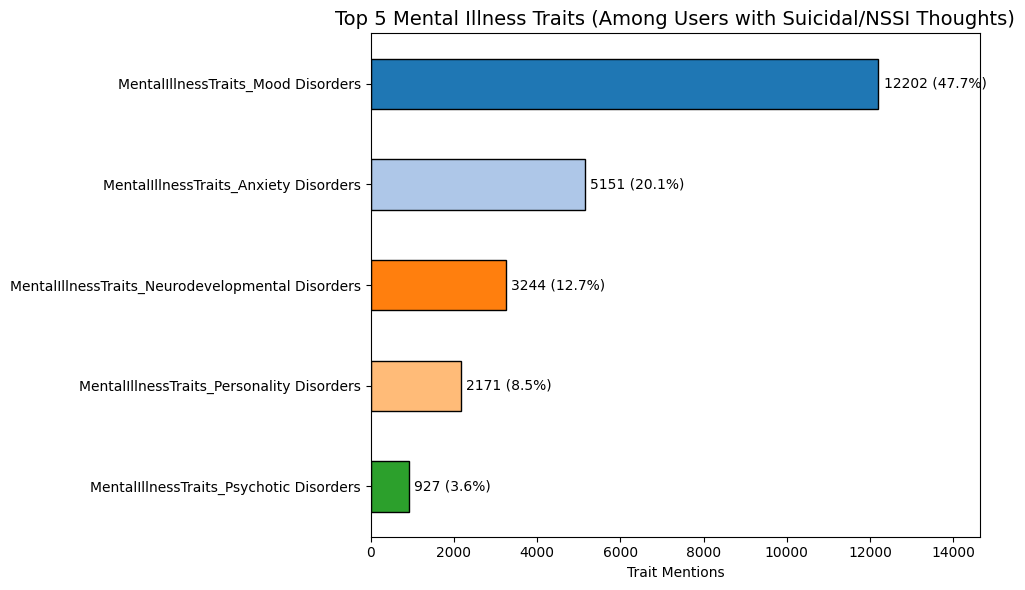

<ipython-input-29-45b30f5d88f9>:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab20')


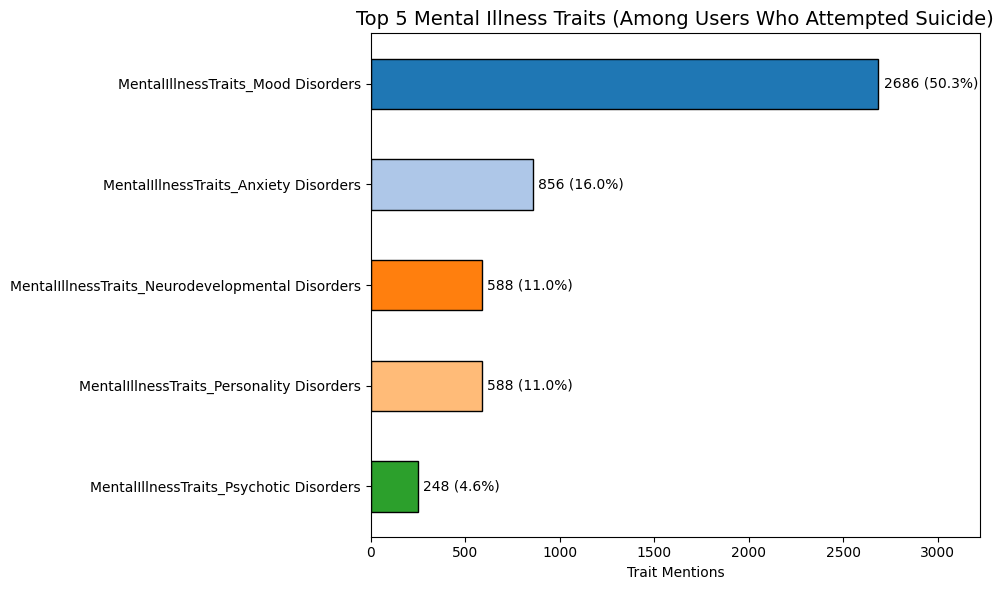

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# 1) Define your column names
thoughts_col = 'SelfHarmOrSuicidalThoughtsMentioned'
attempt_col  = 'AttemptedSuicide'
trait_cols   = [c for c in user.columns if c.startswith("MentalIllnessTraits_")]

# 2) Exclude any "None" trait column
valid_traits = [c for c in trait_cols if not c.endswith('_None')]

# 3) Ensure binary columns are ints
for c in [thoughts_col, attempt_col] + valid_traits:
    user[c] = pd.to_numeric(user[c], errors='coerce').fillna(0).astype(int)

# 4) Subset to users who mentioned suicidal/NSSI thoughts
df_thoughts = user[user[thoughts_col] == 1].copy()

# 5) Trait counts and proportions among this group
trait_counts = df_thoughts[valid_traits].sum()
total_trait_mentions = int(trait_counts.sum())

top5_traits = trait_counts.sort_values(ascending=False).head(5)
pct5_traits = (top5_traits / total_trait_mentions * 100).round(1)

top5_df = pd.DataFrame({
    'Count':               top5_traits.astype(int),
    'PctOfAllTraits (%)':  pct5_traits
})

print("=== Dominant Mental Illness Traits Among Users With Suicidal/NSSI Thoughts ===")
print(f"Total trait mentions: {total_trait_mentions}\n")
print(top5_df.to_string(), "\n")

# 6) Subset to users who attempted suicide
df_attempted = df_thoughts[df_thoughts[attempt_col] == 1].copy()

# 7) Trait counts and proportions among attempters
trait_counts_att = df_attempted[valid_traits].sum()
total_trait_mentions_att = int(trait_counts_att.sum())

top5_traits_att = trait_counts_att.sort_values(ascending=False).head(5)
pct5_traits_att = (top5_traits_att / total_trait_mentions_att * 100).round(1)

top5_att_df = pd.DataFrame({
    'Count': top5_traits_att.astype(int),
    'PctOfAttemptedTraits (%)': pct5_traits_att
})

print("=== Dominant Mental Illness Traits Among Users Who Attempted Suicide ===")
print(f"Total trait mentions among attempters: {total_trait_mentions_att}\n")
print(top5_att_df.to_string(), "\n")

# 8) Visualization function
def plot_trait_distribution(df, title, percent_label):
    cmap = get_cmap('tab20')
    colors = [cmap(i) for i in range(len(df))]

    fig, ax = plt.subplots(figsize=(10, 6))
    df['Count'].plot(kind='barh', color=colors, edgecolor='black', ax=ax)

    max_val = df['Count'].max()
    for i, (count, pct) in enumerate(zip(df['Count'], df[percent_label])):
        ax.text(count + max_val * 0.01, i, f'{count} ({pct}%)', va='center', fontsize=10)

    ax.set_xlim(0, max_val * 1.2)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Trait Mentions")
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

# 9) Plot both trait distributions
plot_trait_distribution(
    top5_df,
    'Top 5 Mental Illness Traits (Among Users with Suicidal/NSSI Thoughts)',
    'PctOfAllTraits (%)'
)

plot_trait_distribution(
    top5_att_df,
    'Top 5 Mental Illness Traits (Among Users Who Attempted Suicide)',
    'PctOfAttemptedTraits (%)'
)


Users who mentioned suicidal/NSSI thoughts:         78515
Of those, users using ≥1 coping mechanism:          2501
Total coping mechanism mentions:                    2621

=== Top 8 Coping Mechanisms Among Users With Thoughts ===
                                                        Count  PctOfAllCopingMentions (%)
HealthyCopingMechanism_Hobbies_and_creative_activities    834                        31.8
HealthyCopingMechanism_Exercise                           729                        27.8
HealthyCopingMechanism_Spending_time_with_loved_ones      383                        14.6
HealthyCopingMechanism_Pet_based                          347                        13.2
HealthyCopingMechanism_Spiritual/Religious                203                         7.7
HealthyCopingMechanism_Mindfulness_meditation             114                         4.3
HealthyCopingMechanism_Problem                              5                         0.2
HealthyCopingMechanism_solving                   

<ipython-input-31-cbeb43385ef5>:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab20')


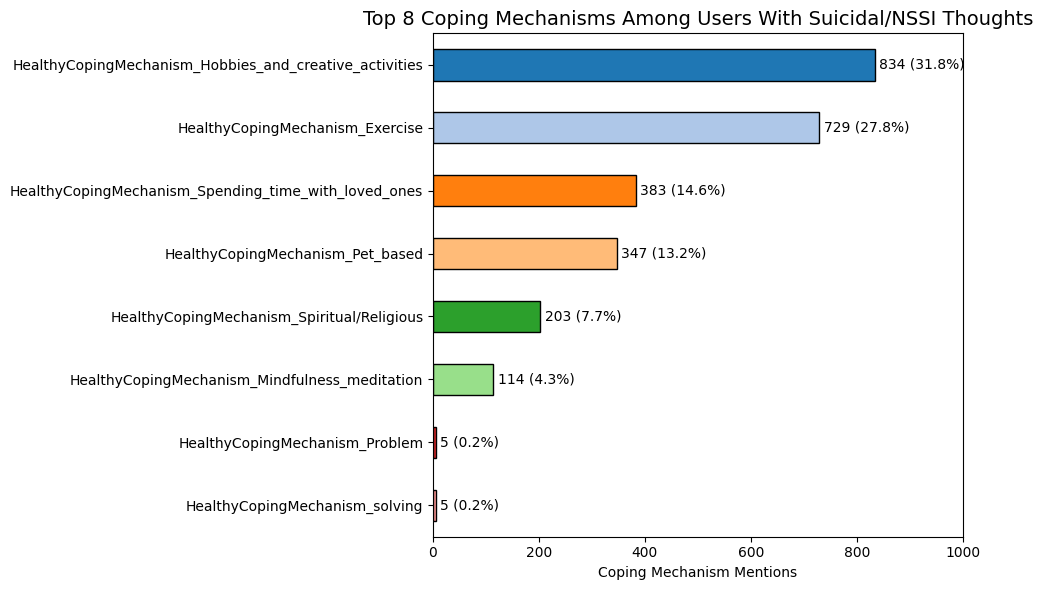

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# 1) Define your column names
thoughts_col     = 'SelfHarmOrSuicidalThoughtsMentioned'
coping_prefix    = 'HealthyCopingMechanism_'
all_coping_cols  = [c for c in user.columns if c.startswith(coping_prefix)]

# 2) Exclude “_None” column
valid_coping_cols = [c for c in all_coping_cols if not c.endswith('_None')]

# 3) Ensure binary columns are ints
user[thoughts_col] = pd.to_numeric(user[thoughts_col], errors='coerce').fillna(0).astype(int)
for c in valid_coping_cols:
    user[c] = pd.to_numeric(user[c], errors='coerce').fillna(0).astype(int)

# 4) Filter users with suicidal/NSSI thoughts
df = user[user[thoughts_col] == 1].copy()
total_thoughts = len(df)

# 5) Users who use ≥1 coping mechanism
coping_per_user   = df[valid_coping_cols].sum(axis=1)
users_with_coping = (coping_per_user > 0).sum()

# 6) Coping mechanism counts
coping_counts         = df[valid_coping_cols].sum()
total_coping_mentions = int(coping_counts.sum())

print(f"Users who mentioned suicidal/NSSI thoughts:         {total_thoughts}")
print(f"Of those, users using ≥1 coping mechanism:          {users_with_coping}")
print(f"Total coping mechanism mentions:                    {total_coping_mentions}\n")

# 7) Top 8 coping mechanisms
top8 = coping_counts.sort_values(ascending=False).head(8)
pct8 = (top8 / total_coping_mentions * 100).round(1)
top8_df = pd.DataFrame({
    'Count': top8.astype(int),
    'PctOfAllCopingMentions (%)': pct8
})
print("=== Top 8 Coping Mechanisms Among Users With Thoughts ===")
print(top8_df.to_string())

# 8) Visualization
def plot_coping_mechanisms(df, title, percent_col):
    cmap = get_cmap('tab20')
    colors = [cmap(i) for i in range(len(df))]

    fig, ax = plt.subplots(figsize=(10, 6))
    df['Count'].plot(kind='barh', ax=ax, color=colors, edgecolor='black')

    max_val = df['Count'].max()
    for i, (count, pct) in enumerate(zip(df['Count'], df[percent_col])):
        ax.text(count + max_val * 0.01, i, f'{count} ({pct}%)', va='center', fontsize=10)

    ax.set_xlim(0, max_val * 1.2)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Coping Mechanism Mentions")
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

# Plot chart
plot_coping_mechanisms(
    df=top8_df,
    title='Top 8 Coping Mechanisms Among Users With Suicidal/NSSI Thoughts',
    percent_col='PctOfAllCopingMentions (%)'
)


=== Top 5 Coping Mechanisms by Gender ===

--- Male (n=6092) ---
Total coping mentions: 315
                                                        Count  PctOfCopingMentions (%)
HealthyCopingMechanism_Exercise                           144                     45.7
HealthyCopingMechanism_Hobbies_and_creative_activities     70                     22.2
HealthyCopingMechanism_Spending_time_with_loved_ones       41                     13.0
HealthyCopingMechanism_Spiritual/Religious                 32                     10.2
HealthyCopingMechanism_Pet_based                           14                      4.4

--- Female (n=5798) ---
Total coping mentions: 301
                                                        Count  PctOfCopingMentions (%)
HealthyCopingMechanism_Hobbies_and_creative_activities    114                     37.9
HealthyCopingMechanism_Exercise                            66                     21.9
HealthyCopingMechanism_Spending_time_with_loved_ones       40            

<ipython-input-32-b761292306e3>:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab20')


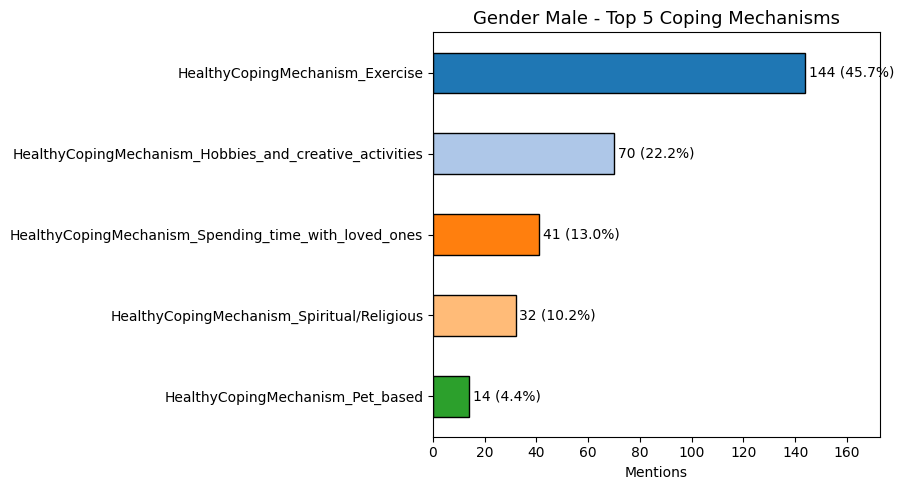

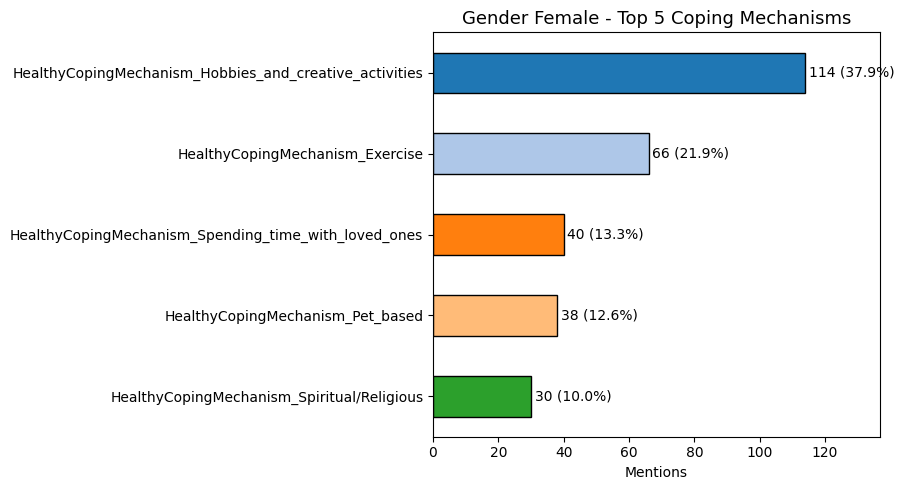

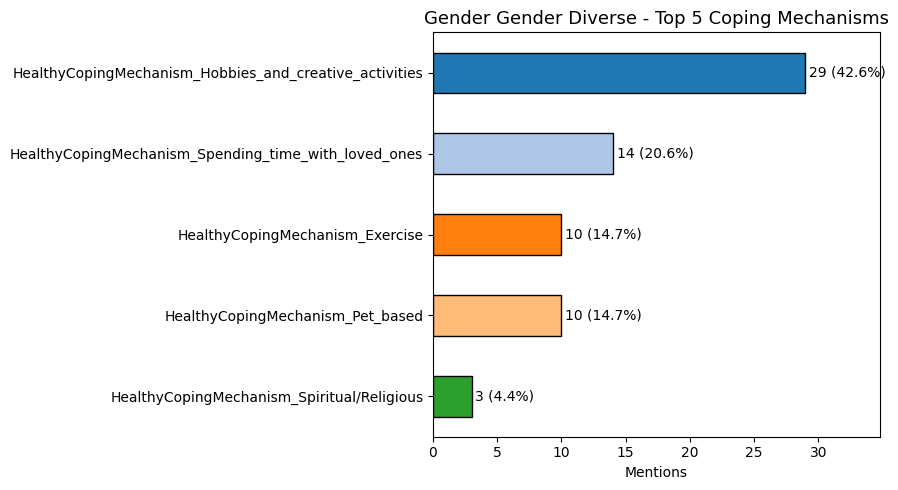

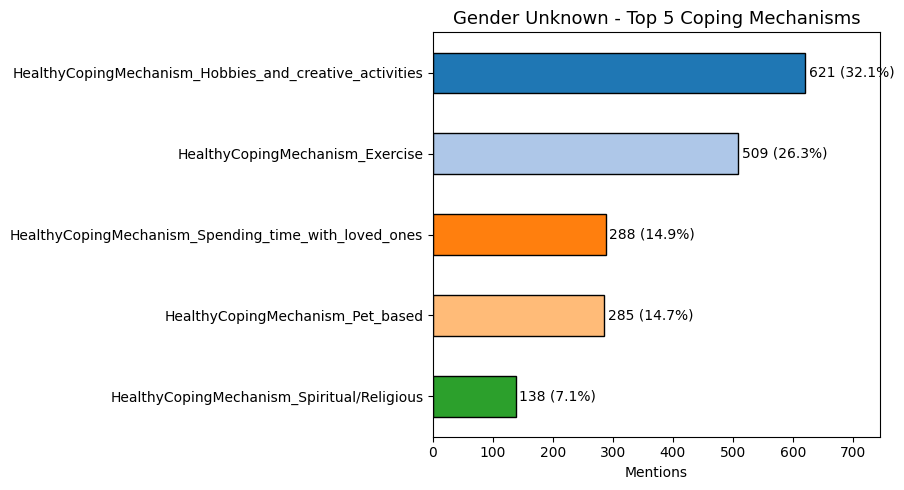


=== Top 5 Coping Mechanisms by Age Group ===

--- YoungAdult (n=13434) ---
Total coping mentions: 648
                                                        Count  PctOfCopingMentions (%)
HealthyCopingMechanism_Exercise                           227                     35.0
HealthyCopingMechanism_Hobbies_and_creative_activities    203                     31.3
HealthyCopingMechanism_Spending_time_with_loved_ones       80                     12.3
HealthyCopingMechanism_Pet_based                           66                     10.2
HealthyCopingMechanism_Spiritual/Religious                 48                      7.4

--- Adolescent (n=7515) ---
Total coping mentions: 326
                                                        Count  PctOfCopingMentions (%)
HealthyCopingMechanism_Hobbies_and_creative_activities    133                     40.8
HealthyCopingMechanism_Exercise                            69                     21.2
HealthyCopingMechanism_Spending_time_with_loved_ones      

<ipython-input-32-b761292306e3>:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab20')


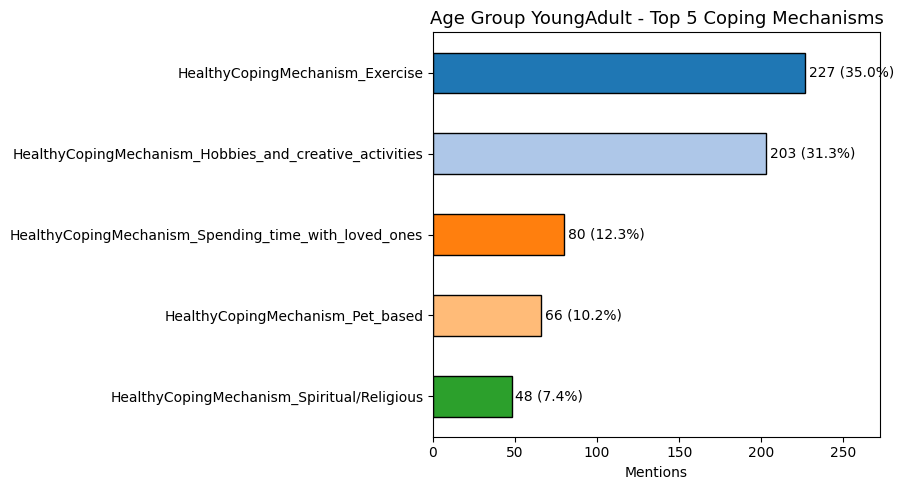

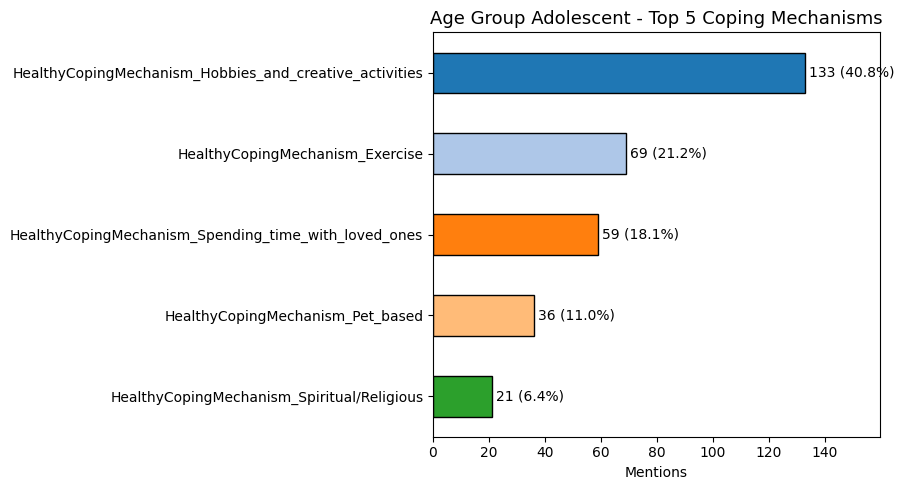

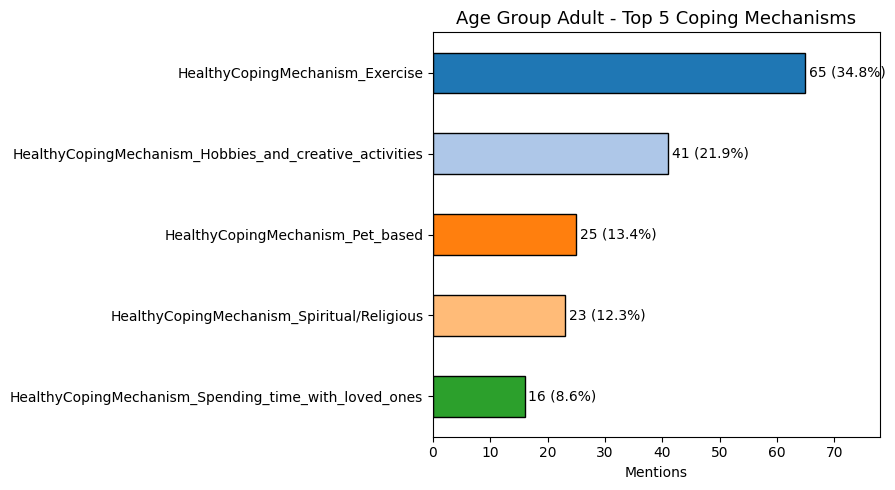

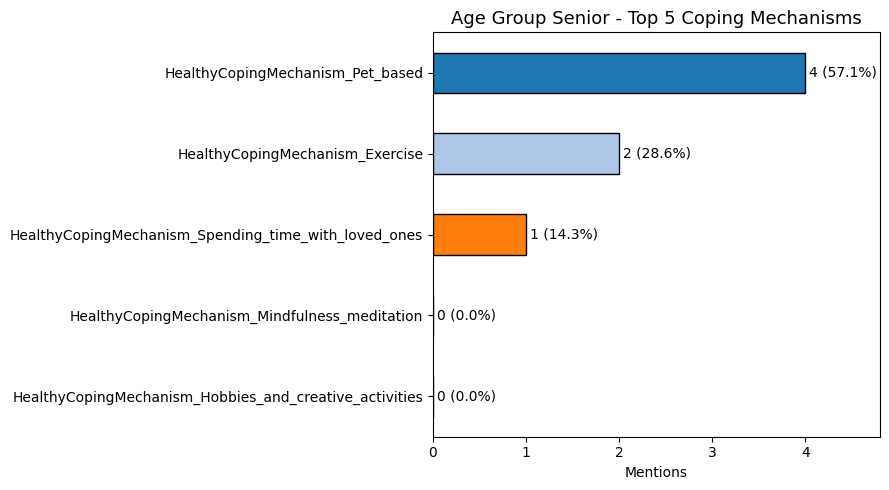

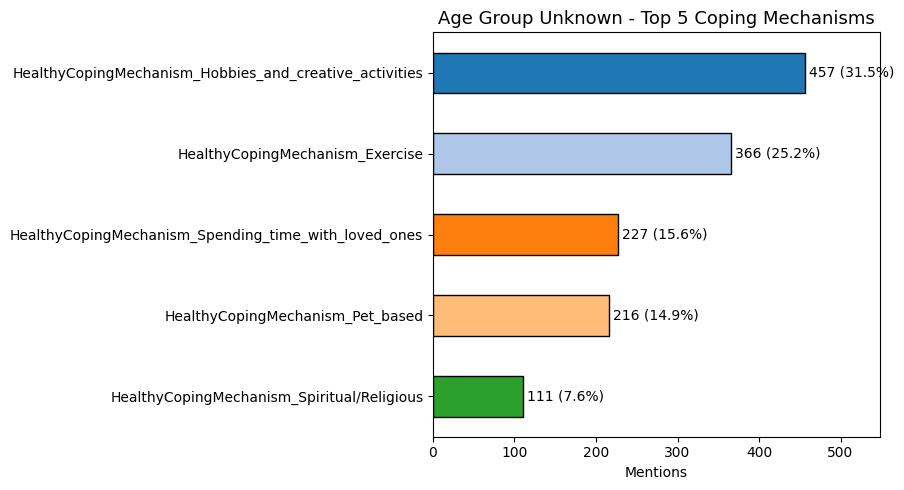

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# 1) Define your column names
thoughts_col     = 'SelfHarmOrSuicidalThoughtsMentioned'
coping_prefix    = 'HealthyCopingMechanism_'
all_coping_cols  = [c for c in user.columns if c.startswith(coping_prefix)]
valid_coping_cols = [c for c in all_coping_cols if not c.endswith('_None')]

# 2) Ensure binary columns are ints (0/1)
user[thoughts_col] = pd.to_numeric(user[thoughts_col], errors='coerce').fillna(0).astype(int)
for c in valid_coping_cols:
    user[c] = pd.to_numeric(user[c], errors='coerce').fillna(0).astype(int)

# 3) Filter to users with suicidal/NSSI thoughts
df = user[user[thoughts_col] == 1].copy()
df['Gender'] = df['Gender'].fillna('Unknown')
df['AgeGroup'] = df['AgeGroup'].fillna('Unknown')

# Helper function for plotting
def plot_coping_by_group(group_data, title_prefix, percent_col):
    cmap = get_cmap('tab20')
    for group, df in group_data.items():
        colors = [cmap(i) for i in range(len(df))]
        fig, ax = plt.subplots(figsize=(9, 5))
        df['Count'].plot(kind='barh', ax=ax, color=colors, edgecolor='black')

        max_val = df['Count'].max()
        for i, (count, pct) in enumerate(zip(df['Count'], df[percent_col])):
            ax.text(count + max_val * 0.01, i, f'{count} ({pct}%)', va='center', fontsize=10)

        ax.set_xlim(0, max_val * 1.2)
        ax.set_title(f'{title_prefix} {group} - Top 5 Coping Mechanisms', fontsize=13)
        ax.set_xlabel("Mentions")
        ax.invert_yaxis()
        plt.tight_layout()
        plt.show()

# 4) Coping by Gender
gender_coping_data = {}
gender_order = [g for g in df['Gender'].value_counts().index if g != 'Unknown']
if 'Unknown' in df['Gender'].unique():
    gender_order.append('Unknown')

print("=== Top 5 Coping Mechanisms by Gender ===")
for gender in gender_order:
    sub = df[df['Gender'] == gender]
    counts = sub[valid_coping_cols].sum()
    total_mentions = int(counts.sum())
    top5 = counts.sort_values(ascending=False).head(5)
    pct5 = (top5 / total_mentions * 100).round(1)
    result = pd.DataFrame({
        'Count': top5.astype(int),
        'PctOfCopingMentions (%)': pct5
    })
    gender_coping_data[gender] = result
    print(f"\n--- {gender} (n={len(sub)}) ---")
    print(f"Total coping mentions: {total_mentions}")
    print(result.to_string())

# Plot Gender Distribution
plot_coping_by_group(gender_coping_data, "Gender", "PctOfCopingMentions (%)")

# 5) Coping by AgeGroup
age_coping_data = {}
age_order = [a for a in df['AgeGroup'].value_counts().index if a != 'Unknown']
if 'Unknown' in df['AgeGroup'].unique():
    age_order.append('Unknown')

print("\n=== Top 5 Coping Mechanisms by Age Group ===")
for age in age_order:
    sub = df[df['AgeGroup'] == age]
    counts = sub[valid_coping_cols].sum()
    total_mentions = int(counts.sum())
    top5 = counts.sort_values(ascending=False).head(5)
    pct5 = (top5 / total_mentions * 100).round(1)
    result = pd.DataFrame({
        'Count': top5.astype(int),
        'PctOfCopingMentions (%)': pct5
    })
    age_coping_data[age] = result
    print(f"\n--- {age} (n={len(sub)}) ---")
    print(f"Total coping mentions: {total_mentions}")
    print(result.to_string())

# Plot AgeGroup Distribution
plot_coping_by_group(age_coping_data, "Age Group", "PctOfCopingMentions (%)")


Users who mentioned suicidal/NSSI thoughts:              78515
Users (of those) seeking ≥1 treatment mechanism:         13213 (16.8%)

Total treatment mechanism mentions (sum of all flags):    15440

=== Treatment Mechanism Distribution Among Users With Thoughts ===
                                          Count  PctOfAllTreatmentMentions (%)
TreatmentMechanism_Therapy/Counseling      8967                           58.1
TreatmentMechanism_Prescribed Medication   6473                           41.9


<ipython-input-33-6364a937187f>:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab20')


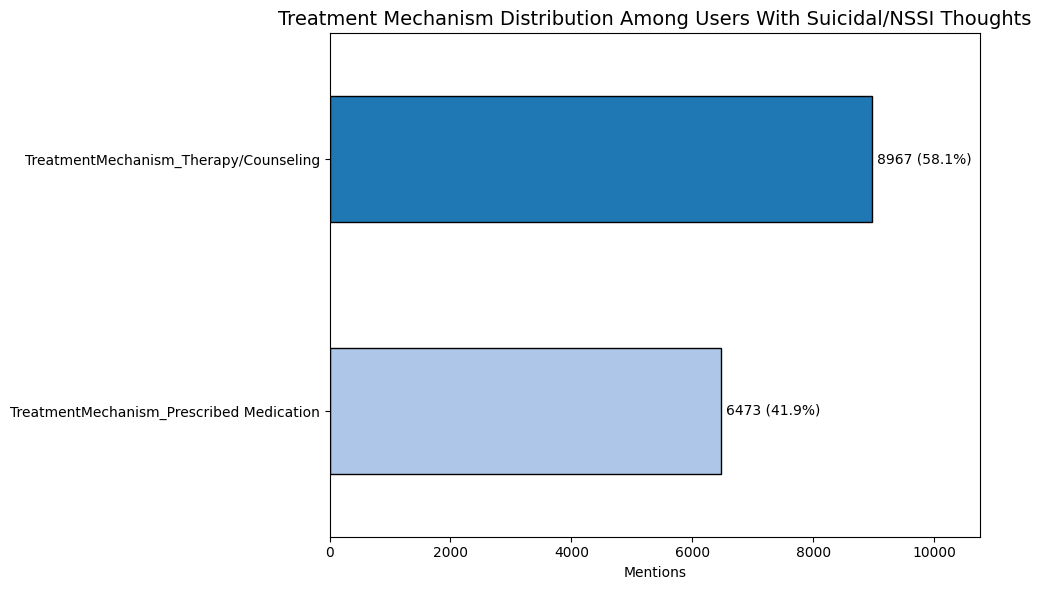

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# 1) Define your column names
thoughts_col = 'SelfHarmOrSuicidalThoughtsMentioned'
treat_prefix = 'TreatmentMechanism_'
all_treat_cols = [c for c in user.columns if c.startswith(treat_prefix)]
valid_treat_cols = [c for c in all_treat_cols if not c.endswith('_None')]

# 2) Ensure binary columns are ints (0/1)
user[thoughts_col] = pd.to_numeric(user[thoughts_col], errors='coerce').fillna(0).astype(int)
for c in valid_treat_cols:
    user[c] = pd.to_numeric(user[c], errors='coerce').fillna(0).astype(int)

# 3) Filter to users who mentioned suicidal/NSSI thoughts
df = user[user[thoughts_col] == 1].copy()
total_thoughts = len(df)

# 4) Count users who reported ≥1 treatment mechanism
treat_per_user = df[valid_treat_cols].sum(axis=1)
users_with_treatment = (treat_per_user > 0).sum()

# 5) Total count of treatment mechanism mentions
treat_counts = df[valid_treat_cols].sum()
total_treatment_mentions = int(treat_counts.sum())

print(f"Users who mentioned suicidal/NSSI thoughts:              {total_thoughts}")
print(f"Users (of those) seeking ≥1 treatment mechanism:         {users_with_treatment} "
      f"({users_with_treatment / total_thoughts * 100:.1f}%)\n")
print(f"Total treatment mechanism mentions (sum of all flags):    {total_treatment_mentions}\n")

# 6) Show distribution if there's data
if total_treatment_mentions > 0:
    dist_df = pd.DataFrame({
        'Count': treat_counts.astype(int),
        'PctOfAllTreatmentMentions (%)': (treat_counts / total_treatment_mentions * 100).round(1)
    }).sort_values('Count', ascending=False)

    print("=== Treatment Mechanism Distribution Among Users With Thoughts ===")
    print(dist_df.to_string())

    # Plotting
    cmap = get_cmap('tab20')
    colors = [cmap(i) for i in range(len(dist_df))]

    fig, ax = plt.subplots(figsize=(10, 6))
    dist_df['Count'].plot(kind='barh', ax=ax, color=colors, edgecolor='black')

    max_val = dist_df['Count'].max()
    for i, (count, pct) in enumerate(zip(dist_df['Count'], dist_df['PctOfAllTreatmentMentions (%)'])):
        ax.text(count + max_val * 0.01, i, f'{count} ({pct}%)', va='center', fontsize=10)

    ax.set_xlim(0, max_val * 1.2)
    ax.set_title("Treatment Mechanism Distribution Among Users With Suicidal/NSSI Thoughts", fontsize=14)
    ax.set_xlabel("Mentions")
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No treatment mechanisms were mentioned by users.")


In [ ]:
import pandas as pd

# 1) Define your column names
thoughts_col     = 'SelfHarmOrSuicidalThoughtsMentioned'
coping_prefix    = 'HealthyCopingMechanism_'     # adjust prefix to match your DataFrame
treat_prefix     = 'TreatmentMechanism_'  # adjust prefix as needed

# 2) Identify all coping and treatment columns, excluding “_None”
all_coping_cols = [c for c in user.columns if c.startswith(coping_prefix)]
valid_coping_cols = [c for c in all_coping_cols if not c.endswith('_None')]

all_treat_cols = [c for c in user.columns if c.startswith(treat_prefix)]
valid_treat_cols = [c for c in all_treat_cols if not c.endswith('_None')]

# 3) Ensure binary columns are ints (0/1)
user[thoughts_col] = (
    pd.to_numeric(user[thoughts_col], errors='coerce')
      .fillna(0)
      .astype(int)
)
for c in valid_coping_cols + valid_treat_cols:
    user[c] = pd.to_numeric(user[c], errors='coerce').fillna(0).astype(int)

# 4) Restrict to users who mentioned suicidal/NSSI thoughts
df = user[user[thoughts_col] == 1].copy()
total_thoughts = len(df)

# 5) Determine who uses any coping, any treatment, and both
uses_coping    = df[valid_coping_cols].sum(axis=1) > 0
uses_treatment = df[valid_treat_cols].sum(axis=1) > 0
uses_both      = uses_coping & uses_treatment

num_uses_coping    = uses_coping.sum()
num_uses_treatment = uses_treatment.sum()
num_uses_both      = uses_both.sum()

# 6) Compute proportions
pct_coping    = round(num_uses_coping    / total_thoughts * 100, 1)
pct_treatment = round(num_uses_treatment / total_thoughts * 100, 1)
pct_both      = round(num_uses_both      / total_thoughts * 100, 1)

# 7) Display results
print(f"Users who mentioned suicidal/NSSI thoughts:           {total_thoughts}\n")
print(f"Users using ≥1 coping mechanism:                      {num_uses_coping} ({pct_coping}%)")
print(f"Users seeking ≥1 treatment mechanism:                 {num_uses_treatment} ({pct_treatment}%)")
print(f"Users using both coping + treatment mechanisms:       {num_uses_both} ({pct_both}%)")


Users who mentioned suicidal/NSSI thoughts:           78515

Users using ≥1 coping mechanism:                      2501 (3.2%)
Users seeking ≥1 treatment mechanism:                 13213 (16.8%)
Users using both coping + treatment mechanisms:       843 (1.1%)


Model For checking Engagement

In [ ]:
import pandas as pd

# 1. Load your extracted features CSV
df = pd.read_csv("suicide_features_ohe.csv")

# 2. Filter to main-post rows only:
#    by selecting rows where Comment_ID is NA
if 'Comment_ID' in df.columns:
    df_main = df[df['Comment_ID'].isna()]
else:
    df_main = df.copy()

# 3. Keep only rows where 'Score' is not null
df_main = df_main[df_main['Score'].notna()]

# 4. Define core columns to keep
core_columns = [
    'AuthorID',
    'Main_Post_ID',
    'Timestamp',
    'NumComments',
    'PreparatoryPlanMentioned',
    'AttemptedSuicide',
    'Gender',
    'AgeGroup',
    'SentimentScore',
    'Score'
]

# 5. Find one-hot encoded feature columns by prefix
prefixes = [
    'SuicidalOrNSSIMethods_',
    'ReasonBehindSuicideNSSI_',
    'HealthyCopingMechanism_',
    'SuicidalIdeationTemporalFocus_'
]
onehot_columns = [
    col for col in df_main.columns
    if any(col.startswith(prefix) for prefix in prefixes)
]

# 6. Combine all columns
selected_columns = core_columns + onehot_columns

# 7. Select and reset index
df_filtered = df_main[selected_columns].reset_index(drop=True)

# 8. Preview result
print(df_filtered.head())


<ipython-input-43-cf8cd39dc05c>:4: DtypeWarning: Columns (4,16,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("suicide_features_ohe.csv")


           AuthorID Main_Post_ID            Timestamp NumComments  \
0  courtney_eaves82      16jq6n8  2023-09-15 21:57:45         0.0   
1  courtney_eaves82      16n50w7  2023-09-19 22:57:03         4.0   
2  courtney_eaves82      16nm759  2023-09-20 14:07:00        15.0   
3  courtney_eaves82      16pm7nb  2023-09-22 21:37:28         0.0   
4  courtney_eaves82      178vedp  2023-10-16 02:15:25         1.0   

   PreparatoryPlanMentioned  AttemptedSuicide   Gender AgeGroup  \
0                         0                 0  Unknown  Unknown   
1                         0                 0  Unknown  Unknown   
2                         0                 0  Unknown  Unknown   
3                         0                 0  Unknown  Unknown   
4                         0                 0  Unknown  Unknown   

  SentimentScore  Score  ...  HealthyCopingMechanism_Problem  \
0          -0.97    1.0  ...                               0   
1           -0.7    1.0  ...                          

In [ ]:
import pandas as pd

# 1. Start from your filtered DataFrame
df = df_filtered.copy()

# 2. Clean and convert SentimentScore to float, drop rows with invalid values
df["SentimentScore"] = pd.to_numeric(df["SentimentScore"], errors="coerce")
df = df.dropna(subset=["SentimentScore"])

# 2. Categorize sentimentalscore
def categorize_sentiment(SentimentScore):
    if SentimentScore == 0:
        return "Neutral"
    elif SentimentScore < 0:
        return "Negative"
    else:
        return "Positive"

df["sentiment_label"] = df["SentimentScore"].apply(categorize_sentiment)

# 3. One-hot encode gender, agegroup, and sentiment_label
df_ohe = pd.get_dummies(
    df,
    columns=["Gender", "AgeGroup", "sentiment_label"],
    prefix=["Gender", "Age", "Sentiment"]
)

# 4. (Optional) Inspect the result
print(df_ohe.head())

           AuthorID Main_Post_ID            Timestamp NumComments  \
0  courtney_eaves82      16jq6n8  2023-09-15 21:57:45         0.0   
1  courtney_eaves82      16n50w7  2023-09-19 22:57:03         4.0   
2  courtney_eaves82      16nm759  2023-09-20 14:07:00        15.0   
3  courtney_eaves82      16pm7nb  2023-09-22 21:37:28         0.0   
4  courtney_eaves82      178vedp  2023-10-16 02:15:25         1.0   

   PreparatoryPlanMentioned  AttemptedSuicide  SentimentScore  Score  \
0                         0                 0           -0.97    1.0   
1                         0                 0           -0.70    1.0   
2                         0                 0           -0.91    1.0   
3                         0                 0           -0.58    1.0   
4                         0                 0           -0.97    1.0   

   SuicidalOrNSSIMethods_Accidental death  SuicidalOrNSSIMethods_Alcohol  ...  \
0                                       0                              

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

# 1. Start from your one-hot-encoded DataFrame df_ohe
df = df_ohe.copy()

# 2. Coerce numeric columns
df['NumComments'] = pd.to_numeric(df['NumComments'], errors='coerce')
df['Score']       = pd.to_numeric(df['Score'],       errors='coerce')

# 3. Define predictors
feature_cols = [
    'NumComments', 'PreparatoryPlanMentioned', 'AttemptedSuicide',
    'Gender_Female', 'Gender_Gender Diverse', 'Gender_Male',
    'Age_Adolescent', 'Age_Adult', 'Age_Senior', 'Age_YoungAdult'
] + [c for c in df.columns if c.startswith((
    'Sentiment_', 'SuicidalIdeationTemporalFocus_'
))]

# 4. Build X and y
X = df[feature_cols]
y = df['Score']

# 5. Drop rows with any NaNs in X or y
model_df = pd.concat([X, y], axis=1).dropna()
X_clean  = model_df[feature_cols]
y_clean  = model_df['Score']

# 6. Significance tests
print("=== SIGNIFICANCE TESTS ===\n")

# 6a) NumComments vs Score (Pearson correlation)
r, p = pearsonr(X_clean['NumComments'], y_clean)
print(f"NumComments vs Score:\n  Pearson correlation r = {r:.3f}, p = {p:.3g}\n")

# 6b) Binary features via t-test, structured into a table
bin_cols = [c for c in feature_cols if X_clean[c].nunique() == 2]
t_results = []

for col in bin_cols:
    grp0 = y_clean[X_clean[col] == 0]
    grp1 = y_clean[X_clean[col] == 1]
    if len(grp0) > 1 and len(grp1) > 1:
        t, p = ttest_ind(grp0, grp1, equal_var=False)
        t_results.append({
            'Feature': col,
            't-statistic': round(t, 3),
            'p-value': round(p, 5),
            'Mean (0)': round(grp0.mean(), 3),
            'Mean (1)': round(grp1.mean(), 3),
            'N (0)': len(grp0),
            'N (1)': len(grp1)
        })

# Convert to DataFrame and display
ttest_df = pd.DataFrame(t_results).sort_values('p-value')
print("\n=== T-Test Results: Binary Predictors vs Score ===")
print(ttest_df.to_string(index=False))


=== SIGNIFICANCE TESTS ===

NumComments vs Score:
  Pearson correlation r = 0.685, p = 0


=== T-Test Results: Binary Predictors vs Score ===
                                      Feature  t-statistic  p-value  Mean (0)  Mean (1)  N (0)  N (1)
                             AttemptedSuicide       -4.842  0.00000     6.397     7.865 126698  12968
                                Gender_Female       -8.024  0.00000     6.282     9.193 127604  12062
          SuicidalIdeationTemporalFocus_Mixed       15.956  0.00000     6.611     3.549 136121   3545
                            Sentiment_Neutral        4.732  0.00000     6.588     4.797 135415   4251
SuicidalIdeationTemporalFocus_Present_focused      -11.398  0.00000     5.125     6.975  33361 106305
        SuicidalIdeationTemporalFocus_Unclear        8.965  0.00000     6.660     4.519 131398   8268
 SuicidalIdeationTemporalFocus_Future_focused        7.155  0.00000     6.675     5.018 127756  11910
                     PreparatoryPlanMentio

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

# 1. Start from your one-hot encoded DataFrame
df = df_ohe.copy()

# 2. Coerce numeric columns
df['NumComments'] = pd.to_numeric(df['NumComments'], errors='coerce')
df['Score']       = pd.to_numeric(df['Score'],       errors='coerce')

# 3. Build the full feature list, then drop the excluded ones
feature_cols = (
    ['NumComments', 'Gender_Female', 'AttemptedSuicide', 'Sentiment_Positive', 'PreparatoryPlanMentioned'
    ,'Gender_Male', 'Age_YoungAdult', 'Age_Adult']
)


# 4. Assemble X and y, drop any rows with missing values
X = df[feature_cols]
y = df['Score']
model_df = pd.concat([X, y], axis=1).dropna()
X_clean = model_df[feature_cols].astype(float)
y_clean = model_df['Score'].astype(float)

# 5. Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42
)

# 6. Fit a plain Linear Regression
lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)

print("=== Linear Regression Performance ===")
print(f"R²:   {r2_score(y_test, y_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}\n")

# 7. Show coefficients
coef_df = pd.Series(lr.coef_, index=feature_cols).sort_values(ascending=False)
print("Top positive coefficients:")
print(coef_df.head(5))
print("\nTop negative coefficients:")
print(coef_df.tail(5))

# 8. Full OLS summary (on training set) for inference
X_train_sm = sm.add_constant(X_train)
ols_model = sm.OLS(y_train, X_train_sm).fit()
print("\n=== OLS Regression Summary ===")
print(ols_model.summary())


=== Linear Regression Performance ===
R²:   0.446
RMSE: 23.266

Top positive coefficients:
Sentiment_Positive    2.135039
NumComments           2.134069
Age_Adult             0.197744
Age_YoungAdult        0.185216
AttemptedSuicide      0.063282
dtype: float64

Top negative coefficients:
Age_YoungAdult              0.185216
AttemptedSuicide            0.063282
Gender_Female              -0.938459
Gender_Male                -1.188802
PreparatoryPlanMentioned   -1.620965
dtype: float64

=== OLS Regression Summary ===
                            OLS Regression Results                            
Dep. Variable:                  Score   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                 1.267e+04
Date:                Wed, 07 May 2025   Prob (F-statistic):               0.00
Time:                        23:30:18   Log-Likelihood:            -5.0248e+05
No. O

In [ ]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# 1. Your binary predictors
binary_vars = [
    'Gender_Female', 'AttemptedSuicide', 'Sentiment_Positive',
    'PreparatoryPlanMentioned', 'Gender_Male',
    'Age_YoungAdult', 'Age_Adult'
]

# 2. Extract just these columns from df_ohe
X = df_ohe[binary_vars].copy()

# 3. Convert all to float explicitly (not just to_numeric)
X = X.astype('float64')

# 4. Drop rows with any missing or infinite values
X = X.replace([np.inf, -np.inf], np.nan).dropna()

# 5. Add constant for intercept
X_const = add_constant(X)

# 6. Compute VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

# 7. Display VIFs
print("=== Variance Inflation Factors ===")
print(vif_data.sort_values(by="VIF", ascending=False))


=== Variance Inflation Factors ===
                   Variable       VIF
0                     const  1.633530
6            Age_YoungAdult  1.157265
5               Gender_Male  1.127506
1             Gender_Female  1.084763
7                 Age_Adult  1.065976
2          AttemptedSuicide  1.003235
4  PreparatoryPlanMentioned  1.003142
3        Sentiment_Positive  1.001254


User Story

In [ ]:
import pandas as pd

# 1. Load your extracted features CSV
df = pd.read_csv("suicide_features_ohe.csv")

# 2. Ensure we only consider rows where both author_id and post_id are present
df = df.dropna(subset=["AuthorID", "Main_Post_ID"])

# 3. Count unique posts per author
post_counts = (
    df.groupby("AuthorID")           # group by user
      ["Main_Post_ID"]                     # select the post identifier
      .nunique()                      # count distinct posts
      .reset_index(name="post_count") # turn into a DataFrame
)

# 4. Sort descending and take top 10
top_10_users = post_counts.sort_values("post_count", ascending=False).head(10)

# 5. Display the result
print(top_10_users)


<ipython-input-53-805756e0f49d>:4: DtypeWarning: Columns (4,16,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("suicide_features_ohe.csv")


                   AuthorID  post_count
66322      hotandcoldcoffee          55
61362              crazytbh          52
9911   Complex_Butterfly574          47
80719       throwaway408914          47
34714  NorthExplanation4401          45
51735           TrainMan102          45
79993        thesearch4life          44
60652           cherryswans          43
30588             Metal8499          42
76559         sadsealmother          42


In [ ]:
import pandas as pd

# 1. Load your extracted features CSV
df = pd.read_csv("suicide_features_ohe.csv")

# 2. Filter to only the rows for author "avoidantsquirrel"
author = "Interesting_Disk_952"
df_author = df[df["AuthorID"] == author]

# 3. Drop duplicates so you get one row per post_id
#    (assuming each post_id corresponds to one main post)
df_author_1 = df_author.drop_duplicates(subset=["Main_Post_ID"])

# 4. (Optional) Check you have 62 rows





<ipython-input-81-329243ab7a00>:4: DtypeWarning: Columns (4,16,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("suicide_features_ohe.csv")


In [ ]:
import pandas as pd
import re

# Assuming `df` is your DataFrame with the 62 posts and an existing `emotional_score` column

# 1. Define the exact emotion order you want
emotion_order = ["joy", "sadness", "anger", "fear", "surprise", "disgust"]

# 2. A function that extracts each emotion’s numeric value via regex and then formats
def clean_and_format_emotional_score(s):
    # Ensure it's a string
    text = str(s)
    values = {}
    for emotion in emotion_order:
        # regex to find e.g. 'joy: 0.01'
        pattern = rf'{re.escape(emotion)}\s*:\s*([0-9]*\.?[0-9]+)'
        m = re.search(pattern, text)
        values[emotion] = float(m.group(1)) if m else 0.0

    # build the standardized string
    parts = [f'"{emotion}: {values[emotion]:.2f}"' for emotion in emotion_order]
    return "(" + "-".join(parts) + ")"

# 3. Apply to your DataFrame
df_author_1['EmotionalScore'] = df_author_1['EmotionalScore'].apply(clean_and_format_emotional_score)




<ipython-input-82-3ddaf6a2a540>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_author_1['EmotionalScore'] = df_author_1['EmotionalScore'].apply(clean_and_format_emotional_score)


In [ ]:
import pandas as pd
import re

# 1. Start from your filtered DataFrame of 62 posts
df = df_author_1.copy()

# 2. Sort by time (so deltas make sense)
df = df.sort_values("Timestamp").reset_index(drop=True)

# 3. Parse your standardized emotional_score strings into six separate float columns
emotion_order = ["joy", "sadness", "anger", "fear", "surprise", "disgust"]

def parse_emotion_str(s):
    text = str(s)
    values = {}
    for emotion in emotion_order:
        # look for patterns like 'joy: 0.01'
        pattern = rf'{re.escape(emotion)}\s*:\s*([0-9]*\.?[0-9]+)'
        m = re.search(pattern, text)
        values[emotion] = float(m.group(1)) if m else 0.0
    return values

# apply parser and turn into a DataFrame
emotions_df = pd.DataFrame(
    df["EmotionalScore"].apply(parse_emotion_str).tolist(),
    index=df.index
)

# combine back into df
df = pd.concat([df, emotions_df], axis=1)

# 4. “Flatten” binary 0/1 columns:
#    detect all cols whose non-null values are only 0 or 1
binary_cols = [
    col for col in df.columns
    if set(df[col].dropna().unique()).issubset({0, 1})
]

#    for each of those, if there's at least one “1” anywhere,
#    set the entire column to 1
for col in binary_cols:
    if df[col].sum() > 0:
        df[col] = 1

# 5. Compute the “delta” for each emotion across consecutive posts
for emotion in emotion_order:
    df[f"{emotion}_delta"] = df[emotion].diff().fillna(0)

# 6. Your final DataFrame `df` now has:
#    - One column per emotion (e.g. "joy", "sadness", etc.)
#    - One delta column per emotion (e.g. "joy_delta", ...)
#    - All original binary cols flattened to either all-0 or all-1 across the 62 posts
#
# You can now visualize the emotional trends, for example:
# df.plot(x="created_utc", y=[f"{e}_delta" for e in emotion_order])


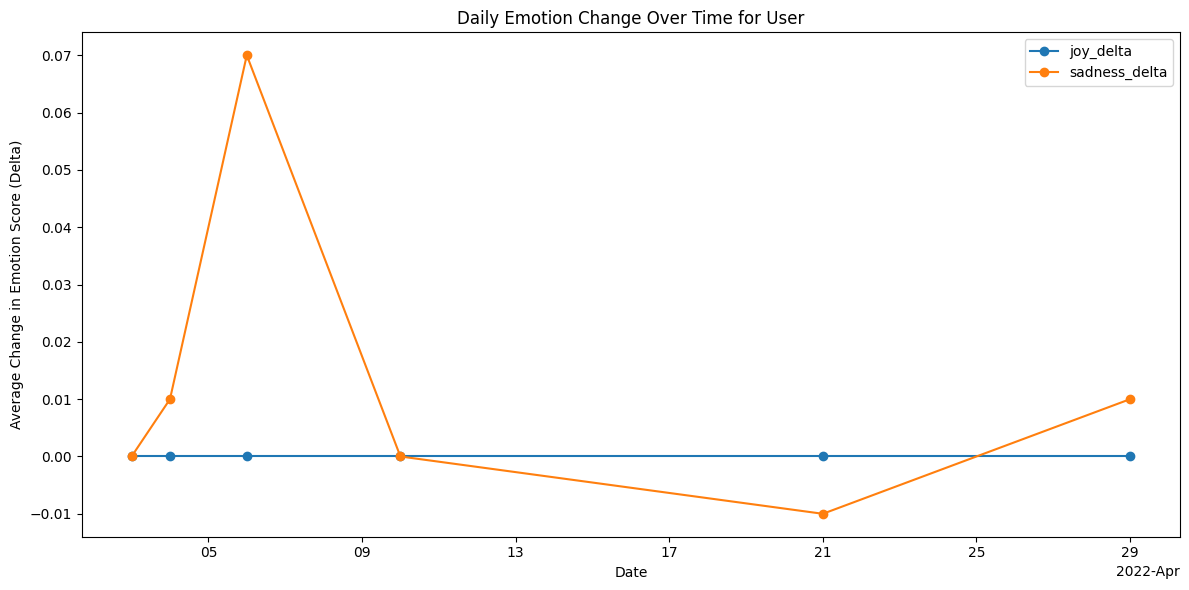

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1. Start from your DataFrame `df2`
df2 = df.copy()

# 2. Parse 'Timestamp' column into datetime format (handles mixed date formats)
df2['ParsedTimestamp'] = pd.to_datetime(df2['Timestamp'], format='mixed', errors='coerce')

# 3. Extract only the date part
df2['date'] = df2['ParsedTimestamp'].dt.date
df2 = df2.dropna(subset=['date'])  # drop rows where date couldn't be parsed

# 4. Convert 'date' back to datetime format (for plotting)
df2['date'] = pd.to_datetime(df2['date'])

# 5. Define emotions of interest
emotions = ["joy", "sadness"]
delta_cols = [f"{e}_delta" for e in emotions]

# 6. Sort and group by date
df2 = df2.sort_values('date')
daily_deltas = (
    df2.groupby('date')[delta_cols]
       .mean()
       .reset_index()
)

# 7. Plot emotion deltas
fig, ax = plt.subplots(figsize=(12, 6))
for col in delta_cols:
    ax.plot(daily_deltas['date'], daily_deltas[col], marker='o', label=col)

# 8. Improve date formatting on x-axis
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# 9. Final plot touches
ax.set_xlabel('Date')
ax.set_ylabel('Average Change in Emotion Score (Delta)')
ax.set_title('Daily Emotion Change Over Time for User')
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# 1. Assuming you already have df2 loaded for TrainMan102:
# df2 = pd.read_csv("extracted_features.csv")
# df2 = df2[df2['author_id']=='TrainMan102'].drop_duplicates('post_id').reset_index(drop=True)

# 2. Identify your one-hot encoded columns
coping_cols    = [c for c in df2.columns if c.startswith("HealthyCopingMechanism_")]
treatment_cols = [c for c in df2.columns if c.startswith("TreatmentMechanism_")]

# 3. Which coping mechanisms ever appear? (exclude 'None')
coping_used = [
    col.replace("HealthyCopingMechanism_", "")
    for col in coping_cols
    if df2[col].sum() > 0
]
coping_used = [mech for mech in coping_used if mech.lower() != 'none']


# 4. Flag any post where the user is seeking treatment
df2['seeking_treatment'] = df2[treatment_cols].any(axis=1)

# 5. Which treatment mechanisms ever appear? (exclude 'None')
treatment_used = [
    col.replace("TreatmentMechanism_", "")
    for col in treatment_cols
    if df2[col].sum() > 0
]
treatment_used = [mech for mech in treatment_used if mech.lower() != 'none']

# 6. Subset of posts where treatment is sought
treatment_posts = df2[df2['seeking_treatment']]

# 7. Print your summary
print("🔹 Coping mechanisms mentioned by Interesting_Disk_952	:")
if coping_used:
    for mech in coping_used:
        print(f"  • {mech}")
else:
    print("  • None found")



print("\n🔹 Treatment mechanisms sought by Interesting_Disk_952:")
if treatment_used:
    for mech in treatment_used:
        print(f"  • {mech}")
else:
    print("  • None found")



🔹 Coping mechanisms mentioned by Interesting_Disk_952	:
  • None found

🔹 Treatment mechanisms sought by Interesting_Disk_952:
  • None found


In [ ]:
import pandas as pd

# 1. Load your extracted features CSV
df = pd.read_csv("suicide_features_ohe.csv")

# 2. Filter to only the rows for author "avoidantsquirrel"
author = "crazytbh"
df_author = df[df["AuthorID"] == author]

# 3. Drop duplicates so you get one row per post_id
#    (assuming each post_id corresponds to one main post)
df_author_1 = df_author.drop_duplicates(subset=["Main_Post_ID"])

# 4. (Optional) Check you have 62 rows





<ipython-input-94-1cc26426cac4>:4: DtypeWarning: Columns (4,16,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("suicide_features_ohe.csv")


In [ ]:
import pandas as pd
import re

# Assuming `df` is your DataFrame with the 62 posts and an existing `emotional_score` column

# 1. Define the exact emotion order you want
emotion_order = ["joy", "sadness", "anger", "fear", "surprise", "disgust"]

# 2. A function that extracts each emotion’s numeric value via regex and then formats
def clean_and_format_emotional_score(s):
    # Ensure it's a string
    text = str(s)
    values = {}
    for emotion in emotion_order:
        # regex to find e.g. 'joy: 0.01'
        pattern = rf'{re.escape(emotion)}\s*:\s*([0-9]*\.?[0-9]+)'
        m = re.search(pattern, text)
        values[emotion] = float(m.group(1)) if m else 0.0

    # build the standardized string
    parts = [f'"{emotion}: {values[emotion]:.2f}"' for emotion in emotion_order]
    return "(" + "-".join(parts) + ")"

# 3. Apply to your DataFrame
df_author_1['EmotionalScore'] = df_author_1['EmotionalScore'].apply(clean_and_format_emotional_score)




In [ ]:
import pandas as pd
import re

# 1. Start from your filtered DataFrame of 62 posts
df = df_author_1.copy()

# 2. Sort by time (so deltas make sense)
df = df.sort_values("Timestamp").reset_index(drop=True)

# 3. Parse your standardized emotional_score strings into six separate float columns
emotion_order = ["joy", "sadness", "anger", "fear", "surprise", "disgust"]

def parse_emotion_str(s):
    text = str(s)
    values = {}
    for emotion in emotion_order:
        # look for patterns like 'joy: 0.01'
        pattern = rf'{re.escape(emotion)}\s*:\s*([0-9]*\.?[0-9]+)'
        m = re.search(pattern, text)
        values[emotion] = float(m.group(1)) if m else 0.0
    return values

# apply parser and turn into a DataFrame
emotions_df = pd.DataFrame(
    df["EmotionalScore"].apply(parse_emotion_str).tolist(),
    index=df.index
)

# combine back into df
df = pd.concat([df, emotions_df], axis=1)

# 4. “Flatten” binary 0/1 columns:
#    detect all cols whose non-null values are only 0 or 1
binary_cols = [
    col for col in df.columns
    if set(df[col].dropna().unique()).issubset({0, 1})
]

#    for each of those, if there's at least one “1” anywhere,
#    set the entire column to 1
for col in binary_cols:
    if df[col].sum() > 0:
        df[col] = 1

# 5. Compute the “delta” for each emotion across consecutive posts
for emotion in emotion_order:
    df[f"{emotion}_delta"] = df[emotion].diff().fillna(0)

# 6. Your final DataFrame `df` now has:
#    - One column per emotion (e.g. "joy", "sadness", etc.)
#    - One delta column per emotion (e.g. "joy_delta", ...)
#    - All original binary cols flattened to either all-0 or all-1 across the 62 posts
#
# You can now visualize the emotional trends, for example:
# df.plot(x="created_utc", y=[f"{e}_delta" for e in emotion_order])


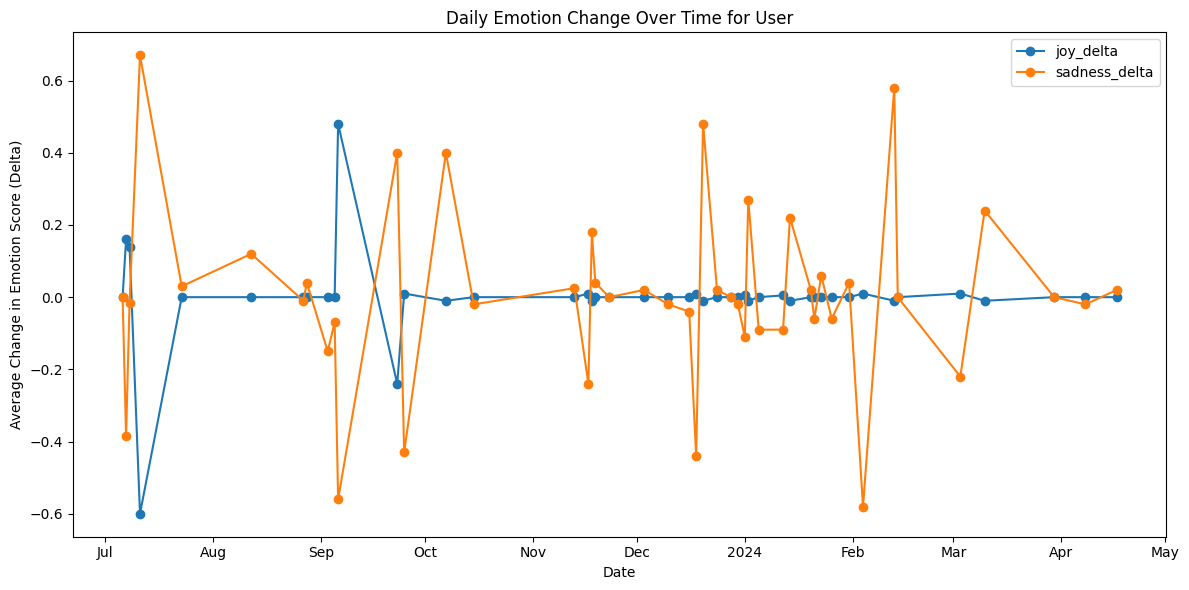

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1. Start from your DataFrame `df2`
df2 = df.copy()

# 2. Parse 'Timestamp' column into datetime format (handles mixed date formats)
df2['ParsedTimestamp'] = pd.to_datetime(df2['Timestamp'], format='mixed', errors='coerce')

# 3. Extract only the date part
df2['date'] = df2['ParsedTimestamp'].dt.date
df2 = df2.dropna(subset=['date'])  # drop rows where date couldn't be parsed

# 4. Convert 'date' back to datetime format (for plotting)
df2['date'] = pd.to_datetime(df2['date'])

# 5. Define emotions of interest
emotions = ["joy", "sadness"]
delta_cols = [f"{e}_delta" for e in emotions]

# 6. Sort and group by date
df2 = df2.sort_values('date')
daily_deltas = (
    df2.groupby('date')[delta_cols]
       .mean()
       .reset_index()
)

# 7. Plot emotion deltas
fig, ax = plt.subplots(figsize=(12, 6))
for col in delta_cols:
    ax.plot(daily_deltas['date'], daily_deltas[col], marker='o', label=col)

# 8. Improve date formatting on x-axis
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# 9. Final plot touches
ax.set_xlabel('Date')
ax.set_ylabel('Average Change in Emotion Score (Delta)')
ax.set_title('Daily Emotion Change Over Time for User')
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# 1. Assuming you already have df2 loaded for TrainMan102:
# df2 = pd.read_csv("extracted_features.csv")
# df2 = df2[df2['author_id']=='TrainMan102'].drop_duplicates('post_id').reset_index(drop=True)

# 2. Identify your one-hot encoded columns
coping_cols    = [c for c in df2.columns if c.startswith("HealthyCopingMechanism_")]
treatment_cols = [c for c in df2.columns if c.startswith("TreatmentMechanism_")]

# 3. Which coping mechanisms ever appear? (exclude 'None')
coping_used = [
    col.replace("HealthyCopingMechanism_", "")
    for col in coping_cols
    if df2[col].sum() > 0
]
coping_used = [mech for mech in coping_used if mech.lower() != 'none']


# 4. Flag any post where the user is seeking treatment
df2['seeking_treatment'] = df2[treatment_cols].any(axis=1)

# 5. Which treatment mechanisms ever appear? (exclude 'None')
treatment_used = [
    col.replace("TreatmentMechanism_", "")
    for col in treatment_cols
    if df2[col].sum() > 0
]
treatment_used = [mech for mech in treatment_used if mech.lower() != 'none']

# 6. Subset of posts where treatment is sought
treatment_posts = df2[df2['seeking_treatment']]

# 7. Print your summary
print("🔹 Coping mechanisms mentioned by crazytbh	:")
if coping_used:
    for mech in coping_used:
        print(f"  • {mech}")
else:
    print("  • None found")



print("\n🔹 Treatment mechanisms sought by crazytbh:")
if treatment_used:
    for mech in treatment_used:
        print(f"  • {mech}")
else:
    print("  • None found")



🔹 Coping mechanisms mentioned by crazytbh	:
  • Mindfulness_meditation

🔹 Treatment mechanisms sought by crazytbh:
  • None found


#Sentiment Analysis

In [ ]:
df=pd.read_csv("/content/drive/My Drive/Health_Analytics/Reddit/User_Data_chunk/suicide_features_ohe (1).csv")

In [ ]:
columns_list = df.columns.tolist()
print(columns_list)

In [ ]:
df.head(5)


In [ ]:
import pandas as pd

# Set max columns to None (i.e., unlimited)
pd.set_option('display.max_columns', None)

# Now this will show all columns
df.info()

In [ ]:
import pandas as pd

# Assuming your dataframe is named df and AuthorID is the user ID column
user_counts = df['AuthorID'].value_counts()

# Filter users with more than 5 rows
users_more_than_5 = user_counts[user_counts >= 5]

# Print how many such users
print(f"Number of users with min 5 rows: {len(users_more_than_5)}")

In [ ]:
# Step 1: Find users with more than 5 rows
user_counts = df['AuthorID'].value_counts()
valid_users = user_counts[user_counts >= 5].index

# Step 2: Filter the DataFrame
df2 = df[df['AuthorID'].isin(valid_users)].copy()

In [ ]:
len(df2)

In [ ]:
# Count posts per user in df2 (after any filtering)
user_post_counts = df2['AuthorID'].value_counts()

# Filter users who have >5 posts in df2
valid_users = user_post_counts[user_post_counts >= 5].index

# Final df2 with only those users
df2 = df2[df2['AuthorID'].isin(valid_users)].copy()

# Now get post distribution (clean and correct)
user_post_counts = df2['AuthorID'].value_counts()
post_count_distribution = user_post_counts.value_counts().sort_index()
print(post_count_distribution)

In [ ]:
import pandas as pd

# Expand display for all columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # Don't break across lines
pd.set_option('display.max_colwidth', None) # Show full content in each column

null_counts = df2.isnull().sum()
print(null_counts)

In [ ]:
df2 = df2.dropna(subset=['Timestamp'])

In [ ]:
unique_user_count = df2['AuthorID'].nunique()
print("Number of unique users in df2:", unique_user_count)

In [ ]:
present_focused_users = df2[df2['CopingMechanismTreatmentTemporalFocus_Present_focused'] == 1]['AuthorID'].nunique()
print("Number of users with Present-focused coping:", present_focused_users)

In [ ]:
# Step 1: Identify users who have at least one row with the value 1 in the target column
eligible_users = df2[df2['CopingMechanismTreatmentTemporalFocus_Present_focused'] == 1]['AuthorID'].unique()

# Step 2: Filter df2 to keep only rows from those users
df2_filtered = df2[df2['AuthorID'].isin(eligible_users)].copy()

# Step 3: (Optional) Check result
print("Filtered df2 shape:", df2_filtered.shape)
print("Unique users retained:", df2_filtered['AuthorID'].nunique())

In [ ]:
# Count number of rows per user
user_post_counts = df2_filtered['AuthorID'].value_counts()

# Filter users with at least 5 posts
users_with_min_5 = user_post_counts[user_post_counts >= 5]

# Output the count of such users
print("Number of users with at least 5 posts:", len(users_with_min_5))

In [ ]:
# Step 1: Count posts per user
user_post_counts = df2_filtered['AuthorID'].value_counts()

# Step 2: Identify users with at least 5 posts
valid_users = user_post_counts[user_post_counts >= 5].index

# Step 3: Filter df2_filtered to keep only those users
df2_filtered = df2_filtered[df2_filtered['AuthorID'].isin(valid_users)].copy()

In [ ]:
df3=df2_filtered

In [ ]:
# Count number of rows per user
user_post_counts = df3['AuthorID'].value_counts()

# Filter users with at least 5 posts
users_with_min_5 = user_post_counts[user_post_counts >= 5]

# Output the count of such users
print("Number of users with at least 5 posts:", len(users_with_min_5))

In [ ]:
# Step 3: Sort by AuthorID and Timestamp (assuming 'Timestamp' is your time column)
df3 = df3.sort_values(by=['AuthorID', 'Timestamp'])

In [ ]:
for emo in ["joy", "sadness", "anger", "fear", "surprise", "disgust"]:
    df3[emo] = df3["EmotionalScore"].str.extract(rf"{emo}:\s*([0-9.]+)").astype(float)

In [ ]:
null_counts = df3.isnull().sum()
print(null_counts)

In [ ]:
# Check where sadness is null but EmotionalScore is not null
problem_rows = df3[df3['sadness'].isnull() & df3['EmotionalScore'].notnull()]

print(problem_rows[['EmotionalScore', 'sadness', 'joy', 'anger', 'fear', 'disgust']].head(10))

In [ ]:
# Step 1: Remove quotes and normalize delimiters
df3['EmotionalScore'] = df3['EmotionalScore'].astype(str)
df3['EmotionalScore'] = df3['EmotionalScore'].str.replace(r'["“”]', '', regex=True)
df3['EmotionalScore'] = df3['EmotionalScore'].str.replace(r'-+', ', ', regex=True)  # replace - or -- with comma

# Step 2: Extract emotion scores
for emo in ["joy", "sadness", "anger", "fear", "surprise", "disgust"]:
    df3[emo] = df3['EmotionalScore'].str.extract(rf'{emo}:\s*([0-9.]+)').astype(float)

In [ ]:
# Check where sadness is null but EmotionalScore is not null
problem_rows = df3[df3['joy'].isnull() & df3['EmotionalScore'].notnull()]

print(problem_rows[['EmotionalScore', 'sadness', 'joy', 'anger', 'fear', 'disgust']].head(10))

In [ ]:
# Count rows where all emotion scores are NaN
inconsistent_count = df3[["joy", "sadness", "anger", "fear", "surprise", "disgust"]].isna().all(axis=1).sum()
print("Number of inconsistent EmotionalScore rows:", inconsistent_count)

In [ ]:
# Drop rows where all emotion scores are NaN
df3 = df3.dropna(subset=["joy", "sadness", "anger", "fear", "surprise", "disgust"], how='all')

In [ ]:
# Count number of rows per user
user_post_counts = df3['AuthorID'].value_counts()

# Filter users with at least 5 posts
users_with_min_5 = user_post_counts[user_post_counts >= 5]

# Output the count of such users
print("Number of users with at least 5 posts:", len(users_with_min_5))

In [ ]:
# Step 1: Count posts per user
user_post_counts = df3['AuthorID'].value_counts()

# Step 2: Identify users with at least 5 posts
valid_users = user_post_counts[user_post_counts >= 5].index

# Step 3: Filter df2_filtered to keep only those users
df3 = df3[df3['AuthorID'].isin(valid_users)].copy()

In [ ]:
# List of emotion columns
emotion_cols = ['sadness', 'joy', 'anger', 'fear', 'disgust', 'surprise']

# Count number of nulls in each emotion column
null_counts = df3[emotion_cols].isnull().sum()

print(null_counts)

In [ ]:
df3[emotion_cols] = df3[emotion_cols].fillna(0)

In [ ]:
df3.drop(columns=['surprise'], inplace=True)

In [ ]:
df3.drop(columns=['EmotionalScore_cleaned'], inplace=True)

In [ ]:
df3.head(5)

##Sorting users emotional score on different dates

In [ ]:
import pandas as pd

# Ensure Timestamp is in datetime format
df3['Timestamp'] = pd.to_datetime(df3['Timestamp'], errors='coerce')

# Drop rows with invalid/missing timestamps
df3 = df3.dropna(subset=['Timestamp'])

# Extract date
df3['New_Timestamp'] = df3['Timestamp'].dt.date

# Define emotion columns from df (adjust names if needed)
emotion_cols = ['sadness', 'joy', 'anger', 'fear', 'disgust']

# Group by AuthorID and date, and compute daily averages for emotion scores
daily_emotions = df3.groupby(['AuthorID', 'New_Timestamp'])[emotion_cols].mean().reset_index()

# Rename the averaged emotion columns to match your requirement
daily_emotions = daily_emotions.rename(columns={
    'sadness': 'new_sadness',
    'joy': 'new_joy',
    'anger': 'new_anger',
    'fear': 'new_fear',
    'disgust': 'new_disgust'
})

# Final DataFrame
EMO_score = daily_emotions[['AuthorID', 'New_Timestamp', 'new_sadness', 'new_joy', 'new_anger', 'new_fear', 'new_disgust']]


In [ ]:
EMO_score.head(5)

In [ ]:
unique_user_count = EMO_score['AuthorID'].nunique()
print("Number of unique users in EMO_score:", unique_user_count)

In [ ]:
user_row_counts = EMO_score['AuthorID'].value_counts()
users_with_more_than_5 = user_row_counts[user_row_counts >= 5]
print("Number of users with more than 5 rows:", len(users_with_more_than_5))

In [ ]:
# prompt: RENAME NEW_SADNESS, NEW_JOY..... TO SADNESS, JOY .... IN EMO SCORE

# Rename columns
EMO_score = EMO_score.rename(columns={
    'new_sadness': 'sadness',
    'new_joy': 'joy',
    'new_anger': 'anger',
    'new_fear': 'fear',
    'new_disgust': 'disgust',
    'New_Timestamp':'Timestamp'
})

In [ ]:
# Step 1: Count number of rows per user
user_row_counts = EMO_score['AuthorID'].value_counts()

# Step 2: Identify users with more than 5 rows
valid_users = user_row_counts[user_row_counts >= 5].index

# Step 3: Filter EMO_score to only keep those users
EMO_score = EMO_score[EMO_score['AuthorID'].isin(valid_users)].copy()

In [ ]:
# Step 1: List of emotions
emotion_cols = ['sadness', 'joy', 'anger', 'fear', 'disgust']

# Step 2: Sort the data properly
EMO_score = EMO_score.sort_values(by=['AuthorID', 'Timestamp'])

# Step 3: For each emotion, calculate change compared to previous post for each user
for emo in emotion_cols:
    EMO_score[f'{emo}_change'] = EMO_score.groupby('AuthorID')[emo].diff()

# Now you have new columns: sadness_change, joy_change, anger_change, fear_change, disgust_change

In [ ]:
columns_list = EMO_score.columns.tolist()
print(columns_list)

In [ ]:
df4=EMO_score

In [ ]:
df4.head(5)

##Emotion plot for single user

In [ ]:
import matplotlib.pyplot as plt

# Select a user
user_id = '11_Einsteins'  # replace with real AuthorID

# Filter user's data
user_data = df4[df4['AuthorID'] == user_id].sort_values(by='Timestamp')

# Plot sadness trajectory
plt.plot(user_data['Timestamp'], user_data['sadness'], marker='o', label='Sadness')
plt.title(f"Sadness Trajectory for {user_id}")
plt.xlabel("Time")
plt.ylabel("Sadness Level")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()


#Emotion Analysis

In [ ]:
emotion_cols = ['sadness', 'joy', 'anger', 'fear', 'disgust']

# Summary statistics for each emotion
emotion_summary = df4[emotion_cols].describe()

print(emotion_summary)


In [ ]:
for emo in ['sadness', 'joy', 'anger', 'fear', 'disgust']:
    print(f"{emo} max:", df4[emo].max())


##Emotion distribution across Gender

In [ ]:
len(df4)


In [ ]:
# Ensure unique gender per user
user_gender = df3[['AuthorID', 'Gender']].drop_duplicates()

# Merge gender into df4
df4 = df4.merge(user_gender, on='AuthorID', how='left')



emotion_cols = ['sadness', 'joy', 'anger', 'fear', 'disgust']


for gender in df3['Gender'].dropna().unique():
    print(f"\n📊 Emotion statistics for Gender: {gender}")
    display(df3[df3['Gender'] == gender][emotion_cols].describe())


In [ ]:
# Get unique AgeGroup per user
user_age = df3[['AuthorID', 'AgeGroup']].drop_duplicates()

# Merge with df3 (which has emotional scores)
df4 = df4.merge(user_age, on='AuthorID', how='left')


emotion_cols = ['sadness', 'joy', 'anger', 'fear', 'disgust']


for age_group in df3['AgeGroup'].dropna().unique():
    print(f"\n📌 Emotion stats for AgeGroup: {age_group}")
    group_df = df3[df3['AgeGroup'] == age_group]
    display(group_df[emotion_cols].describe())


##Emotion-changes for the users

In [ ]:
print("Min date:", df4['Timestamp'].min())
print("Max date:", df4['Timestamp'].max())


In [ ]:
emotions = ['sadness', 'joy', 'anger', 'fear', 'disgust']
results = []

for user, sub in df4.groupby('AuthorID'):
    user_result = {'AuthorID': user}
    has_data = False
    for emo in emotions:
        col = f"{emo}_change"
        if col in sub.columns:
            inc = (sub[col] > 0).sum()
            dec = (sub[col] < 0).sum()
            same = (sub[col] == 0).sum()

            total = inc + dec + same
            if total > 0:
                has_data = True
                user_result[f'{emo}_inc'] = inc
                user_result[f'{emo}_dec'] = dec
                user_result[f'{emo}_same'] = same
                user_result[f'{emo}_inc_ratio'] = inc / total
                user_result[f'{emo}_dec_ratio'] = dec / total
        else:
            print(f"Column missing: {col}")
    if has_data:
        results.append(user_result)

emotion_change_summary = pd.DataFrame(results)
print(emotion_change_summary.head())


In [ ]:
# prompt: results has how many user count

print(len(emotion_change_summary))


In [ ]:
# prompt: print all the columns in emotion_change summery

print(emotion_change_summary.columns.tolist())


###Improved-Declined Users

In [ ]:
def classify_user(row):
    if row['sadness_dec_ratio'] > 0.6 and row['joy_inc_ratio'] > 0.6:
        return 'Improved'
    elif row['sadness_inc_ratio'] > 0.6 and row['joy_dec_ratio'] > 0.6:
        return 'Declined'
    else:
        return 'Neutral'

emotion_change_summary['emotional_outcome'] = emotion_change_summary.apply(classify_user, axis=1)


In [ ]:
emotion_change_summary['emotional_outcome'].value_counts()


##Coping Mechanism in Improved-Declined user

In [ ]:
df3.head(5)

In [ ]:
df4.head(5)

In [ ]:
emotion_change_summary.head(5)

In [ ]:
# Step 1: Get coping mechanism columns
coping_cols = [col for col in df3.columns if col.startswith('HealthyCopingMechanism_')]

# Step 2: Collapse df2 to one row per user (1 if ever used that coping mechanism)
user_coping = df3.groupby('AuthorID')[coping_cols].max().reset_index()

# Step 3: Prepare emotional outcome data
user_outcome = emotion_change_summary[['AuthorID', 'emotional_outcome']].copy()
user_outcome['emotional_outcome'] = user_outcome['emotional_outcome'].str.strip().str.lower()

# Step 4: Merge to get one row per user with coping usage and outcome
coping_with_outcome = user_coping.merge(user_outcome, on='AuthorID', how='inner')

# Step 5: Filter improved and declined users
improved_users = coping_with_outcome[coping_with_outcome['emotional_outcome'] == 'improved']
declined_users = coping_with_outcome[coping_with_outcome['emotional_outcome'] == 'declined']

# Step 6: Count coping mechanism usage
improved_counts = improved_users[coping_cols].sum()
declined_counts = declined_users[coping_cols].sum()

# Step 7: Combine into summary table
coping_summary = pd.DataFrame({
    'Improved': improved_counts,
    'Declined': declined_counts
})

# Clean names
coping_summary.index = coping_summary.index.str.replace('HealthyCopingMechanism_', '')
coping_summary = coping_summary.sort_values(by='Improved', ascending=False)

# Show result
print(coping_summary)


##Treatment-Mechanism in improved-Declined user

In [ ]:
# Get treatment mechanism columns
treatment_cols = [col for col in df3.columns if col.startswith('TreatmentMechanism_')]

# Group by AuthorID: if user used the treatment in any row, set to 1
user_treatment = df3.groupby('AuthorID')[treatment_cols].max().reset_index()


In [ ]:
user_outcome = emotion_change_summary[['AuthorID', 'emotional_outcome']].copy()
user_outcome['emotional_outcome'] = user_outcome['emotional_outcome'].str.strip().str.lower()

# Merge
treatment_with_outcome = user_treatment.merge(user_outcome, on='AuthorID', how='inner')


In [ ]:
def get_treatment_combo(row):
    combo = [col.replace('TreatmentMechanism_', '') for col in treatment_cols if row[col] == 1]
    return '+'.join(sorted(combo)) if combo else 'None'

treatment_with_outcome['TreatmentCombo'] = treatment_with_outcome.apply(get_treatment_combo, axis=1)


In [ ]:
combo_counts = treatment_with_outcome.groupby(['TreatmentCombo', 'emotional_outcome']).size().unstack(fill_value=0)
combo_counts = combo_counts.sort_values(by='improved', ascending=False)
print(combo_counts)


In [ ]:
# Step 1: Get user-level treatment usage (1 if ever used)
treatment_cols = [col for col in df3.columns if col.startswith('TreatmentMechanism_')]
user_treatment = df3.groupby('AuthorID')[treatment_cols].max().reset_index()

# Step 2: Get emotional outcome (one row per user)
user_outcome = emotion_change_summary[['AuthorID', 'emotional_outcome']].copy()
user_outcome['emotional_outcome'] = user_outcome['emotional_outcome'].str.strip().str.lower()

# Step 3: Merge into one user-level DataFrame
merged = user_treatment.merge(user_outcome, on='AuthorID', how='inner')

# Step 4: Split into improved and declined
improved_users = merged[merged['emotional_outcome'] == 'improved']
declined_users = merged[merged['emotional_outcome'] == 'declined']

# Step 5: Sum per treatment mechanism
improved_counts = improved_users[treatment_cols].sum()
declined_counts = declined_users[treatment_cols].sum()

# Step 6: Final table
summary = pd.DataFrame({'Improved': improved_counts, 'Declined': declined_counts})
summary.index = summary.index.str.replace('TreatmentMechanism_', '')
summary = summary.sort_values(by='Improved', ascending=False)

print(summary)


#Gender-wise coping-mechanism which improved or declined the user emotion

In [ ]:
# Step 1: Get coping columns
coping_cols = [col for col in df3.columns if col.startswith('HealthyCopingMechanism_')]

# Step 2: Collapse to one row per user (coping usage)
user_coping = df3.groupby('AuthorID')[coping_cols].max().reset_index()
user_gender = df3[['AuthorID', 'Gender']].drop_duplicates()

# Step 3: Merge gender and outcome
user_outcome = emotion_change_summary[['AuthorID', 'emotional_outcome']].copy()
user_outcome['emotional_outcome'] = user_outcome['emotional_outcome'].str.strip().str.lower()

coping_data = user_coping.merge(user_gender, on='AuthorID').merge(user_outcome, on='AuthorID')


In [ ]:
coping_long = coping_data.melt(
    id_vars=['AuthorID', 'Gender', 'emotional_outcome'],
    value_vars=coping_cols,
    var_name='HealthyCopingMechanism',
    value_name='Used'
)

coping_long = coping_long[coping_long['Used'] == 1]
coping_long['HealthyCopingMechanism'] = coping_long['HealthyCopingMechanism'].str.replace('HealthyCopingMechanism_', '')


In [ ]:
genders = coping_long['Gender'].dropna().unique()

for gender in genders:
    print(f"\n📊 Coping Mechanism Summary for Gender: {gender}")
    gender_df = coping_long[coping_long['Gender'] == gender]
    summary = gender_df.groupby(['HealthyCopingMechanism', 'emotional_outcome']).size().unstack(fill_value=0)

    # Ensure both columns exist
    for col in ['improved', 'declined']:
        if col not in summary.columns:
            summary[col] = 0

    summary = summary[['improved', 'declined']]
    display(summary.sort_values(by='improved', ascending=False))

#Age-group wise coping-mechanism which improved or declined user emotion

In [ ]:
# Step 1: Get coping mechanism columns
coping_cols = [col for col in df3.columns if col.startswith('HealthyCopingMechanism_')]

# Step 2: Collapse to one row per user: max = 1 if user used that mechanism
user_coping = df3.groupby('AuthorID')[coping_cols].max().reset_index()

# Step 3: Get unique AgeGroup per user
user_age = df3[['AuthorID', 'AgeGroup']].drop_duplicates()

# Step 4: Prepare emotional outcome
user_outcome = emotion_change_summary[['AuthorID', 'emotional_outcome']].copy()
user_outcome['emotional_outcome'] = user_outcome['emotional_outcome'].str.strip().str.lower()

# Step 5: Merge all
coping_data = user_coping.merge(user_age, on='AuthorID').merge(user_outcome, on='AuthorID')


In [ ]:
coping_long = coping_data.melt(
    id_vars=['AuthorID', 'AgeGroup', 'emotional_outcome'],
    value_vars=coping_cols,
    var_name='HealthyCopingMechanism',
    value_name='Used'
)

# Keep only rows where coping was used
coping_long = coping_long[coping_long['Used'] == 1]
coping_long['HealthyCopingMechanism'] = coping_long['HealthyCopingMechanism'].str.replace('HealthyCopingMechanism_', '')


In [ ]:
AgeGroups = coping_long['AgeGroup'].dropna().unique()


In [ ]:
for age in AgeGroups:
    print(f"\n📊 Coping Mechanism Summary for Age Group: {age}")
    age_df = coping_long[coping_long['AgeGroup'] == age]
    summary = age_df.groupby(['HealthyCopingMechanism', 'emotional_outcome']).size().unstack(fill_value=0)

    # Add missing columns if they don't exist
    for col in ['improved', 'declined']:
        if col not in summary.columns:
            summary[col] = 0

    # Reorder columns and sort
    summary = summary[['improved', 'declined']]
    display(summary.sort_values(by='improved', ascending=False))



#Gender-wise treatment mechanism which improved or declined the user emotion

In [ ]:
# Step 1: Get treatment mechanism columns
treatment_cols = [col for col in df3.columns if col.startswith('TreatmentMechanism_')]

# Step 2: Collapse to 1 row per user — treatment usage
user_treatment = df3.groupby('AuthorID')[treatment_cols].max().reset_index()

# Step 3: Get gender and outcome (one row per user)
user_gender = df3[['AuthorID', 'Gender']].drop_duplicates()
user_outcome = emotion_change_summary[['AuthorID', 'emotional_outcome']].copy()
user_outcome['emotional_outcome'] = user_outcome['emotional_outcome'].str.strip().str.lower()

# Step 4: Merge into one user-level DataFrame
merged = user_treatment.merge(user_gender, on='AuthorID').merge(user_outcome, on='AuthorID', how='inner')

# Step 5: Loop through each gender and compute treatment summary
for gender in merged['Gender'].dropna().unique():
    print(f"\n📊 Treatment Mechanism Summary for Gender: {gender}")

    gender_df = merged[merged['Gender'] == gender]

    improved_users = gender_df[gender_df['emotional_outcome'] == 'improved']
    declined_users = gender_df[gender_df['emotional_outcome'] == 'declined']

    improved_counts = improved_users[treatment_cols].sum()
    declined_counts = declined_users[treatment_cols].sum()

    summary = pd.DataFrame({'Improved': improved_counts, 'Declined': declined_counts})
    summary.index = summary.index.str.replace('TreatmentMechanism_', '')
    summary = summary.sort_values(by='Improved', ascending=False)

    display(summary)


#Age-group wise  treatment mechanism across improved/declined user

In [ ]:
# Step 1: Get treatment mechanism columns
treatment_cols = [col for col in df3.columns if col.startswith('TreatmentMechanism_')]

# Step 2: Collapse to 1 row per user — max = 1 if used
user_treatment = df3.groupby('AuthorID')[treatment_cols].max().reset_index()

# Step 3: Add AgeGroup and emotional outcome
user_age = df3[['AuthorID', 'AgeGroup']].drop_duplicates()
user_outcome = emotion_change_summary[['AuthorID', 'emotional_outcome']].copy()
user_outcome['emotional_outcome'] = user_outcome['emotional_outcome'].str.strip().str.lower()

# Step 4: Merge into user-level treatment + age + outcome table
merged = user_treatment.merge(user_age, on='AuthorID').merge(user_outcome, on='AuthorID', how='inner')


In [ ]:
# Loop over each AgeGroup
for age_group in merged['AgeGroup'].dropna().unique():
    print(f"\n📊 Treatment Mechanism Summary for Age Group: {age_group}")

    age_df = merged[merged['AgeGroup'] == age_group]

    improved_users = age_df[age_df['emotional_outcome'] == 'improved']
    declined_users = age_df[age_df['emotional_outcome'] == 'declined']

    improved_counts = improved_users[treatment_cols].sum()
    declined_counts = declined_users[treatment_cols].sum()

    summary = pd.DataFrame({'Improved': improved_counts, 'Declined': declined_counts})
    summary.index = summary.index.str.replace('TreatmentMechanism_', '')
    summary = summary.sort_values(by='Improved', ascending=False)

    display(summary)


#Statistical-Analysis

##coping_mechanism

In [ ]:
# Get coping mechanism columns
coping_cols = [col for col in df3.columns if col.startswith('HealthyCopingMechanism_')]

# Collapse to user-level: max() = 1 if user used that coping mechanism at least once
user_coping = df3.groupby('AuthorID')[coping_cols].max().reset_index()


In [ ]:
# Filter emotion_change_summary to users with valid joy_inc_ratio
user_joy = emotion_change_summary[['AuthorID', 'joy_inc_ratio']].dropna()

# Merge user-level coping usage with joy ratio
merged = user_coping.merge(user_joy, on='AuthorID', how='inner')


In [ ]:
from scipy.stats import mannwhitneyu

results = []

for col in coping_cols:
    used = merged[merged[col] == 1]['joy_inc_ratio']
    not_used = merged[merged[col] == 0]['joy_inc_ratio']

    # Skip if sample size is too small
    if len(used) < 5 or len(not_used) < 5:
        continue

    stat, p = mannwhitneyu(used, not_used, alternative='two-sided')

    results.append({
        'Coping Mechanism': col.replace('HealthyCopingMechanism_', ''),
        'Used N': len(used),
        'Not Used N': len(not_used),
        'U-statistic': round(stat, 2),
        'p-value': round(p, 5),
        'Significant (p < 0.05)': '✅' if p < 0.05 else '❌'
    })


In [ ]:
import pandas as pd

result_df = pd.DataFrame(results).sort_values(by='p-value')
display(result_df)


##for treatment_mechanism

In [ ]:
# Get treatment mechanism columns
treatment_cols = [col for col in df3.columns if col.startswith('TreatmentMechanism_')]

# User-level usage: 1 if ever used that treatment mechanism
user_treatment = df3.groupby('AuthorID')[treatment_cols].max().reset_index()


In [ ]:
# From emotion_change_summary
user_joy = emotion_change_summary[['AuthorID', 'joy_inc_ratio']].dropna()

# Merge treatment data with joy ratio
merged = user_treatment.merge(user_joy, on='AuthorID', how='inner')


In [ ]:
from scipy.stats import mannwhitneyu

treatment_results = []

for col in treatment_cols:
    used = merged[merged[col] == 1]['joy_inc_ratio']
    not_used = merged[merged[col] == 0]['joy_inc_ratio']

    # Skip if group too small
    if len(used) < 5 or len(not_used) < 5:
        continue

    stat, p = mannwhitneyu(used, not_used, alternative='two-sided')

    treatment_results.append({
        'Treatment Mechanism': col.replace('TreatmentMechanism_', ''),
        'Used N': len(used),
        'Not Used N': len(not_used),
        'U-statistic': round(stat, 2),
        'p-value': round(p, 5),
        'Significant (p < 0.05)': '✅' if p < 0.05 else '❌'
    })


In [ ]:
treatment_sig_df = pd.DataFrame(treatment_results).sort_values(by='p-value')
display(treatment_sig_df)


#Emotional-Instability

In [ ]:
# Emotions to analyze
emotions = ['joy', 'sadness', 'anger', 'fear', 'disgust']

# Create new instability columns
for emo in emotions:
    inc = emotion_change_summary[f'{emo}_inc']
    dec = emotion_change_summary[f'{emo}_dec']
    same = emotion_change_summary[f'{emo}_same']

    emotion_change_summary[f'{emo}_instability'] = (inc + dec) / (inc + dec + same + 1e-6)  # to avoid division by zero


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

for emo in emotions:
    plt.figure()
    sns.histplot(emotion_change_summary[f'{emo}_instability'], bins=20, kde=True)
    plt.title(f"{emo.capitalize()} Instability Distribution")
    plt.xlabel("Instability Score")
    plt.ylabel("User Count")
    plt.grid()
    plt.show()


In [ ]:
user_demo = df3[['AuthorID', 'Gender', 'AgeGroup']].drop_duplicates()
emo_instability_merged = emotion_change_summary.merge(user_demo, on='AuthorID', how='left')


In [ ]:

for emo in emotions:
    sns.boxplot(data=emo_instability_merged, x='Gender', y=f'{emo}_instability')
    plt.title(f"{emo.capitalize()} Instability by Gender")
    plt.show()


In [ ]:
for emo in emotions:
    sns.boxplot(data=emotion_change_summary, x='emotional_outcome', y=f'{emo}_instability')
    plt.title(f"{emo.capitalize()} Instability vs Emotional Outcome")
    plt.show()


##mental-instabillity adding to mental illness

In [ ]:
# Select all mental illness trait columns
illness_cols = [col for col in df3.columns if col.startswith('MentalIllnessTraits_')]

# Aggregate to user level: 1 if trait was ever mentioned
user_illness_flags = df3.groupby('AuthorID')[illness_cols].max().reset_index()


In [ ]:
# Merge with emotion_change_summary (which has instability columns)
merged_df = emotion_change_summary.merge(user_illness_flags, on='AuthorID', how='inner')


In [ ]:
from scipy.stats import mannwhitneyu
results = []

for col in illness_cols:
    group1 = merged_df[merged_df[col] == 1]['sadness_instability']
    group0 = merged_df[merged_df[col] == 0]['sadness_instability']

    if len(group1) > 5 and len(group0) > 5:
        stat, p = mannwhitneyu(group1, group0, alternative='two-sided')
        results.append({
            'Mental Illness Trait': col.replace('MentalIllnessTraits_', ''),
            'Users with Trait': len(group1),
            'Users without': len(group0),
            'Mean Instability (with)': round(group1.mean(), 3),
            'Mean Instability (without)': round(group0.mean(), 3),
            'p-value': round(p, 5),
            'Significant (p < 0.05)': p < 0.05
        })

# Convert to DataFrame
import pandas as pd
instability_results_df = pd.DataFrame(results).sort_values(by='p-value')
display(instability_results_df)


In [ ]:
# Make sure you're using emotion_change_summary
increase_cols = [col for col in emotion_change_summary.columns if col.endswith('_inc')]
decrease_cols = [col for col in emotion_change_summary.columns if col.endswith('_dec')]
same_cols = [col for col in emotion_change_summary.columns if col.endswith('_same')]

# Confirm columns found
print("INC:", increase_cols)
print("DEC:", decrease_cols)
print("SAME:", same_cols)

# Now compute total_instability per user
emotion_change_summary['total_instability'] = (
    emotion_change_summary[increase_cols + decrease_cols].sum(axis=1)
) / (
    emotion_change_summary[increase_cols + decrease_cols + same_cols].sum(axis=1) + 1e-6  # avoid division by zero
)



In [ ]:
emotion_change_summary[['AuthorID', 'total_instability']].head()



In [ ]:
# Step 1: Make sure total_instability is calculated
emotion_change_summary['total_instability'] = (
    emotion_change_summary[increase_cols + decrease_cols].sum(axis=1)
) / (
    emotion_change_summary[increase_cols + decrease_cols + same_cols].sum(axis=1) + 1e-6
)

# Step 2: Select only AuthorID and total_instability
instability_df = emotion_change_summary[['AuthorID', 'total_instability']]

# Step 3: Merge into merged_df
merged_df = merged_df.merge(instability_df, on='AuthorID', how='left')


In [ ]:
from scipy.stats import mannwhitneyu
results = []

for col in illness_cols:
    group1 = merged_df[merged_df[col] == 1]['total_instability']
    group0 = merged_df[merged_df[col] == 0]['total_instability']

    if len(group1) > 5 and len(group0) > 5:
        stat, p = mannwhitneyu(group1, group0, alternative='two-sided')
        results.append({
            'Mental Illness Trait': col.replace('MentalIllnessTraits_', ''),
            'Users with Trait': len(group1),
            'Users without': len(group0),
            'Mean Instability (with)': round(group1.mean(), 3),
            'Mean Instability (without)': round(group0.mean(), 3),
            'p-value': round(p, 5),
            'Significant (p < 0.05)': p < 0.05
        })

# Convert to DataFrame
import pandas as pd
instability_results_df = pd.DataFrame(results).sort_values(by='p-value')
display(instability_results_df)
